# Predicting the outcome of tennis matches

BASIC SETUPS

In [1]:
# Setup: mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setup: imports
import os
import numpy as np
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy.optimize import minimize
import time

In [3]:
# Data loading function: read {prefix}{YEAR}.csv across [start_year, end_year] and concatenate
def load_data(
    data_dir: str,
    start_year: int,
    end_year: int,
    prefix: str,
) -> pd.DataFrame:
    """
    Load CSVs named as {prefix}{YEAR}.csv from `data_dir` for the contiguous
    window [start_year, end_year] (inclusive). Verify that all files
    exist and that column sets match exactly; then concatenate and return one DataFrame.

    Parameters
    ----------
    data_dir : str
        Directory containing the CSV files.
    start_year : int
        Earliest year to include (inclusive).
    end_year : int
        Latest year to include (inclusive).
    prefix : str
        Filename prefix, e.g. "atp_matches_" (files look like "atp_matches_2024.csv").

    Returns
    -------
    pd.DataFrame
        Concatenated DataFrame across the selected years, with a `year` column added.

    Raises
    ------
    FileNotFoundError
        If any target file is missing or the data directory does not exist.
    ValueError
        If start_year > end_year or if column sets differ between files.
    """
    # Guard: valid year window
    if start_year > end_year:
        raise ValueError("start_year must be less than or equal to end_year.")

    # Guard: directory exists
    if not os.path.isdir(data_dir):
        raise FileNotFoundError(f"Data directory does not exist: {data_dir}")

    # Build year list and corresponding file paths
    years = list(range(start_year, end_year + 1))
    paths = [os.path.join(data_dir, f"{prefix}{y}.csv") for y in years]

    # Verify all required files exist
    missing_years = [y for y, p in zip(years, paths) if not os.path.exists(p)]
    if missing_years:
        raise FileNotFoundError(f"Missing files for years {missing_years}.")

    # Read files, enforce identical schema, and annotate with 'year'
    dfs = []
    ref_cols = None
    for y, p in zip(years, paths):
        df = pd.read_csv(p, low_memory=False)
        df["year"] = y

        if ref_cols is None:
            ref_cols = list(df.columns)         # establish reference schema and order
        else:
            current_cols = set(df.columns)
            reference_cols = set(ref_cols)
            if current_cols != reference_cols:
                # Detailed mismatch report vs first file
                raise ValueError(
                    "Column mismatch detected.\n"
                    f"- Missing in {y}: {sorted(list(reference_cols - current_cols))}\n"
                    f"- Extra in {y}: {sorted(list(current_cols - reference_cols))}"
                )
            df = df[ref_cols]                   # align order for stable concatenation

        dfs.append(df)

    # Defensive: no data loaded
    if not dfs:
        raise FileNotFoundError("No files loaded for the requested window.")

    # Final concatenate
    return pd.concat(dfs, ignore_index=True, sort=False)

In [4]:
# Load Data: ATP match CSVs (1990–2019) and preview
tennis_df = load_data(
    data_dir="/content/drive/MyDrive/tennis_data",
    start_year=1990,
    end_year=2019,
    prefix="atp_matches_",
)

# Preview
display(tennis_df.head())

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1990-339,Adelaide,Hard,32,A,19900101,1,101843,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,25.0,591.0,282.0,70.0,1990
1,1990-339,Adelaide,Hard,32,A,19900101,2,100714,NaN,WC,...,NaN,NaN,NaN,NaN,NaN,146.0,157.0,127.0,182.0,1990
2,1990-339,Adelaide,Hard,32,A,19900101,3,101529,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,113.0,215.0,71.0,290.0,1990
3,1990-339,Adelaide,Hard,32,A,19900101,4,100628,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,68.0,297.0,80.0,271.0,1990
4,1990-339,Adelaide,Hard,32,A,19900101,5,101404,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,34.0,496.0,100.0,224.0,1990


In [5]:
tennis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98882 entries, 0 to 98881
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          98882 non-null  object 
 1   tourney_name        98882 non-null  object 
 2   surface             98882 non-null  object 
 3   draw_size           98882 non-null  int64  
 4   tourney_level       98882 non-null  object 
 5   tourney_date        98882 non-null  int64  
 6   match_num           98882 non-null  int64  
 7   winner_id           98882 non-null  int64  
 8   winner_seed         39842 non-null  float64
 9   winner_entry        11775 non-null  object 
 10  winner_name         98882 non-null  object 
 11  winner_hand         98882 non-null  object 
 12  winner_ht           96570 non-null  float64
 13  winner_ioc          98882 non-null  object 
 14  winner_age          98875 non-null  float64
 15  loser_id            98882 non-null  int64  
 16  lose

In [6]:
# Inspect only columns that we are interested in.

cols = ['tourney_id','tourney_date','match_num',"surface", "round","tourney_level", "winner_id", "winner_name", "winner_hand",
        "winner_ht", "winner_age", "loser_id", "loser_name", "loser_hand",
        "loser_ht", "loser_age", "score", "best_of", 'winner_rank',
        'winner_rank_points', 'loser_rank', 'loser_rank_points']

# Numeric-like columns for summary statistics
QUANT_COLS = ["winner_ht", "winner_age", "loser_ht", "loser_age", "best_of",
              "winner_rank", "loser_rank", "winner_rank_points", "loser_rank_points"]

# Overview: dataset size
print(f"Total number of matches loaded: {len(tennis_df):,}\n")

# Profiling loop: type, missingness, uniques, describe (if numeric), and top counts
for col in cols:
    if col not in tennis_df.columns:
        print(f"!!! COLUMN NOT FOUND: {col} !!!")
        print("="*80)
        continue

    # Missingness and basic stats
    n_missing = tennis_df[col].isna().sum()
    pct_missing = n_missing / len(tennis_df) * 100

    print(f"----- COLUMN: {col} -----")
    print(f"Data Type: {tennis_df[col].dtype}")
    print(f"Number of unique values: {tennis_df[col].nunique():,}")
    print(f"Number of missing values: {n_missing:,}")
    print(f"Percentage of missing values: {pct_missing:.4f}%")

    # If quantitative, show distribution summary
    if col in QUANT_COLS:
        print("\nSummary Statistics:")
        display(tennis_df[col].describe())

    # Frequency peek: top 10 including NaNs
    print("\nTop Value Counts (including NaNs):")
    display(tennis_df[col].value_counts(dropna=False).head(10))
    print("="*80)

Total number of matches loaded: 98,882

----- COLUMN: tourney_id -----
Data Type: object
Number of unique values: 4,554
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
tourney_id,
2019-560,127
2019-540,127
1990-580,127
2011-520,127
2011-540,127
2012-560,127
1992-520,127
2000-580,127
2000-560,127


----- COLUMN: tourney_date -----
Data Type: int64
Number of unique values: 1,394
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
tourney_date,
19960812,141
19960415,141
20050304,136
20090306,136
19920720,133
20100305,132
20150306,131
20110304,131
20160718,128


----- COLUMN: match_num -----
Data Type: int64
Number of unique values: 495
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
match_num,
1,4271
2,4269
4,4229
5,4060
6,1898
10,1898
9,1898
11,1898
8,1898


----- COLUMN: surface -----
Data Type: object
Number of unique values: 4
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
surface,
Hard,48157
Clay,33269
Grass,9551
Carpet,7905


----- COLUMN: round -----
Data Type: object
Number of unique values: 10
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
round,
R32,32368
R16,16928
R64,15064
RR,10331
R128,9152
QF,8488
SF,4310
F,2201
ER,32


----- COLUMN: tourney_level -----
Data Type: object
Number of unique values: 5
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
tourney_level,
A,57217
M,16690
G,15240
D,9238
F,497


----- COLUMN: winner_id -----
Data Type: int64
Number of unique values: 2,192
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
winner_id,
103819,1251
104745,987
104925,905
103970,740
101948,738
101736,737
104918,682
104607,643
103720,619


----- COLUMN: winner_name -----
Data Type: object
Number of unique values: 2,193
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
winner_name,
Roger Federer,1251
Rafael Nadal,987
Novak Djokovic,905
David Ferrer,740
Pete Sampras,738
Andre Agassi,737
Andy Murray,682
Tomas Berdych,643
Lleyton Hewitt,619


----- COLUMN: winner_hand -----
Data Type: object
Number of unique values: 4
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
winner_hand,
R,84499
L,13894
U,474
A,15


----- COLUMN: winner_ht -----
Data Type: float64
Number of unique values: 29
Number of missing values: 2,312
Percentage of missing values: 2.3381%

Summary Statistics:


,winner_ht
count,96570.000000
mean,185.501346
std,6.742097
min,3.000000
25%,180.000000
50%,185.000000
75%,190.000000
max,211.000000



Top Value Counts (including NaNs):


,count
winner_ht,
185.0,16329
188.0,14418
183.0,13334
180.0,12093
190.0,8488
193.0,7267
175.0,5968
178.0,5138
196.0,3933


----- COLUMN: winner_age -----
Data Type: float64
Number of unique values: 255
Number of missing values: 7
Percentage of missing values: 0.0071%

Summary Statistics:


,winner_age
count,98875.000000
mean,25.609605
std,3.708619
min,14.300000
25%,22.900000
50%,25.400000
75%,28.100000
max,42.700000



Top Value Counts (including NaNs):


,count
winner_age,
24.7,1083
26.0,1073
25.0,1057
23.6,1052
25.1,1050
26.2,1048
25.4,1035
24.5,1032
24.8,1028


----- COLUMN: loser_id -----
Data Type: int64
Number of unique values: 3,216
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
loser_id,
103852,447
102148,438
104022,423
104269,417
104312,397
104259,380
103970,379
102035,362
103990,361


----- COLUMN: loser_name -----
Data Type: object
Number of unique values: 3,217
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
loser_name,
Feliciano Lopez,447
Fabrice Santoro,438
Mikhail Youzhny,423
Fernando Verdasco,417
Andreas Seppi,397
Philipp Kohlschreiber,380
David Ferrer,379
Jonas Bjorkman,362
Tommy Robredo,361


----- COLUMN: loser_hand -----
Data Type: object
Number of unique values: 4
Number of missing values: 4
Percentage of missing values: 0.0040%

Top Value Counts (including NaNs):


,count
loser_hand,
R,83293
L,14283
U,1272
A,30
NaN,4


----- COLUMN: loser_ht -----
Data Type: float64
Number of unique values: 29
Number of missing values: 4,534
Percentage of missing values: 4.5853%

Summary Statistics:


,loser_ht
count,94348.000000
mean,185.031797
std,6.669757
min,3.000000
25%,180.000000
50%,185.000000
75%,190.000000
max,211.000000



Top Value Counts (including NaNs):


,count
loser_ht,
185.0,15129
183.0,14260
188.0,13828
180.0,12086
190.0,8252
193.0,6417
178.0,5741
175.0,5691
NaN,4534


----- COLUMN: loser_age -----
Data Type: float64
Number of unique values: 269
Number of missing values: 21
Percentage of missing values: 0.0212%

Summary Statistics:


,loser_age
count,98861.000000
mean,25.691592
std,3.828215
min,14.500000
25%,22.900000
50%,25.500000
75%,28.300000
max,44.000000



Top Value Counts (including NaNs):


,count
loser_age,
26.0,1069
24.9,1045
25.5,1032
24.5,1014
25.1,1009
24.1,1006
25.9,1003
25.0,995
26.2,986


----- COLUMN: score -----
Data Type: object
Number of unique values: 14,842
Number of missing values: 0
Percentage of missing values: 0.0000%

Top Value Counts (including NaNs):


,count
score,
6-3 6-4,3159
6-4 6-4,3156
6-3 6-2,2261
6-4 6-2,2129
6-4 6-3,2048
6-3 6-3,1992
6-2 6-4,1720
6-2 6-2,1535
6-2 6-3,1432


----- COLUMN: best_of -----
Data Type: int64
Number of unique values: 2
Number of missing values: 0
Percentage of missing values: 0.0000%

Summary Statistics:


,best_of
count,98882.000000
mean,3.443519
std,0.830864
min,3.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,5.000000



Top Value Counts (including NaNs):


,count
best_of,
3,76954
5,21928


----- COLUMN: winner_rank -----
Data Type: float64
Number of unique values: 1,196
Number of missing values: 1,230
Percentage of missing values: 1.2439%

Summary Statistics:


,winner_rank
count,97652.000000
mean,81.950344
std,136.504204
min,1.000000
25%,19.000000
50%,47.000000
75%,90.000000
max,2101.000000



Top Value Counts (including NaNs):


,count
winner_rank,
1.0,1923
2.0,1811
3.0,1646
7.0,1533
5.0,1488
4.0,1485
6.0,1433
8.0,1348
9.0,1328


----- COLUMN: winner_rank_points -----
Data Type: float64
Number of unique values: 3,952
Number of missing values: 2,405
Percentage of missing values: 2.4322%

Summary Statistics:


,winner_rank_points
count,96477.000000
mean,1354.839413
std,1687.010721
min,1.000000
25%,501.000000
50%,844.000000
75%,1516.000000
max,16950.000000



Top Value Counts (including NaNs):


,count
winner_rank_points,
NaN,2405
860.0,176
730.0,176
950.0,162
1.0,152
1295.0,152
895.0,148
785.0,145
855.0,144


----- COLUMN: loser_rank -----
Data Type: float64
Number of unique values: 1,411
Number of missing values: 2,582
Percentage of missing values: 2.6112%

Summary Statistics:


,loser_rank
count,96300.000000
mean,120.370426
std,180.202248
min,1.000000
25%,37.000000
50%,71.000000
75%,121.000000
max,2159.000000



Top Value Counts (including NaNs):


,count
loser_rank,
NaN,2582
39.0,753
46.0,752
44.0,749
37.0,749
33.0,745
47.0,745
40.0,745
34.0,744


----- COLUMN: loser_rank_points -----
Data Type: float64
Number of unique values: 3,806
Number of missing values: 3,749
Percentage of missing values: 3.7914%

Summary Statistics:


,loser_rank_points
count,95133.000000
mean,849.162961
std,951.083199
min,1.000000
25%,371.000000
50%,624.000000
75%,998.000000
max,16950.000000



Top Value Counts (including NaNs):


,count
loser_rank_points,
NaN,3749
1.0,328
2.0,206
770.0,162
3.0,157
785.0,157
685.0,156
950.0,154
5.0,154


## Data Cleaning


## Duplicated row removal function
Check for the duplicate match entries.

In [7]:
# Duplicates cleaning function: remove duplicate matches by key columns (keep first)
def remove_duplicates(
    df: pd.DataFrame,
    identification_cols: list = None
) -> pd.DataFrame:
    """
    Identifies and removes duplicate match rows based on specified identifying columns.
    Only the first occurrence is kept.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing match data.
    identification_cols : list, optional
        List of column names used to identify a unique match.
        Defaults to ['tourney_id', 'match_num', 'tourney_date', 'winner_id', 'loser_id'].

    Returns
    -------
    pd.DataFrame
        The DataFrame with duplicates removed, and index reset.
    """

    # Set default columns if none are provided
    if identification_cols is None:
        identification_cols = ['tourney_id', 'match_num', 'tourney_date', 'winner_id', 'loser_id']

    # Check if all required columns exist in the DataFrame
    missing_cols = [col for col in identification_cols if col not in df.columns]
    if missing_cols:
        print(f"!!! Cannot check duplicates. Missing columns: {missing_cols} !!!")
        return df # Return original DF if critical columns are missing

    # Count duplicates and rows before operation
    n_before_dedup = len(df)

    # Count how many rows are part of a duplicate set (keep=False)
    n_dups_total = df.duplicated(subset=identification_cols, keep=False).sum()

    # Drop duplicates (keep='first')
    df_clean = df.drop_duplicates(subset=identification_cols, keep='first').reset_index(drop=True)

    # Calculate rows removed
    n_after_dedup = len(df_clean)
    rows_removed = n_before_dedup - n_after_dedup

    # Calculate percentage removed
    pct_removed = (rows_removed / n_before_dedup) * 100 if n_before_dedup > 0 else 0

    # Reporting
    print("----- Duplicate Row Check -----")
    print(f"Number of rows identified as duplicates (total instances): {n_dups_total:,}")
    print(f"Number of duplicate rows removed: {rows_removed:,}")
    print(f"Percentage of rows removed: {pct_removed:.4f}%")

    # Return: de-duplicated DataFrame with reset index
    return df_clean

## Tournament level filtering function
We model only tour-level individual events (Grand Slams = G, Masters 1000 = M, ATP tour events = A, year-end finals = F) and exclude Davis Cup (D).

The decision was made on the facts that
- Davis Cup has different competition construct. Davis Cup is a national team event with a captain who selects lineups and is allowed to talk to players courtside during play. That coaching and selection dynamic does not exist in regular ATP events, so it alters decision-making and in-match behavior in ways our target setting never sees.
- Host-controlled environment. In Davis Cup home nations can choose the court surface and the ball, which strategically tilts conditions toward local strengths. Regular ATP events have fixed venue conditions set by the tournament, so including D injects a venue-selection confound that does not generalize to week-to-week tour play.


In [8]:
# Filtering: keep standard tour-level events (Grand Slams, Masters 1000, ATP Tour, Tour Finals)

def filter_tour_level(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the DataFrame to include only standard tour-level events
    (Grand Slams, Masters 1000s, ATP Tour, and Tour Finals).
    Excludes Challengers, Davis Cup, and others.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing match data.

    Returns
    -------
    pd.DataFrame
        The filtered DataFrame with index reset.
    """

    # Tour levels to keep: G=Grand Slam, M=Masters 1000, A=ATP Tour, F=Tour Finals
    tourney_level_use = {'G', 'M', 'A', 'F'}

    n_before_filter = len(df)

    # Create a boolean mask for the levels we want to keep
    level_use_mask = df['tourney_level'].isin(tourney_level_use)

    # Apply the filter
    df_clean = df.loc[level_use_mask].reset_index(drop=True)

    n_after_filter = len(df_clean)
    rows_removed = n_before_filter - n_after_filter
    pct_removed = (rows_removed / n_before_filter * 100) if n_before_filter else 0

    # Reporting
    print("----- Tour Level Filter -----")
    print(f"Tour levels kept: {sorted(list(tourney_level_use))}")
    print(f"Rows removed (non-standard tour level): {rows_removed:,}")
    print(f"Percentage of rows removed: {pct_removed:.4f}%")

    return df_clean


## Score record filtering function
Drop W/O and DEF, keep RET.

- Walkover (W/O) = match never started → not a contest.
- Default (DEF) = disqualification for code violations (e.g., ball abuse, verbal abuse, lateness). It counts in official records, but it’s driven by rare, idiosyncratic rule breaches that your pre-match features cannot anticipate. Including these injects noise unrelated to normal tennis performance.
- Retired (RET) = match started and real play occurred → outcome reflects on-court processes (injury, fatigue, cramping). Keeping RET preserves real competitive information, which matters for “how matches actually end.”

Defaults are part of tennis, and they do reflect discipline/temperament. But they’re too infrequent and too situational to provide a stable, generalisable signal for a season-wide prediction model.


In [9]:
# Score record filtering: drop W/O & DEF; tag RET on retained matches

def filter_and_tag_retirement(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out matches marked as Walkover (W/O) and Default (DEF).
    Tags remaining matches that ended in Retirement (RET) with a new 'retired' column.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing match data.

    Returns
    -------
    pd.DataFrame
        The filtered DataFrame with the 'retired' column added.
    """

    n_before_filter = len(df)

    # 1. Identify Special Outcome Types
    # Use Regular Expressions to find special markers in the 'score' column
    # \bRET\b : Retirement
    # \bW[/\-]?O\b : Walkover (handles W/O, W-O, WO)
    # \bDEF\b : Default
    ret_mask = df['score'].str.contains(r'\bRET\b', case=False, na=False)
    wo_mask  = df['score'].str.contains(r'\bW[/\-]?O\b', case=False, na=False)
    def_mask = df['score'].str.contains(r'\bDEF\b', case=False, na=False)

    # 2. Reporting on Raw Counts
    # Reports total instances found before removal
    n_wo_all  = wo_mask.sum()
    n_def_all = def_mask.sum()
    n_ret_all = ret_mask.sum()

    pct_wo_all  = (n_wo_all  / n_before_filter * 100) if n_before_filter else 0
    pct_def_all = (n_def_all / n_before_filter * 100) if n_before_filter else 0
    pct_ret_all = (n_ret_all / n_before_filter * 100) if n_before_filter else 0

    print("----- Special Match Outcome Filter & Tagging -----")
    print(f"Total W/O rows found: {n_wo_all:,} ({pct_wo_all:.4f}%)")
    print(f"Total DEF rows found: {n_def_all:,} ({pct_def_all:.4f}%)")
    print(f"Total RET rows found: {n_ret_all:,} ({pct_ret_all:.4f}%)")

    # 3. Filter Matches
    # Create mask for rows to DROP (W/O OR DEF)
    drop_mask = (wo_mask | def_mask)

    # Apply filter: keep rows where drop_mask is FALSE
    df_clean = df.loc[~drop_mask].copy().reset_index(drop=True)

    # Post-filter sizes
    n_after_filter = len(df_clean)
    rows_removed = n_before_filter - n_after_filter
    pct_removed = (rows_removed / n_before_filter * 100) if n_before_filter else 0

    # 4. Tag Retirement
    # Apply the RET mask to the filtered DataFrame's index to ensure correct tagging
    # astype(int) converts True/False to 1/0
    # Note: .loc[df_clean.index] ensures the mask is properly aligned after filtering
    df_clean['retired'] = ret_mask.loc[df_clean.index].astype(int)

    # 5. Final Reporting
    n_retired_kept = df_clean['retired'].sum()
    pct_retired_kept = (n_retired_kept / n_after_filter * 100) if n_after_filter else 0

    print("-" * 40)
    print(f"Rows removed (W/O and DEF): {rows_removed:,} ({pct_removed:.4f}%)")
    print(f"Rows retained after filter: {n_after_filter:,}")
    print(f"Matches retained with RET tag: {n_retired_kept:,} (Proportion: {pct_retired_kept:.4f}%)")

    return df_clean


## Player attributes standardising function
Standardise player attributes and clean match records so that downstream models have consistent IDs, names, hand, and height.

- A. Build player profile and consistency checks
  - Stack winner and loser sides into one table with player_id, player_name, player_ht, player_hand, year.
  - Canonicalise names: uppercase, strip punctuation, correct spaces (some players have a “-” in their names, but it is sometimes recorded without the “-”).
  - Validate hand values to {'R','L','A','U'} and set others to missing.
  - Compute per-player counts: number of distinct canonical names, number of distinct hands, and the max count of distinct heights within a year.
  - Collect per-side sets of observed values for name, height, and hand to support missingness checks.

- B. Inconsistency reports
  - ID → multi-attribute: flag players where the same player_id maps to multiple names, hands, or more than one height within the same year.
  - Name → multi-ID: flag canonical names that map to more than one player_id.
  - Display compact diagnostic tables for both cases.

- C. Remove players with severe missing data
  - Define severe missingness as lacking name on both sides, lacking height on both sides, or having no reliable hand on both sides (only U or missing).
  - Drop all matches where either player is in the severe-missing set.
  - Report counts and preview examples of missing name, hand, and height cases.


- D. ID correction and name standardisation
  - For names that map to multiple IDs, choose a primary ID by the highest occurrence count and remap secondary IDs to the primary.
  - Report matches before and after ID correction.
  - Rebuild canonical names and map canonical name back to the match table.
  - Overwrite winner_name and loser_name with canonical names and report how many unique players were standardised.

- E. Hand imputation
  - Derive a canonical hand per player from non-U and non-missing values.
  - If multiple reliable hands exist, take the statistical mode with a first-value tie break.
  - Impute hand where it is missing or U when a canonical hand is available.
  - Report before and after samples and a short fill summary.

- F. Height correction and imputation (yearly scope)
  - Compute a canonical height per player per year as the mode of observed heights.
  - Impute missing heights when a canonical value exists for that year.
  - Correct inconsistent heights that differ from the canonical yearly value (checked with np.isclose).
  - Report before and after samples and update counts.

Key design notes

- Treat U in hand as unknown for severe-missing checks, but use A as reliable.
- Canonicalisation happens twice: once for diagnostics, then after ID remapping to ensure names match the corrected IDs.
- Index alignment for RET tags and imputations uses .loc[...] on the filtered DataFrame to avoid misalignment.
- Mode tie breaks are deterministic by taking the first value.
- All temporary helper columns are dropped before returning.

In [10]:
# Player attributes standardising function: integrity checks, ID/name fixes, and hand/height imputation (yearly scope)

def standardize_player_attributes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs player-level data integrity checks, contextual imputation for
    'hand', and removes matches involving players with severely missing data.

    Checks height consistency within the same match year.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing match data.

    Returns
    -------
    pd.DataFrame
        The DataFrame with standardized player attributes and problematic matches removed.
    """
    n_before_proc = len(df)
    print("----- Player Attribute Standardization -----")


    # ----------------------------------------------------------------------
    # A. BUILD PLAYER PROFILE TABLE & CHECK CONSISTENCY
    # ----------------------------------------------------------------------

    # 1. Combine Winner and Loser sides into a single table
    players_tbl = pd.concat([
        df[["winner_id","winner_name","winner_ht","winner_hand","year"]].rename(
            columns={"winner_id":"player_id","winner_name":"player_name","winner_ht":"player_ht","winner_hand":"player_hand"}
        ).assign(side="W"),
        df[["loser_id","loser_name","loser_ht","loser_hand","year"]].rename(
            columns={"loser_id":"player_id","loser_name":"player_name","loser_ht":"player_ht","loser_hand":"player_hand"}
        ).assign(side="L"),
    ], ignore_index=True)

    # 2. Canonicalise Name Logic: Standardize all player names
    players_tbl["player_name_canon"] = (
        players_tbl["player_name"]
                   .fillna('')
                   .str.upper()
                   .str.replace(r'[^\w\s]', ' ', regex=True)
                   .str.replace(r'\s+', ' ', regex=True)
                   .str.strip()
    )


    # 3. Standardise and Validate Player Hand data

    # Strip and Upper the hand string
    players_tbl["player_hand"] = players_tbl["player_hand"].str.strip().str.upper()

    # Validate Hand: Replace non-standard notations with NA (Keep R, L, A, U)
    players_tbl["player_hand"] = (
        players_tbl["player_hand"].where(
            players_tbl["player_hand"].isin(["R","L","A","U"]), pd.NA
        )
    )


    # 4. Aggregation for consistency checks and profile creation
    max_height_n_per_year = (
        players_tbl.groupby(["player_id", "year"])["player_ht"]
                   .nunique(dropna=False)
                   .groupby("player_id").max()
                   .rename("max_n_heights_per_year")
    )

    agg_counts = players_tbl.groupby("player_id", dropna=False).agg(
        n_names = ("player_name_canon", lambda s: s.nunique(dropna=False)),
        n_hands = ("player_hand", lambda s: s.nunique(dropna=False)),
    ).join(max_height_n_per_year, how='left')

    # 5. Collect Per-side unique non-null values (for reporting and missing check)
    def get_unique_non_null_sets(col_name, side):
        col = "player_name_canon" if col_name == "name" else f"player_{col_name}"

        return players_tbl[players_tbl["side"]==side].groupby("player_id")[col].apply(
            lambda s: set(s.dropna().unique())
        ).rename(f"{col_name}_{side}")

    set_series = [
        get_unique_non_null_sets("name", "W"), get_unique_non_null_sets("name", "L"),
        get_unique_non_null_sets("ht", "W"), get_unique_non_null_sets("ht", "L"),
        get_unique_non_null_sets("hand", "W"), get_unique_non_null_sets("hand", "L"),
    ]
    side_sets_df = pd.concat(set_series, axis=1)
    profile = agg_counts.join(side_sets_df, how='left')



    # ----------------------------------------------------------------------
    # B. REPORT INCONSISTENCIES (ID -> Multi-Attribute / Name -> Multi-ID)
    # ----------------------------------------------------------------------


    # 1. Report Inconsistent Players (Same ID, different attributes)
    mask_inconsistent = (profile["n_names"] > 1) | (profile["n_hands"] > 1) | (profile["max_n_heights_per_year"] > 1)
    n_inconsistent = mask_inconsistent.sum()
    print(f"Inconsistent Players (ID->Multi-Attribute): {n_inconsistent:,}")

    # Collect IDs for later Match-Level Correction Report
    pids_for_correction_report = set(profile.loc[mask_inconsistent].index)

    if n_inconsistent > 0:
        inconsistent_df = (
            profile.loc[mask_inconsistent]
                   .reset_index()
                   .loc[:, ["player_id",
                            "n_names", "name_W", "name_L",
                            "max_n_heights_per_year", "ht_W", "ht_L",
                            "n_hands", "hand_W", "hand_L"]]
                   .sort_values(["n_names", "n_hands", "max_n_heights_per_year", "player_id"], ascending=[False, False, False, True])
        )
        print("\n----- INCONSISTENT PLAYERS' DATA REPORT (Before Correction) -----")
        display(inconsistent_df)


    # 2. Report Reverse Inconsistency (Same Name, different IDs)
    name_id_count = players_tbl.groupby("player_name_canon", dropna=False)["player_id"].nunique().rename("n_ids")
    mask_multi = name_id_count > 1
    n_multi_id = mask_multi.sum()
    print(f"Names mapping to >1 Player ID: {n_multi_id:,}")

    if n_multi_id > 0:

        name_ids_W = players_tbl[players_tbl["side"] == "W"].groupby("player_name_canon").agg(
            ids_W=("player_id", lambda s: set(s.unique()))
        )
        name_ids_L = players_tbl[players_tbl["side"] == "L"].groupby("player_name_canon").agg(
            ids_L=("player_id", lambda s: set(s.unique()))
        )
        name_profile = name_id_count.to_frame().join(name_ids_W, how="left").join(name_ids_L, how="left")

        names_multi_id = (
            name_profile.loc[mask_multi]
                        .reset_index()
                        .loc[:, ["player_name_canon", "n_ids", "ids_W", "ids_L"]]
                        .sort_values(["n_ids", "player_name_canon"], ascending=[False, True])
        )
        print("\n----- NAMES MAPPING TO MULTIPLE IDs -----")
        display(names_multi_id)


    # ----------------------------------------------------------------------
    # C. REMOVE PLAYERS WITH SEVERE MISSING DATA
    # ----------------------------------------------------------------------

    # 1. Define Severe Missing Data Logic (Missing data on both W and L sides)
    _empty = lambda x: (isinstance(x, set) and len(x) == 0) or pd.isna(x)

    # Check for missing data on both sides (W & L) for each attribute
    profile["no_name_both"] = profile["name_W"].apply(_empty) & profile["name_L"].apply(_empty)
    profile["no_ht_both"]   = profile["ht_W"].apply(_empty) & profile["ht_L"].apply(_empty)

    # Count 'U' as missing/unreliable data for the purpose of severe data check.
    # Player has NO reliable hand (R, L, A) recorded on both sides.
    def no_reliable_hand(s_set):
        if not isinstance(s_set, set):
            return True # Treat non-set as empty

        # Check if the set contains R, L, or A
        return not bool(s_set.intersection({"R", "L", "A"}))

    profile["no_reliable_hand_both"] = profile["hand_W"].apply(no_reliable_hand) & profile["hand_L"].apply(no_reliable_hand)

    # Players to drop: missing data in EITHER Name, Height, OR Hand (including U-only Hand) on both sides
    mask_missing_both = profile["no_name_both"] | profile["no_ht_both"] | profile["no_reliable_hand_both"]
    pids_to_drop = profile.loc[mask_missing_both].index.to_list()


    # Prepare base dataframe for missing data reporting (if any players are dropped)
    if mask_missing_both.sum() > 0:
        missing_base = profile.loc[mask_missing_both].reset_index()

        # 1. Report Missing Name
        df_name = missing_base.loc[missing_base["no_name_both"], ["player_id", "name_W", "name_L"]].sort_values("player_id")
    else:
        # Create empty dataframes for consistent reporting when no players are dropped
        df_name, df_hand, df_ht = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # Report Name Missing Count
    n_name_missing = len(df_name)
    print(f"\n----- PLAYERS MISSING NAME DATA (BOTH SIDES): {n_name_missing:,} total -----")
    if n_name_missing > 0:
        display(df_name.head(10))

    # Report Missing Hand
    # NOTE: Using the new 'no_reliable_hand_both' mask for reporting
    df_hand = profile.loc[profile["no_reliable_hand_both"]].reset_index().loc[:, ["player_id", "name_W", "name_L", "hand_W", "hand_L"]].sort_values("player_id")
    n_hand_missing = len(df_hand)
    print(f"\n----- PLAYERS MISSING RELIABLE HAND DATA (BOTH SIDES, U-only included): {n_hand_missing:,} total -----")
    if n_hand_missing > 0:
        display(df_hand.head(10))

    # Report Missing Height
    df_ht = profile.loc[profile["no_ht_both"]].reset_index().loc[:, ["player_id","name_W", "name_L", "ht_W", "ht_L"]].sort_values("player_id")
    n_ht_missing = len(df_ht)
    print(f"\n----- PLAYERS MISSING HEIGHT DATA (BOTH SIDES): {n_ht_missing:,} total -----")
    if n_ht_missing > 0:
        display(df_ht.head(10))

    # Drop matches where EITHER the winner or loser is in the 'pids_to_drop' list
    mask_drop = df["winner_id"].isin(pids_to_drop) | df["loser_id"].isin(pids_to_drop)
    rows_to_drop_matches = mask_drop.sum()
    df_clean = df.loc[~mask_drop].copy().reset_index(drop=True)

    n_after_missing_drop = len(df_clean)
    pct_dropped_matches = (rows_to_drop_matches / n_before_proc * 100) if n_before_proc else 0

    print(f"Matches removed (Player missing all data on both sides): {rows_to_drop_matches:,} ({pct_dropped_matches:.4f}%)")
    print("-" * 40)



    # ----------------------------------------------------------------------
    # D. ID CORRECTION & NAME STANDARDISATION
    # ----------------------------------------------------------------------

    # Fix Names Mapping to Multiple IDs
    print(f"\n----- FIXING PLAYER WITH MULTIPLE ID MAPPING -----")

    # a) Find names with multiple IDs (using the original players_tbl from section A)
    name_id_count = players_tbl.groupby("player_name_canon", dropna=False)["player_id"].nunique().rename("n_ids")
    names_to_fix = name_id_count[name_id_count > 1].index.to_list()

    # b) Calculate the count of rows each Player ID has in players_tbl
    id_counts = players_tbl["player_id"].value_counts().rename("count")

    # c) Automatically create the mapping (the original, correct logic)
    id_mapping = {}

    if len(names_to_fix) > 0:
        for name in names_to_fix:
            # Filter rows with the problematic name
            group_pids = players_tbl[players_tbl["player_name_canon"] == name]["player_id"].unique()
            pid_counts = id_counts.loc[group_pids]

            # Primary ID is the one with the highest count (using idxmax)
            primary_pid = pid_counts.idxmax()

            # Secondary IDs are all other IDs
            secondary_pids = [pid for pid in group_pids if pid != primary_pid]

            # Create the Mapping: Secondary ID -> Primary ID
            for secondary_pid in secondary_pids:
                id_mapping[secondary_pid] = primary_pid

    # d) Check and correct Player IDs in df_clean
    w_pids_pre = df_clean["winner_id"].copy()
    l_pids_pre = df_clean["loser_id"].copy()

    # Create Mask for matches that need to be reported
    mask_w_fix = df_clean["winner_id"].isin(id_mapping.keys())
    mask_l_fix = df_clean["loser_id"].isin(id_mapping.keys())
    mask_fix_report = mask_w_fix | mask_l_fix

    report_cols = ["tourney_id", "tourney_level", "winner_id", "winner_name",
                   "loser_id", "loser_name"]

    if mask_fix_report.sum() > 0:

        # Report BEFORE Correction
        df_pre_fix = df_clean.loc[mask_fix_report].copy()

        print(f"\n----- MATCH-LEVEL ID REPORT: BEFORE FIX ({mask_fix_report.sum():,} matches affected) -----")
        display(df_pre_fix.loc[:, report_cols].head(10))

        # Perform the actual ID correction in df_clean
        df_clean["winner_id"] = df_clean["winner_id"].replace(id_mapping)
        df_clean["loser_id"] = df_clean["loser_id"].replace(id_mapping)

        # Report AFTER Correction
        # Create df_post_fix from the already corrected df_clean, using the same index
        df_post_fix = df_clean.loc[df_pre_fix.index].copy()

        print(f"\n----- MATCH-LEVEL ID REPORT: AFTER FIX ({mask_fix_report.sum():,} matches corrected) -----")
        display(df_post_fix.loc[:, report_cols])


    # Standardised Name to the DataFrame

    # Recalculate standardised name based on the corrected Player IDs in df_clean
    players_tbl_post_id_fix = pd.concat([
        df_clean[["winner_id","winner_name"]].rename(columns={"winner_id":"player_id","winner_name":"player_name"}),
        df_clean[["loser_id","loser_name"]].rename(columns={"loser_id":"player_id","loser_name":"player_name"}),
    ], ignore_index=True)

    # Apply standardise logic
    players_tbl_post_id_fix["player_name_canon"] = (
        players_tbl_post_id_fix["player_name"]
                   .fillna('')
                   .str.upper()
                   .str.replace(r'[^\w\s]', ' ', regex=True)
                   .str.replace(r'\s+', ' ', regex=True)
                   .str.strip()
    )

    # Get the single canonical name for each Player ID
    player_id_to_canon_name = (
        players_tbl_post_id_fix.groupby("player_id")["player_name_canon"].first()
    )

    # Perform Name Mapping and Correction

    # Get the list of all unique Player IDs before name correction
    all_pids_pre_name_fix = pd.concat([df_clean["winner_id"], df_clean["loser_id"]]).nunique()

    # Apply the canonical name mapping
    df_clean["winner_name_canon_applied"] = df_clean["winner_id"].map(player_id_to_canon_name)
    df_clean["loser_name_canon_applied"] = df_clean["loser_id"].map(player_id_to_canon_name)

    # Identify unique Player IDs whose name was changed/standardised
    w_name_changed_pids = df_clean.loc[df_clean["winner_name"] != df_clean["winner_name_canon_applied"], "winner_id"].unique()
    l_name_changed_pids = df_clean.loc[df_clean["loser_name"] != df_clean["loser_name_canon_applied"], "loser_id"].unique()

    pids_with_standardized_name = set(w_name_changed_pids) | set(l_name_changed_pids)

    # The actual 'winner_name' and 'loser_name' columns in df_clean must be updated
    df_clean["winner_name"] = df_clean["winner_name_canon_applied"]
    df_clean["loser_name"]  = df_clean["loser_name_canon_applied"]

    df_clean = df_clean.drop(columns=["winner_name_canon_applied", "loser_name_canon_applied"])

    n_pids_standardized = len(pids_with_standardized_name)

    print(f"\n----- NAME STANDARDIZATION CHECK -----")
    print(f"Total Unique Player IDs in Match Data: {all_pids_pre_name_fix:,}")
    print(f"Unique Player IDs with Standardized Name: {n_pids_standardized:,}")
    print("-"*40)





    # ----------------------------------------------------------------------
    # E. HAND IMPUTATION (U/NA -> Canonical Hand)
    # ----------------------------------------------------------------------
    # Canonical Hand Logic
    players_tbl_clean = pd.concat([
        df_clean[["winner_id","winner_hand"]].rename(columns={"winner_id":"player_id","winner_hand":"player_hand"}),
        df_clean[["loser_id","loser_hand"]].rename(columns={"loser_id":"player_id","loser_hand":"player_hand"}),
    ], ignore_index=True)


    hands_col = players_tbl_clean["player_hand"]
    non_u = hands_col.replace('U', pd.NA)



    def get_canonical_hand(s):
        """
        Returns the unique non-U hand for a player ID. If multiple non-U hands exist,
        it uses the Mode with a 'first' tiebreak fallback to ensure imputation is possible.
        s is the series of non-U hands (R, L, A, or NA) for a single player_id.
        """
        # 1. Prepare: Get only the reliable (non-U, non-NA) hands
        non_na_s = s.dropna()
        unique_non_u = non_na_s.unique()

        # 2. Standard Canonical Check: If one unique reliable hand, use it.
        if len(unique_non_u) == 1:
            return unique_non_u[0]

        # 3. Fallback for Inconsistency (len > 1): Use Mode with Tiebreak
        if len(unique_non_u) > 1:
            mode_result = non_na_s.mode()
            # If the mode has one or more results (i.e., a tie), we use the first result
            # to break the tie, ensuring a single value is returned for imputation.
            if len(mode_result) >= 1:
                return mode_result.iloc[0]

        # 4. Returns NA (If 0 reliable hands, i.e., only U or NaN)
        return pd.NA


    canonical_hand = (
        non_u.groupby(players_tbl_clean["player_id"])
             .agg(get_canonical_hand)
             .rename("canonical_hand")
    )


    # Apply Hand Imputation (U/NaN -> Canonical Hand)

    # Track hands needing imputation before correction for accurate reporting
    w_need_before = (df_clean["winner_hand"].isna() | df_clean["winner_hand"].str.upper().eq("U")).sum()
    l_need_before = (df_clean["loser_hand"].isna()  | df_clean["loser_hand"].str.upper().eq("U")).sum()

    # Map Canonical Hand
    df_clean["winner_canon_hand"] = df_clean["winner_id"].map(canonical_hand)
    df_clean["loser_canon_hand"]  = df_clean["loser_id"].map(canonical_hand)

    # Masks for records where hand is missing (NaN) or Unknown (U)
    w_na_or_u = df_clean["winner_hand"].isna() | df_clean["winner_hand"].str.upper().eq("U")
    l_na_or_u = df_clean["loser_hand"].isna()  | df_clean["loser_hand"].str.upper().eq("U")

    # Masks for records that can be corrected (Missing/U AND Canonical Hand is available)
    w_corrected_mask = w_na_or_u & df_clean["winner_canon_hand"].notna()
    l_corrected_mask = l_na_or_u & df_clean["loser_canon_hand"].notna()

    # Create combined mask for reporting (any match where hand was corrected)
    mask_impute_report = w_corrected_mask | l_corrected_mask

    report_cols = ["tourney_id", "tourney_level", "winner_id", "winner_name",
                   "loser_id", "loser_name", "winner_hand", "loser_hand"]

    if mask_impute_report.sum() > 0:

        # Report BEFORE Imputation
        df_pre_impute = df_clean.loc[mask_impute_report].copy()

        print(f"\n----- MATCH-LEVEL HAND IMPUTATION REPORT: BEFORE FIX ({mask_impute_report.sum():,} matches affected) -----")
        display(df_pre_impute.loc[:, report_cols].head(10))

        # Apply Imputation
        df_clean.loc[w_corrected_mask, "winner_hand"] = df_clean.loc[w_corrected_mask, "winner_canon_hand"]
        df_clean.loc[l_corrected_mask, "loser_hand"]  = df_clean.loc[l_corrected_mask, "loser_canon_hand"]

        # Report AFTER Imputation
        # Create df_post_impute from the already corrected df_clean, using the same index
        df_post_impute = df_clean.loc[df_pre_impute.index].copy()

        print(f"\n----- MATCH-LEVEL HAND IMPUTATION REPORT: AFTER FIX ({mask_impute_report.sum():,} matches corrected) -----")
        display(df_post_impute.loc[:, report_cols].head(10))

    # Clean up temporary columns
    df_clean = df_clean.drop(columns=["winner_canon_hand","loser_canon_hand"])

    # Calculate how many hands were actually filled
    w_filled = (w_need_before - (df_clean["winner_hand"].isna() | df_clean["winner_hand"].str.upper().eq("U")).sum())
    l_filled = (l_need_before - (df_clean["loser_hand"].isna()  | df_clean["loser_hand"].str.upper().eq("U")).sum())

    print(f"\nHand Imputation Summary:")
    print(f"  Winner Hands Filled: {w_filled:,}")
    print(f"  Loser Hands Filled:  {l_filled:,}")
    print("-"*40)




    # ----------------------------------------------------------------------
    # F. HEIGHT CORRECTION AND IMPUTATION (Yearly Scope)
    # ----------------------------------------------------------------------

    print(f"\n----- HEIGHT CORRECTION AND IMPUTATION (Yearly Scope) -----")

    # 1. Prepare combined height and year data from df_clean (post-ID fix)
    players_ht_tbl = pd.concat([
        df_clean[["winner_id","winner_ht", "year"]].rename(columns={"winner_id":"player_id","winner_ht":"player_ht"}),
        df_clean[["loser_id","loser_ht", "year"]].rename(columns={"loser_id":"player_id","loser_ht":"player_ht"}),
    ], ignore_index=True)

    # 2. Define the Canonical Height Logic (Mode within Player-Year Group)

    def get_canonical_height_yearly(s: pd.Series):
        """
        Returns the mode (most frequent) height for a player_id within a specific year.
        """
        non_na_s = s.dropna()
        if non_na_s.empty:
            return pd.NA

        mode_result = non_na_s.mode()

        # Use the first mode result to break ties
        if len(mode_result) >= 1:
            return mode_result.iloc[0]

        return pd.NA

    # Group by both player_id AND year
    canonical_height_yearly = (
        players_ht_tbl.groupby(["player_id", "year"])["player_ht"]
                      .agg(get_canonical_height_yearly)
                      .rename("canonical_ht")
    )

    # 3. Apply Height Correction/Imputation

    # Map Canonical Height back to df_clean using multi-level index (player_id, year)
    df_clean["winner_canon_ht"] = (
        df_clean.set_index(["winner_id", "year"])
                .index
                .map(canonical_height_yearly)
    )
    df_clean["loser_canon_ht"] = (
        df_clean.set_index(["loser_id", "year"])
                .index
                .map(canonical_height_yearly)
    )


    # Check 1: Impute missing (NaN) heights
    w_impute_mask = df_clean["winner_ht"].isna() & df_clean["winner_canon_ht"].notna()
    l_impute_mask = df_clean["loser_ht"].isna() & df_clean["loser_canon_ht"].notna()

    # Check 2: Correct inconsistent heights (value != canonical value for that year)
    w_correct_mask = df_clean["winner_ht"].notna() & df_clean["winner_canon_ht"].notna() & (
        ~np.isclose(df_clean["winner_ht"], df_clean["winner_canon_ht"])
    )
    l_correct_mask = df_clean["loser_ht"].notna() & df_clean["loser_canon_ht"].notna() & (
        ~np.isclose(df_clean["loser_ht"], df_clean["loser_canon_ht"])
    )

    # Combined mask for records that need an update
    w_update_mask = w_impute_mask | w_correct_mask
    l_update_mask = l_impute_mask | l_correct_mask
    mask_update_report = w_update_mask | l_update_mask


    # 4. Apply Imputation/Correction and Report

    w_need_before = df_clean["winner_ht"].isna().sum() + w_correct_mask.sum()
    l_need_before = df_clean["loser_ht"].isna().sum() + l_correct_mask.sum()

    report_cols = ["tourney_id", "year", "winner_name", "loser_name",
                   "winner_ht", "loser_ht"]

    if mask_update_report.sum() > 0:

        df_pre_ht_fix = df_clean.loc[mask_update_report].copy()

        print(f"\n----- MATCH-LEVEL HEIGHT FIX REPORT: BEFORE FIX ({mask_update_report.sum():,} matches affected) -----")
        display(df_pre_ht_fix.loc[:, report_cols])


        df_clean.loc[w_update_mask, "winner_ht"] = df_clean.loc[w_update_mask, "winner_canon_ht"]
        df_clean.loc[l_update_mask, "loser_ht"]  = df_clean.loc[l_update_mask, "loser_canon_ht"]

        df_post_ht_fix = df_clean.loc[df_pre_ht_fix.index].copy()
        print(f"\n----- MATCH-LEVEL HEIGHT FIX REPORT: AFTER FIX ({mask_update_report.sum():,} matches corrected) -----")
        display(df_post_ht_fix.loc[:, report_cols])

    # Clean up temporary columns
    df_clean = df_clean.drop(columns=["winner_canon_ht","loser_canon_ht"])

    w_fixed = w_update_mask.sum()
    l_fixed = l_update_mask.sum()

    print(f"\nHeight Imputation and Correction Summary (Yearly Scope):")
    print(f"  Winner Heights Updated: {w_fixed:,}")
    print(f"  Loser Heights Updated:  {l_fixed:,}")


    return df_clean

## Fill incomplete rank values function

Replace NaN in winner_rank and loser_rank with 9999.

Assume 9999 exceeds any real rank. Missing = worst.

In [11]:
# Rank handling: fill missing ranks with 9999

def fill_incomplete_rank(df: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces missing official ATP/WTA Rank values (NaN) with a large number (9999).
    This assumes a missing rank is the worst possible rank for modeling purposes.
    """

    rank_cols = ['winner_rank', 'loser_rank']

    # Calculate how many NaNs are about to be filled
    n_winner_nan = df['winner_rank'].isna().sum()
    n_loser_nan = df['loser_rank'].isna().sum()
    n_filled_cells = n_winner_nan + n_loser_nan

    # Fill NaN values with 9999
    df_filled = df.copy()
    df_filled[rank_cols] = df_filled[rank_cols].fillna(9999)

    # Ensure the columns are of float type for consistency in subsequent operations
    df_filled[rank_cols] = df_filled[rank_cols].astype(float)


    print(f"\n----- FILL INCOMPLETE RANK DATA (NaN -> 9999) -----")
    print(f"Total NaN rank values filled: {n_filled_cells:,}")
    print(f"Filled in 'winner_rank': {n_winner_nan:,} values")
    print(f"Filled in 'loser_rank': {n_loser_nan:,} values")

    return df_filled


## Remove incomplete rank rows function

Drop matches where winner_rank or loser_rank is missing.

In [12]:
# Rank filtering: drop matches with missing winner_rank or loser_rank

def remove_incomplete_rank(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows (matches) where the official ATP/WTA Rank is missing
    for either the Winner or the Loser.
    """
    n_before = len(df)

    # Drop rows where EITHER winner_rank OR loser_rank is missing.
    rank_cols = ['winner_rank', 'loser_rank']
    df_clean = df.dropna(subset=rank_cols).copy()


    n_after = len(df_clean)
    rows_removed = n_before - n_after  # Number of rows dropped
    pct_removed = (rows_removed / n_before) * 100 if n_before else 0  # Percentage dropped

    print(f"\n----- REMOVE INCOMPLETE RANK DATA -----")
    print(f"Matches removed (Missing Rank): {rows_removed:,}")
    print(f"Percentage of rows removed: {pct_removed:.4f}%")

    return df_clean

## Remove incomplete rank points rows function

Drop matches where winner_rank_points or loser_rank_points is missing.

In [13]:
# Rank-points filtering: drop matches with missing winner_rank_points or loser_rank_points

def remove_incomplete_rank_points(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows (matches) where Rank Points data is missing
    for either the Winner or the Loser.
    """
    n_before = len(df)

    points_cols = ['winner_rank_points', 'loser_rank_points']
    df_clean = df.dropna(subset=points_cols).copy()


    n_after = len(df_clean)
    rows_removed = n_before - n_after
    pct_removed = (rows_removed / n_before) * 100 if n_before else 0

    print(f"\n----- REMOVE INCOMPLETE RANK POINTS DATA -----")
    print(f"Matches removed (Missing Rank Points): {rows_removed:,}")
    print(f"Percentage of rows removed: {pct_removed:.4f}%")

    return df_clean


## Remove incomplete score rows function

Drop matches where score is missing.

In [14]:
# Score filtering: drop matches with missing 'score' and report counts

def remove_incomplete_score(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows (matches) where the 'score' is missing (NaN),
    ensuring the column is clean for subsequent feature engineering.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.

    Returns
    -------
    pd.DataFrame
        The DataFrame after dropping rows with missing scores.
    """
    n_before = len(df)
    df_clean = df.copy()

    # Drop rows where 'score' is a missing value (NaN)
    df_clean = df_clean.dropna(subset=['score']).copy()


    rows_removed = n_before - len(df_clean)
    pct_removed = (rows_removed / n_before) * 100 if n_before else 0

    print(f"\n----- REMOVE INCOMPLETE SCORE DATA -----")
    print(f"Matches removed (Missing Score): {rows_removed:,}")
    print(f"Percentage of rows removed: {pct_removed:.4f}%")

    return df_clean


## Remove concurrent match conflicts function

Detect players entered in multiple tournaments with the same start date.
Keep the “primary” tournament per player-date by match count; remove matches from secondary tournaments.


In [15]:
# Conflict filtering function: remove matches from secondary tournaments when a player appears in multiple events starting the same date

def remove_concurrent_match_conflicts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies players with concurrent participation conflicts (competing in
    multiple tournaments starting on the same date). It generates a summary report,
    applies a conservative removal strategy, and reports the resulting data loss.
    """
    n_before = len(df)
    df_clean = df.copy()

    # 1. Detect Conflicts
    # Build Player-Tourney Participation Table
    # Stack winner/loser entries into a player participation table by (player_id, tourney_date, tourney_id)
    pt = pd.concat([
        df_clean[["tourney_date", "tourney_id", "winner_id"]].rename(columns={"winner_id": "player_id"}),
        df_clean[["tourney_date", "tourney_id", "loser_id"]].rename(columns={"loser_id": "player_id"}),
    ], ignore_index=True)

    # De-duplicate participations within the same tourney/date
    pt = pt.drop_duplicates(subset=["player_id", "tourney_date", "tourney_id"])

    # Count distinct tournaments per (player_id, tourney_date)
    conf_tbl = (
        pt.groupby(["player_id", "tourney_date"])
          .agg(
              n_tourneys=("tourney_id", "nunique"),
              tourney_ids=("tourney_id", lambda s: list(s))
          )
          .reset_index()
    )

    # Conflicts: entries where a player has >1 tournament on the same start date
    conflicts = conf_tbl.loc[conf_tbl["n_tourneys"] > 1]
    pids_to_remove = conflicts["player_id"].unique()


    # 2. Reporting Results
    if len(pids_to_remove) > 0:

        # 2.1. CONFLICT SUMMARY REPORT
        # Map player_id -> player_name (using names present in df_clean)
        player_names_map = pd.concat([
            df_clean[['winner_id', 'winner_name']].rename(columns={'winner_id': 'player_id', 'winner_name': 'player_name'}),
            df_clean[['loser_id', 'loser_name']].rename(columns={'loser_id': 'player_id', 'loser_name': 'player_name'})
        ]).drop_duplicates(subset=['player_id']).set_index('player_id')['player_name']

        conflict_summary_report = conflicts.copy()
        conflict_summary_report['player_name'] = conflict_summary_report['player_id'].map(player_names_map)
        summary_cols = ['player_id', 'player_name', 'tourney_date', 'tourney_ids']

        print(f"\n--- CONCURRENT PARTICIPATION CONFLICT SUMMARY (N={len(pids_to_remove):,}) ---")
        display(conflict_summary_report[summary_cols].sort_values(by=['player_id', 'tourney_date']).reset_index(drop=True))

        # 2.2. CONSERVATIVE CONFLICT RESOLUTION SETUP
        # Count matches per (player_id, tourney_id) to choose a primary tournament
        player_matches = pd.concat([
            df_clean[["tourney_id", "winner_id"]].rename(columns={"winner_id": "player_id"}),
            df_clean[["tourney_id", "loser_id"]].rename(columns={"loser_id": "player_id"}),
        ], ignore_index=True)
        match_counts = player_matches.groupby(['player_id', 'tourney_id']).size().rename('match_count')

        # For each conflict set: keep the tournament with the most matches (primary), mark others for removal
        tourneys_to_drop = set()
        for index, row in conflicts.iterrows():
            pid = row['player_id']
            t_ids = row['tourney_ids']
            conflict_counts = match_counts.loc[pid, t_ids]
            primary_tourney = conflict_counts.idxmax()
            secondary_tourneys = [t_id for t_id in t_ids if t_id != primary_tourney]
            for t_id in secondary_tourneys:
                tourneys_to_drop.add((pid, t_id))

        # 2.3. IDENTIFY MATCHES FOR REMOVAL (REPORTING)
        # Flag matches where either side belongs to a (player_id, secondary_tourney)
        mask_w_to_remove = df_clean.apply(lambda row: (row['winner_id'], row['tourney_id']) in tourneys_to_drop, axis=1)
        mask_l_to_remove = df_clean.apply(lambda row: (row['loser_id'], row['tourney_id']) in tourneys_to_drop, axis=1)
        report_mask = mask_w_to_remove | mask_l_to_remove
        report_df = df_clean.loc[report_mask].copy()

        print(f"\nTotal Matches to be Removed (Conservative Strategy): {len(report_df):,}")

        def get_removal_reason(row):
            reasons = []
            if (row['winner_id'], row['tourney_id']) in tourneys_to_drop:
                reasons.append(f"{row['winner_name']} (W) in secondary tourney")
            if (row['loser_id'], row['tourney_id']) in tourneys_to_drop:
                reasons.append(f"{row['loser_name']} (L) in secondary tourney")
            return ", ".join(reasons)

        report_df['removal_reason'] = report_df.apply(get_removal_reason, axis=1)

        report_cols = ['tourney_date', 'tourney_id', 'winner_id', 'loser_id',
                       'winner_name', 'loser_name', 'score', 'round', 'removal_reason']
        print(f"\nExample Matches to be Removed (Top 10):")
        display(report_df.loc[:, report_cols].head(10))


    # 4. Final Match Removal
        df_clean = df_clean.loc[~report_mask].copy()




    rows_removed = n_before - len(df_clean)
    pct_removed = (rows_removed / n_before) * 100 if n_before else 0

    print(f"\n--- REMOVAL SUMMARY ---")
    print(f"Matches Removed: {rows_removed:,}")
    print(f"Percentage Removed: {pct_removed:.4f}%")
    print("-" * 80)

    return df_clean


## Sort matches chronologically function

Stable sort by tourney_date → tourney_id → round_order → match_num → fallback seq.
Reports how many rows moved and shows a small sample.
Adds order_in_tourney and global_time_idx.

In [16]:
# Chronological sorting function: stable order by date/round/match_num; track movement; add index columns

def sort_matches_chronologically(df: pd.DataFrame) -> pd.DataFrame:
    """
    Sorts the DataFrame chronologically based on tourney date, round, and match sequence.
    Prints a report on how many rows changed position.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing match data.

    Returns
    -------
    pd.DataFrame
        The sorted DataFrame with new index columns (order_in_tourney, global_time_idx).
    """

    # 1. Setup for Sorting and Reporting
    out = df.copy()
    n_before_sort = len(out)

    # Keep stable original position for movement tracking
    out["__orig_idx__"] = np.arange(n_before_sort)

    # 2. Round to numeric order (map round codes to sortable integers)
    round_order_map = {
        "ER": 0, "R128": 1, "R64": 2, "R32": 3, "R16": 4,
        "RR": 5, "QF": 6, "SF": 7, "F": 8, "BR": 9
    }
    out["round_order"] = out["round"].map(round_order_map).fillna(99).astype(int)

    # 3. Weak tiebreaker from match_num + fallback sequence within tourney
    if "match_num" in out.columns:
        out["_matchnum_key"] = pd.to_numeric(out["match_num"], errors="coerce")
    else:
        out["_matchnum_key"] = np.nan

    out["_raw_seq"] = out.groupby("tourney_id").cumcount()

    # 4. Global engineered time order (stable mergesort to preserve ties)
    sort_keys = ["tourney_date", "tourney_id", "round_order", "_matchnum_key", "_raw_seq"]
    out = out.sort_values(sort_keys, kind="mergesort").reset_index(drop=True)

    # Track new position after sort
    out["new_pos"] = out.index

    # 5. Reporting: movement summary + small sample of moved rows
    moved_rows = out[out["__orig_idx__"] != out["new_pos"]]
    moved = len(moved_rows)
    pct_moved = (moved / n_before_sort * 100.0) if n_before_sort else 0.0

    print(f"\n----- CHRONOLOGICALLY SORTING REPORT -----")
    print(f"Total rows: {n_before_sort:,}")
    print(f"Rows whose position changed: {moved:,} ({pct_moved:.4f}%)")

    if moved > 0:
        report_cols = ["new_pos", "__orig_idx__", "tourney_date", "round", "round_order"]
        if "match_num" in df.columns:
            report_cols.insert(4, "match_num")

        print("\nSAMPLE OF MOVED ROWS (Showing Old vs. New Position and Sort Keys):")
        # Show the rows that moved, sorted by their new position
        print(
            moved_rows.sort_values("new_pos")[report_cols]
                      .head(15)
                      .to_string(index=False)
        )

    # 6. Final indices and cleanup (per-tournament order + global timeline)
    out["order_in_tourney"] = out.groupby("tourney_id").cumcount() + 1
    out["global_time_idx"] = np.arange(len(out))

    # Drop all internal/reporting columns before returning the final DataFrame
    return out.drop(columns=[
        "__orig_idx__", "new_pos", "round_order", "_matchnum_key", "_raw_seq"
    ], errors='ignore')


In [17]:

def filter_players_pre_era(df: pd.DataFrame, start_year_cutoff: int = 1998) -> pd.DataFrame:
    """
    Filters out all matches involving players who played their first match
    before the specified start year, aligning the dataset with a specific era.

    The function uses the 'tourney_date' column (int64: YYYYMMDD) for checking
    and filters players based on 'winner_id' and 'loser_id'.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing match data.
    start_year_cutoff : int, optional
        The year defining the start of the era (e.g., 1998 for Federer's debut).
        Players whose first recorded match date is BEFORE Jan 1st of this year
        will be considered 'veteran' and their matches will be removed.
        Defaults to 1998.

    Returns
    -------
    pd.DataFrame
        The DataFrame with matches involving pre-era players removed.
    """

    n_before = len(df)

    # Define the cutoff date as an integer (YYYYMMDD format).
    # This creates the date YYYY0101, marking the start of the new era.
    cutoff_date_int = start_year_cutoff * 10000 + 101

    # 1. Find the minimum (first) match date (as int) for every player
    player_dates = pd.concat([
        df.groupby('winner_id')['tourney_date'].min(),
        df.groupby('loser_id')['tourney_date'].min()
    ]).groupby(level=0).min()

    # 2. Identify Veteran Players (Players who started BEFORE the cutoff date)
    # The condition remains 'player_dates < cutoff_date_int'
    veteran_player_ids = player_dates[player_dates < cutoff_date_int].index

    # 3. Filter the DataFrame: Keep only matches where NEITHER player is a veteran
    df_clean = df[
        (~df['winner_id'].isin(veteran_player_ids)) &
        (~df['loser_id'].isin(veteran_player_ids))
    ].copy()


    n_after = len(df_clean)
    rows_removed = n_before - n_after
    pct_removed = (rows_removed / n_before) * 100 if n_before else 0

    cutoff_date_str = pd.to_datetime(cutoff_date_int, format='%Y%m%d').strftime('%Y-%m-%d')

    print(f"\n----- FILTER PLAYERS PRE-{start_year_cutoff} ERA -----")
    print(f"Era Start Cutoff Date (YYYYMMDD): {cutoff_date_str}")
    print(f"Number of 'veteran' players identified (first match before cutoff): {len(veteran_player_ids):,}")
    print(f"Total matches removed (involving veteran players): {rows_removed:,}")
    print(f"Percentage of rows removed: {pct_removed:.4f}%")

    return df_clean



In [18]:

def clean_all_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs all necessary data cleaning and preprocessing steps
    on the tennis match DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The raw input DataFrame containing match data.

    Returns
    -------
    pd.DataFrame
        The cleaned DataFrame.
    """

    # Store initial row count for final reporting
    n_before_cleaning = len(df)
    print(f"----- DATA CLEANING -----")
    print(f"Initial number of rows: {n_before_cleaning:,}")
    print("="*80)

    # Make a copy to avoid SettingWithCopyWarning
    df_clean = df.copy()
    # --- SUB-STEP 0: SORT MATCHES CHRONOLOGICALLY FOR ELO ---
    df_clean = sort_matches_chronologically(df_clean)
    print("-"*80)
    # --- SUB-STEP 1: REMOVE DUPLICATES ---
    # The remove_duplicates function will print its own report.
    df_clean = remove_duplicates(df_clean)
    print("-"*80)
    # --- SUB-STEP 2: FILTER NON-STANDARD TOUR LEVELS (D, O, C, S) ---
    # The filter_tour_level function will print its own report.
    df_clean = filter_tour_level(df_clean)
    print("-"*80)
    # --- SUB-STEP 3: FILTER W/O & DEF, AND TAG RETIREMENT ---
    # The filter_and_tag_retirement function will print its own report.
    df_clean = filter_and_tag_retirement(df_clean)
    print("-"*80)
    # --- SUB-STEP 4: ADD FUTURE CLEANING FUNCTIONS HERE ---
    df_clean = standardize_player_attributes(df_clean)
    print("-"*80)

    # --- SUB-STEP 5: FILL INCOMPLETE RANK DATA (NaN -> 9999) ---
    df_clean = fill_incomplete_rank(df_clean)
    print("-"*80)

    # # --- SUB-STEP 5: REMOVE INCOMPLETE RANK POINTS ---
    # df_clean = remove_incomplete_rank_points(df_clean)
    # print("-"*80)

    # --- SUB-STEP 6: REMOVE INCOMPLETE SCORE DATA ---
    df_clean = remove_incomplete_score(df_clean)
    print("-"*80)

    # --- SUB-STEP 7: REMOVE PARTICIPATION CONFLICTS ---
    df_clean = remove_concurrent_match_conflicts(df_clean)
    print("-"*80)

    # --- SUB-STEP 8: FILTER PLAYERS BEFORE 1998 ERA ---
    df_clean = filter_players_pre_era(df_clean, start_year_cutoff = 1998)
    print("-"*80)


    # more steps will be added here

    print("=" * 80)
    # Final reporting
    n_after_cleaning = len(df_clean)
    rows_removed = n_before_cleaning - n_after_cleaning
    pct_removed = (rows_removed / n_before_cleaning) * 100 if n_before_cleaning > 0 else 0

    print(f"----- CLEANING SUMMARY -----")
    print(f"Final number of rows: {n_after_cleaning:,}")
    print(f"Total rows removed: {rows_removed:,}")
    print(f"Percentage of rows removed: {pct_removed:.4f}%")

    return df_clean


In [19]:
tennis_df_clean = clean_all_data(tennis_df)


----- DATA CLEANING -----
Initial number of rows: 98,882

----- CHRONOLOGICALLY SORTING REPORT -----
Total rows: 98,882
Rows whose position changed: 66,626 (67.3793%)

SAMPLE OF MOVED ROWS (Showing Old vs. New Position and Sort Keys):
 new_pos  __orig_idx__  tourney_date round  match_num  round_order
     259           323      19900202    RR          1            5
     260           324      19900202    RR          2            5
     261           325      19900202    RR          1            5
     262           326      19900202    RR          2            5
     263           327      19900202    RR          4            5
     264           328      19900202    RR          5            5
     265           329      19900202    RR          1            5
     266           330      19900202    RR          2            5
     267           331      19900202    RR          4            5
     268           332      19900202    RR          5            5
     269           283      

,player_id,n_names,name_W,name_L,max_n_heights_per_year,ht_W,ht_L,n_hands,hand_W,hand_L
0,101263,1,{LUKE JENSEN},{LUKE JENSEN},1,{190.0},{190.0},2,{A},"{A, U}"
1,108993,1,NaN,{ABDULLA HAJJI},1,NaN,{},2,NaN,"{R, U}"


Names mapping to >1 Player ID: 0

----- PLAYERS MISSING NAME DATA (BOTH SIDES): 0 total -----

----- PLAYERS MISSING RELIABLE HAND DATA (BOTH SIDES, U-only included): 42 total -----


,player_id,name_W,name_L,hand_W,hand_L
0,100922,{ROBERTO ARGUELLO},{ROBERTO ARGUELLO},{U},{U}
1,102502,NaN,{PAUL HARSANYI},NaN,{U}
2,102557,NaN,{DANIEL WILLMAN},NaN,{U}
3,103287,NaN,{KRYSTIAN PFEIFFER},NaN,{U}
4,103348,NaN,{TIMO FLEISCHFRESSER},NaN,{U}
5,103427,NaN,{YEW MING SI},NaN,{U}
6,103621,NaN,{IGOR LEVINE},NaN,{U}
7,103677,NaN,{ANDREAS FASCHING},NaN,{U}
8,103751,{JONAS FROBERG},{JONAS FROBERG},{U},{U}
9,103792,NaN,{JOJI MIYAO},NaN,{U}



----- PLAYERS MISSING HEIGHT DATA (BOTH SIDES): 393 total -----


,player_id,name_W,name_L,ht_W,ht_L
0,101167,NaN,{JAIME CORTES},NaN,{}
1,101202,NaN,{IAN ALER},NaN,{}
2,101231,NaN,{RYAN BLAKE},NaN,{}
3,101260,NaN,{SEAN COLE},NaN,{}
4,101295,NaN,{TOSHIHISA TSUCHIHASHI},NaN,{}
5,101352,NaN,{JAE SIK KIM},NaN,{}
6,101386,NaN,{GLENN WILSON},NaN,{}
7,101417,{MARIO RINCON},{MARIO RINCON},{},{}
8,101437,{SEUNG HO JI},{SEUNG HO JI},{},{}
9,101448,{TASOS BAVELAS},{TASOS BAVELAS},{},{}


Matches removed (Player missing all data on both sides): 827 (0.9270%)
----------------------------------------

----- FIXING PLAYER WITH MULTIPLE ID MAPPING -----

----- NAME STANDARDIZATION CHECK -----
Total Unique Player IDs in Match Data: 1,688
Unique Player IDs with Standardized Name: 1,688
----------------------------------------

----- MATCH-LEVEL HAND IMPUTATION REPORT: BEFORE FIX (4 matches affected) -----


,tourney_id,tourney_level,winner_id,winner_name,loser_id,loser_name,winner_hand,loser_hand
562,1990-407,A,101233,ALEX ANTONITSCH,101263,LUKE JENSEN,R,U
1294,1990-416,M,101298,JONAS SVENSSON,101263,LUKE JENSEN,R,U
2936,1990-348,A,101441,MARTIN SINNER,101263,LUKE JENSEN,R,U
3041,1990-375,A,101251,ERIC WINOGRADSKY,101263,LUKE JENSEN,R,U



----- MATCH-LEVEL HAND IMPUTATION REPORT: AFTER FIX (4 matches corrected) -----


,tourney_id,tourney_level,winner_id,winner_name,loser_id,loser_name,winner_hand,loser_hand
562,1990-407,A,101233,ALEX ANTONITSCH,101263,LUKE JENSEN,R,A
1294,1990-416,M,101298,JONAS SVENSSON,101263,LUKE JENSEN,R,A
2936,1990-348,A,101441,MARTIN SINNER,101263,LUKE JENSEN,R,A
3041,1990-375,A,101251,ERIC WINOGRADSKY,101263,LUKE JENSEN,R,A



Hand Imputation Summary:
  Winner Hands Filled: 0
  Loser Hands Filled:  4
----------------------------------------

----- HEIGHT CORRECTION AND IMPUTATION (Yearly Scope) -----

Height Imputation and Correction Summary (Yearly Scope):
  Winner Heights Updated: 0
  Loser Heights Updated:  0
--------------------------------------------------------------------------------

----- FILL INCOMPLETE RANK DATA (NaN -> 9999) -----
Total NaN rank values filled: 635
Filled in 'winner_rank': 221 values
Filled in 'loser_rank': 414 values
--------------------------------------------------------------------------------

----- REMOVE INCOMPLETE SCORE DATA -----
Matches removed (Missing Score): 0
Percentage of rows removed: 0.0000%
--------------------------------------------------------------------------------

--- CONCURRENT PARTICIPATION CONFLICT SUMMARY (N=1) ---


,player_id,player_name,tourney_date,tourney_ids
0,101147,CLAUDIO MEZZADRI,19930517,"[1993-312, 1993-615]"



Total Matches to be Removed (Conservative Strategy): 2

Example Matches to be Removed (Top 10):


,tourney_date,tourney_id,winner_id,loser_id,winner_name,loser_name,score,round,removal_reason
11644,19930517,1993-312,101772,101147,ANDREI CHERKASOV,CLAUDIO MEZZADRI,7-6(6) 7-6(4),R32,CLAUDIO MEZZADRI (L) in secondary tourney
11694,19930517,1993-615,101230,101147,ANDREI CHESNOKOV,CLAUDIO MEZZADRI,6-3 3-6 6-4,RR,CLAUDIO MEZZADRI (L) in secondary tourney



--- REMOVAL SUMMARY ---
Matches Removed: 2
Percentage Removed: 0.0023%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

----- FILTER PLAYERS PRE-1998 ERA -----
Era Start Cutoff Date (YYYYMMDD): 1998-01-01
Number of 'veteran' players identified (first match before cutoff): 792
Total matches removed (involving veteran players): 51,810
Percentage of rows removed: 58.6185%
--------------------------------------------------------------------------------
----- CLEANING SUMMARY -----
Final number of rows: 36,575
Total rows removed: 62,307
Percentage of rows removed: 63.0115%


In [20]:

# BIG THREE EXISTENCE CHECK

BIG_THREE_NAMES = ['ROGER FEDERER', 'RAFAEL NADAL', 'NOVAK DJOKOVIC']

all_present_names = set(tennis_df_clean['winner_name']).union(set(tennis_df_clean['loser_name']))

print(f"\n----- BIG THREE FINAL CHECK -----")
all_present = True

for name in BIG_THREE_NAMES:
    if name in all_present_names:
        print(f"{name} is PRESENT in the data.")
    else:
        print(f"{name} is MISSING from the data.")
        all_present = False

if all_present:
    print("SUMMARY: All Big Three players are verified to be present.")
else:
    print("SUMMARY: One or more Big Three players are missing.")



----- BIG THREE FINAL CHECK -----
ROGER FEDERER is PRESENT in the data.
RAFAEL NADAL is PRESENT in the data.
NOVAK DJOKOVIC is PRESENT in the data.
SUMMARY: All Big Three players are verified to be present.


In [21]:
tennis_df_clean.info()
tennis_df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 36575 entries, 29824 to 88386
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          36575 non-null  object 
 1   tourney_name        36575 non-null  object 
 2   surface             36575 non-null  object 
 3   draw_size           36575 non-null  int64  
 4   tourney_level       36575 non-null  object 
 5   tourney_date        36575 non-null  int64  
 6   match_num           36575 non-null  int64  
 7   winner_id           36575 non-null  int64  
 8   winner_seed         17341 non-null  float64
 9   winner_entry        5018 non-null   object 
 10  winner_name         36575 non-null  object 
 11  winner_hand         36575 non-null  object 
 12  winner_ht           36575 non-null  float64
 13  winner_ioc          36575 non-null  object 
 14  winner_age          36575 non-null  float64
 15  loser_id            36575 non-null  int64  
 16  loser

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,order_in_tourney,global_time_idx,retired
29824,1998-560,US Open,Hard,128,G,19980831,86,102306,NaN,Q,...,4.0,10.0,149.0,326.0,150.0,317.0,1998,86,33054,0
31552,1999-379,Prague,Clay,32,A,19990426,22,103324,NaN,NaN,...,4.0,9.0,80.0,599.0,178.0,260.0,1999,22,35036,0
31857,1999-520,Roland Garros,Clay,128,G,19990524,59,103324,NaN,NaN,...,12.0,20.0,61.0,739.0,172.0,264.0,1999,59,35373,0
31990,1999-473,Merano,Clay,32,A,19990607,11,102689,NaN,Q,...,6.0,10.0,424.0,69.0,128.0,365.0,1999,11,35507,0
32368,1999-319,Kitzbuhel,Clay,48,A,19990726,8,102306,NaN,NaN,...,4.0,10.0,119.0,404.0,141.0,329.0,1999,8,35966,0


# Feature engineering

In [22]:
def transform_to_player_ij_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the DataFrame from Winner/Loser format to Player i / Player j format
    based on the agreed-upon rules for determining Player i and Player j.

    Rules for Player i:
    1. Higher ranking (lower rank number) is Player i.
    2. If ranks are equal (including 9999), the player with the lower player_id is Player i.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing match data where NaN ranks have been imputed with 9999.

    Returns
    -------
    pd.DataFrame
        A new DataFrame with one row per match, structured around Player i
        and Player j, including the 'target' variable.
    """

    # 1. DETERMINE WHICH PLAYER (Winner or Loser) IS PLAYER i
    is_winner_i = df['winner_rank'] < df['loser_rank']
    is_rank_equal = df['winner_rank'] == df['loser_rank']
    is_winner_id_lower = df['winner_id'] < df['loser_id']
    is_winner_i_final = is_winner_i | (is_rank_equal & is_winner_id_lower)

    # 2. CREATE MAPPING DICTIONARIES FOR RESTRUCTURING (Handles all prefixes)
    df_restructured = pd.DataFrame(index=df.index)

    # Identify all player-specific columns regardless of prefix (winner_, loser_, w_, l_)
    all_player_cols = [col for col in df.columns if col.startswith('winner_') or col.startswith('loser_') or col.startswith('w_') or col.startswith('l_')]

    # Extract unique attribute suffixes
    attributes = set()
    for col in all_player_cols:
        # Separate logic for 'winner/loser' and 'w/l' prefixes
        if col.startswith('winner_') or col.startswith('loser_'):
            attributes.add(col.split('_', 1)[1])
        elif col.startswith('w_') or col.startswith('l_'):
            attributes.add(col.split('_', 1)[1])

    attributes = sorted(list(attributes))

    # Loop through unique attributes and map the correct column pair
    for attr in attributes:
        # Determine the actual column names present in the DF for Winner/W and Loser/L
        w_col_present = f'winner_{attr}' if f'winner_{attr}' in df.columns else f'w_{attr}' if f'w_{attr}' in df.columns else None
        l_col_present = f'loser_{attr}' if f'loser_{attr}' in df.columns else f'l_{attr}' if f'l_{attr}' in df.columns else None

        if w_col_present and l_col_present:
            i_col = f'i_{attr}'
            j_col = f'j_{attr}'

            # Transformation: Assign Winner's column to i_col if Winner is I, else Loser's
            df_restructured[i_col] = np.where(is_winner_i_final, df[w_col_present], df[l_col_present])
            df_restructured[j_col] = np.where(is_winner_i_final, df[l_col_present], df[w_col_present])

    # 3. CALCULATE THE TARGET VARIABLE (y)
    df_restructured['i_won'] = np.where(is_winner_i_final, 1, 0)

    # 4. TRANSFER ONLY MATCH-LEVEL COLUMNS (EXCLUDING ALL player prefixes)

    # Select columns that DO NOT start with ANY player prefix.
    player_prefixes = ('winner_', 'loser_', 'w_', 'l_')
    match_cols = [col for col in df.columns if not col.startswith(player_prefixes)]

    df_restructured = pd.concat([df[match_cols], df_restructured], axis=1)

    return df_restructured


In [23]:
# Build i/j-oriented dataframe by rank and preview
tennis_df_rank = transform_to_player_ij_format(tennis_df_clean)

tennis_df_rank.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36575 entries, 29824 to 88386
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tourney_id        36575 non-null  object 
 1   tourney_name      36575 non-null  object 
 2   surface           36575 non-null  object 
 3   draw_size         36575 non-null  int64  
 4   tourney_level     36575 non-null  object 
 5   tourney_date      36575 non-null  int64  
 6   match_num         36575 non-null  int64  
 7   score             36575 non-null  object 
 8   best_of           36575 non-null  int64  
 9   round             36575 non-null  object 
 10  minutes           35152 non-null  float64
 11  year              36575 non-null  int64  
 12  order_in_tourney  36575 non-null  int64  
 13  global_time_idx   36575 non-null  int64  
 14  retired           36575 non-null  int64  
 15  i_1stIn           36436 non-null  float64
 16  j_1stIn           36436 non-null  float64

# EDA


In [24]:
def all_exploratory_data_analysis(df: pd.DataFrame):
    """
    Performs Exploratory Data Analysis (EDA) on the Player i / Player j transformed DataFrame,
    focusing on aggregated player statistics and match-level distributions.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame that has been transformed into the Player i / Player j format (i_xxx, j_xxx).
    """

    print("=" * 80)
    print("EXPLORATORY DATA ANALYSIS (EDA) SUMMARY")
    print("=" * 80)

    total_matches = len(df)
    print(f"Total Matches Analyzed: {total_matches:,}\n")

    # Target Variable Analysis (Highest Ranked Player Win Proportion)
    target_counts = df['i_won'].value_counts()
    target_proportions = df['i_won'].value_counts(normalize=True) * 100

    target_summary = pd.DataFrame({
        'Count': target_counts,
        'Proportion (%)': target_proportions.round(2)
    })
    target_summary.index = ['Player i Win (i_won=1)', 'Player j Win (i_won=0)']
    print("1. Target Variable (Player i Win) Analysis:")
    print(target_summary.to_markdown(numalign="left", stralign="left"))
    print("-" * 35)

    # Tournament Level (A, F, G, M) Analysis
    level_summary = df['tourney_level'].value_counts().to_frame('Count')
    level_summary['Proportion (%)'] = (level_summary['Count'] / total_matches * 100).round(2)
    print("\n2. Tournament Level Distribution:")
    print(level_summary.to_markdown(numalign="left", stralign="left"))
    print("-" * 35)

    # Surface Analysis
    surface_summary = df['surface'].value_counts().to_frame('Count')
    surface_summary['Proportion (%)'] = (surface_summary['Count'] / total_matches * 100).round(2)
    print("\n3. Surface Distribution:")
    print(surface_summary.to_markdown(numalign="left", stralign="left"))
    print("-" * 35)

    # Best of (Set Count) Analysis
    best_of_summary = df['best_of'].value_counts().to_frame('Count')
    best_of_summary['Proportion (%)'] = (best_of_summary['Count'] / total_matches * 100).round(2)
    best_of_summary.index = ['Best of 3', 'Best of 5']
    print("\n4. Best of (Set Count) Distribution:")
    print(best_of_summary.to_markdown(numalign="left", stralign="left"))
    print("-" * 35)

    # 5. Match Count Statistics (Average Matches Per Player)
    all_player_ids = pd.concat([df['i_id'], df['j_id']], ignore_index=True)
    player_match_counts = all_player_ids.value_counts()

    avg_matches_per_player = player_match_counts.mean()
    total_unique_players = len(player_match_counts)

    # Calculate Q1
    Q1 = player_match_counts.quantile(0.25)

    # Define the fixed threshold for low match counts (Less than 5 matches)
    FIXED_LOW_MATCH_THRESHOLD = 5

    # Find players whose match count is strictly less than the FIXED_LOW_MATCH_THRESHOLD
    players_below_threshold = player_match_counts[player_match_counts < FIXED_LOW_MATCH_THRESHOLD]
    count_below_threshold = len(players_below_threshold)
    proportion_below_threshold = (count_below_threshold / total_unique_players) * 100

    print(f"\n5. Match Count Statistics (All Players):")
    print(f"   - Total Unique Players in Data: {total_unique_players:,}")
    print(f"   - Average Matches Per Player: {avg_matches_per_player:,.2f}")
    #*****FIX THIS****
    print(f"   - Median: {player_match_counts.median()}")


    print("\n   [Low Match Count Analysis (Fixed Threshold)]")
    print(f"   - Q1 (Lower bound of IQR): {Q1:,.0f} matches")
    print(f"   - Fixed Threshold for Low Match Count: < {FIXED_LOW_MATCH_THRESHOLD} matches")
    print("-" * 55)

    print(f"   - Count of Players BELOW Threshold (< 5 matches): {count_below_threshold:,} players")
    print(f"   - Proportion of Players BELOW Threshold: {proportion_below_threshold:,.2f} %")
    print("-" * 35)



    # Player Aggregated Features (Hand, Age, Height)
    i_j_hand = pd.concat([df['i_hand'], df['j_hand']], ignore_index=True)
    i_j_age = pd.concat([df['i_age'], df['j_age']], ignore_index=True)
    i_j_ht = pd.concat([df['i_ht'], df['j_ht']], ignore_index=True)

    # Handedness (R/L/U) Analysis
    hand_counts = i_j_hand.value_counts(dropna=False) # Count NaNs/Unknowns if present
    total_hands = len(i_j_hand)
    hand_proportions = (hand_counts / total_hands * 100).round(2)

    hand_summary = pd.DataFrame({
        'Count': hand_counts,
        'Proportion (%)': hand_proportions
    })
    print("\n6. Player Handedness Distribution:")
    print(hand_summary.to_markdown(numalign="left", stralign="left"))
    print("-" * 35)

    # Age Statistics
    print("\n7. Player Age Statistics (All Players):")
    age_stats = i_j_age.describe().to_frame('Age')
    print(age_stats.to_markdown(numalign="left", stralign="left"))
    print("-" * 35)

    # Height Statistics
    print("\n8. Player Height (HT) Statistics (All Players):")
    ht_stats = i_j_ht.describe().to_frame('Height')
    print(ht_stats.to_markdown(numalign="left", stralign="left"))
    print("-" * 35)


    # Rank Group Analysis (Unique Player Count)

    # Extract Unique Player Ranks (Combine i and j, use Player ID for deduplication)

    # Create a temporary DataFrame with ID and Rank for both players
    i_players = df[['i_id', 'i_rank']].rename(columns={'i_id': 'player_id', 'i_rank': 'rank'})
    j_players = df[['j_id', 'j_rank']].rename(columns={'j_id': 'player_id', 'j_rank': 'rank'})

    all_players = pd.concat([i_players, j_players], ignore_index=True)

    # Group by Player ID and find the MINIMUM (Best) Rank observed for that player
    unique_player_ranks = all_players.groupby('player_id')['rank'].min().reset_index()

    # Define Bins and Labels
    # Use the max rank from the unique list for the upper bound
    max_rank = unique_player_ranks['rank'].max()
    bins = [0, 30, 100, max_rank + 1]
    labels = ['Top 30 (Very Elite)', '31-100 (Strong)', f'> 100 (Challenger/Qualifiers/Imputed, up to {max_rank})']

    # Categorize and Count Unique Players

    # Apply cut to the unique minimum ranks
    rank_groups = pd.cut(
        unique_player_ranks['rank'],
        bins=bins,
        labels=labels,
        right=True,
        include_lowest=True
    )

    # Count the number of UNIQUE players in each group
    rank_counts = rank_groups.value_counts().reindex(labels)
    total_unique_players_counted = len(unique_player_ranks)

    # Calculate proportions based on the total number of UNIQUE players
    rank_proportions = (rank_counts / total_unique_players_counted * 100).round(2)

    rank_summary = pd.DataFrame({
        'Count': rank_counts.fillna(0).astype(int),
        'Proportion (%)': rank_proportions.fillna(0)
    })
    print("\n9. Player Rank Group Distribution (Unique Players Count):")
    print(rank_summary.to_markdown(numalign="left", stralign="left"))



In [25]:
all_exploratory_data_analysis(tennis_df_rank)

EXPLORATORY DATA ANALYSIS (EDA) SUMMARY
Total Matches Analyzed: 36,575

1. Target Variable (Player i Win) Analysis:
|                        | Count   | Proportion (%)   |
|:-----------------------|:--------|:-----------------|
| Player i Win (i_won=1) | 24135   | 65.99            |
| Player j Win (i_won=0) | 12440   | 34.01            |
-----------------------------------

2. Tournament Level Distribution:
| tourney_level   | Count   | Proportion (%)   |
|:----------------|:--------|:-----------------|
| A               | 21860   | 59.77            |
| M               | 7584    | 20.74            |
| G               | 6863    | 18.76            |
| F               | 268     | 0.73             |
-----------------------------------

3. Surface Distribution:
| surface   | Count   | Proportion (%)   |
|:----------|:--------|:-----------------|
| Hard      | 20116   | 55               |
| Clay      | 11915   | 32.58            |
| Grass     | 4145    | 11.33            |
| Carpet    | 399 

In [26]:
def add_rank_diff(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a new column 'rank_diff' to the DataFrame, which is the difference
    between Player I's rank and Player J's rank (i_rank - j_rank).

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing 'i_rank' and 'j_rank' columns.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the new 'rank_diff' column added.
    """

    # Calculate rank difference: i_rank - j_rank
    df['rank_diff'] = df['i_rank'] - df['j_rank']

    return df


In [27]:
tennis_df_rank = add_rank_diff(tennis_df_rank)

ummary of Rank Difference (i_rank - j_rank) - 9999 Excluded
|       | rank_diff   |
|:------|:------------|
| count | 36501       |
| mean  | -67.7143    |
| std   | 102.62      |
| min   | -1815       |
| 25%   | -76         |
| 50%   | -39         |
| 75%   | -18         |
| max   | -1          |


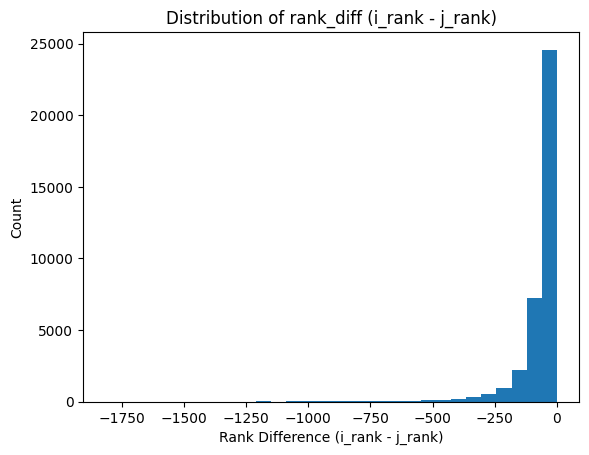

In [28]:

# Filter out rows where either i_rank or j_rank equals the imputed value 9999
filtered_df = tennis_df_rank[
    (tennis_df_rank['i_rank'] != 9999) &
    (tennis_df_rank['j_rank'] != 9999)
].copy()

# Summary
print("ummary of Rank Difference (i_rank - j_rank) - 9999 Excluded")
print(filtered_df["rank_diff"].describe().to_markdown(numalign="left", stralign="left"))

# Histogram

vals_filtered = filtered_df["rank_diff"].dropna().to_numpy()

plt.hist(vals_filtered, bins=30)
plt.title("Distribution of rank_diff (i_rank - j_rank)")
plt.xlabel("Rank Difference (i_rank - j_rank)")
plt.ylabel("Count")

plt.show()


# Metric functions


In [29]:
def calculate_accuracy(pi_i: np.ndarray, y_test: np.ndarray, threshold: float = 0.5) -> float:
    """
    Calculates the classification accuracy based on a specified probability threshold.

    Parameters
    ----------
    pi_i : np.ndarray
        Predicted probabilities that Player i wins (P(i_won = 1)).
    y_test : np.ndarray
        Actual outcomes (1 if Player i won, 0 otherwise).
    threshold : float, default=0.5
        The probability threshold for classification (P(i_won) >= threshold is classified as 1).

    Returns
    -------
    float
        The classification accuracy.
    """
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = (pi_i >= threshold).astype(int)

    # Calculate accuracy: (Correct predictions) / (Total predictions)
    accuracy = (y_pred_binary == y_test).mean()

    return accuracy


In [30]:
def calculate_calibration(pi_i: np.ndarray, y_test: np.ndarray) -> float:
    """
    Calculates the Calibration Score (C) for the predicted probabilities.
    C = (Sum of predicted probabilities) / (Total number of actual wins)

    Parameters
    ----------
    pi_i : np.ndarray
        Predicted probabilities that Player i wins (P(i_won = 1)).
    y_test : np.ndarray
        Actual outcomes (1 if Player i won, 0 otherwise).

    Returns
    -------
    float
        The Calibration Score C. Returns NaN if the total number of actual wins is zero.
    """
    # Sum of actual wins
    W = y_test.sum()

    # Sum of predicted probabilities
    sum_pi_i = pi_i.sum()

    # Calculate Calibration C, with a guardrail for division by zero
    if W == 0:
        calibration_c = np.nan
    else:
        calibration_c = sum_pi_i / W

    return calibration_c


In [31]:
def generate_metric_report(
    df_test: pd.DataFrame,
    pi_i: np.ndarray,
    y_test: np.ndarray,
    threshold: float = 0.5
) -> pd.DataFrame:
    """
    Generates a comprehensive report of key metrics (Accuracy, Calibration, Log-loss)
    for the overall test set and various sub-groups.

    Parameters
    ----------
    df_test : pd.DataFrame
        The test set DataFrame containing columns for group splitting (e.g., 'i_rank', 'tourney_level',
        'surface', 'best_of'). Must have the same index/order as pi_i and y_test.
    pi_i : np.ndarray
        Predicted probabilities that Player i wins (P(i_won = 1)).
    y_test : np.ndarray
        Actual outcomes (1 if Player i won, 0 otherwise).
    threshold : float, default=0.5
        The probability threshold used for Accuracy calculation.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the calculated metrics for each group.
    """

    # Ensure inputs are aligned
    df_results = df_test.copy()
    df_results['pi_i'] = pi_i
    df_results['y_test'] = y_test


    if 'i_rank' in df_results.columns:
        max_rank = df_results['i_rank'].max() if not df_results['i_rank'].empty else 10000.0
        # Bins: (0, 30], (30, 100], (100, max_rank + 1]
        bins = [0, 30, 100, max_rank + 1]
        labels = ['Top 30 (Very Elite)', '31-100 (Strong)', f'> 100 (Challenger/Qualifiers, up to rank {max_rank:.0f})']

        # Apply cut to the Player i's rank
        df_results['rank_group'] = pd.cut(
            df_results['i_rank'],
            bins=bins,
            labels=labels,
            right=True,
            include_lowest=True,
            # If the rank is outside the bins, it will be NaN.
        )
    else:
        # Fallback if 'i_rank' is missing, assign a placeholder group to avoid errors
        df_results['rank_group'] = 'Rank_Col_Missing'
        print("Warning: 'i_rank' column not found for creating rank_group. Check input DataFrame.")


    # Define groups for reporting
    group_columns = [
        'rank_group',
        'tourney_level',
        'surface',
        'best_of'
    ]

    # ---------------------------------
    # Helper for calculating metrics on a single subset
    # ---------------------------------
    def calculate_metrics_for_subset(subset: pd.DataFrame) -> dict:
        p = subset['pi_i'].to_numpy()
        y = subset['y_test'].to_numpy()

        # Guardrail for empty subset
        if len(p) == 0:
             return {
                'count': 0,
                'accuracy': np.nan,
                'calibration_c': np.nan,
                'log_loss': np.nan
            }

        return {
            'count': len(p),
            'accuracy': calculate_accuracy(p, y, threshold=threshold),
            'calibration_c': calculate_calibration(p, y),
            'log_loss': log_loss(y, p, labels=[0, 1])
        }

    # ---------------------------------
    # A. Overall Metrics
    # ---------------------------------
    overall_metrics = calculate_metrics_for_subset(df_results)
    overall_metrics['group_type'] = 'Overall'
    overall_metrics['group_name'] = 'Total'

    report_rows = [overall_metrics]

    # ---------------------------------
    # B. Grouped Metrics
    # ---------------------------------
    for group_col in group_columns:
        if group_col != 'rank_group' and group_col not in df_results.columns:
            print(f"Warning: Column '{group_col}' not found in df_test. Skipping group.")
            continue

        grouped = df_results.groupby(group_col, observed=True)

        for name, group_data in grouped:
            if name == 'Rank_Col_Missing':
                continue

            metrics = calculate_metrics_for_subset(group_data)
            metrics['group_type'] = group_col
            metrics['group_name'] = name
            report_rows.append(metrics)

    # ---------------------------------
    # C. Final Formatting
    # ---------------------------------
    report_df = pd.DataFrame(report_rows)

    # Reorder columns and format output
    report_df = report_df[['group_type', 'group_name', 'count', 'accuracy', 'calibration_c', 'log_loss']]

    # Custom Sorting Logic

    # 1. Define custom order for Group Type (Overall first, then others)
    group_type_order = ['Overall', 'rank_group', 'tourney_level', 'surface', 'best_of']

    # 2. Define custom order for Rank Group Name (By strength, not alphabetical)
    rank_group_name_order = [
        'Top 30 (Very Elite)',
        '31-100 (Strong)',

        f'> 100 (Challenger/Qualifiers up to rank {df_test["i_rank"].max():.0f})'
    ]

    # Apply Group Type order first
    report_df['group_type'] = pd.Categorical(
        report_df['group_type'],
        categories=group_type_order,
        ordered=True
    )

    # Create a temporary sorting key for group_name
    sort_keys = []

    for index, row in report_df.iterrows():
        if row['group_type'] == 'rank_group':
            # Use the custom rank order
            try:
                # Find the index of the name in the custom order list
                sort_key = rank_group_name_order.index(row['group_name'])
            except ValueError:
                # If name is not found, treat it as low priority (e.g., the large imputed label)
                sort_key = len(rank_group_name_order)

        elif row['group_type'] in ['tourney_level', 'surface', 'best_of']:
            # Use count for sorting (negative count for descending order)
            sort_key = -row['count']

        else: # 'Overall'
            sort_key = -1 # Keep overall always at the top of its group_type

        sort_keys.append(sort_key)

    report_df['sort_key'] = sort_keys

    # Final Sorting: Group Type (custom order) -> Custom sort_key (strength or count)
    report_df = report_df.sort_values(
        by=['group_type', 'sort_key'],
        ignore_index=True
    ).drop(columns=['sort_key'])

    # Convert group_type back to string for final output
    report_df['group_type'] = report_df['group_type'].astype(str)

    return report_df


# Baseline Models preparation

In [32]:
# Chronological split on the i/j dataframe
mask_train = tennis_df_rank["year"].between(1998, 2018)
mask_test  = (tennis_df_rank["year"] == 2019)

tennis_train_df = tennis_df_rank.loc[mask_train].copy()
tennis_test_df  = tennis_df_rank.loc[mask_test].copy()

In [33]:
all_exploratory_data_analysis(tennis_train_df)

EXPLORATORY DATA ANALYSIS (EDA) SUMMARY
Total Matches Analyzed: 33,969

1. Target Variable (Player i Win) Analysis:
|                        | Count   | Proportion (%)   |
|:-----------------------|:--------|:-----------------|
| Player i Win (i_won=1) | 22536   | 66.34            |
| Player j Win (i_won=0) | 11433   | 33.66            |
-----------------------------------

2. Tournament Level Distribution:
| tourney_level   | Count   | Proportion (%)   |
|:----------------|:--------|:-----------------|
| A               | 20345   | 59.89            |
| M               | 7029    | 20.69            |
| G               | 6357    | 18.71            |
| F               | 238     | 0.7              |
-----------------------------------

3. Surface Distribution:
| surface   | Count   | Proportion (%)   |
|:----------|:--------|:-----------------|
| Hard      | 18607   | 54.78            |
| Clay      | 11140   | 32.79            |
| Grass     | 3823    | 11.25            |
| Carpet    | 399 

In [34]:
all_exploratory_data_analysis(tennis_test_df)

EXPLORATORY DATA ANALYSIS (EDA) SUMMARY
Total Matches Analyzed: 2,606

1. Target Variable (Player i Win) Analysis:
|                        | Count   | Proportion (%)   |
|:-----------------------|:--------|:-----------------|
| Player i Win (i_won=1) | 1599    | 61.36            |
| Player j Win (i_won=0) | 1007    | 38.64            |
-----------------------------------

2. Tournament Level Distribution:
| tourney_level   | Count   | Proportion (%)   |
|:----------------|:--------|:-----------------|
| A               | 1515    | 58.14            |
| M               | 555     | 21.3             |
| G               | 506     | 19.42            |
| F               | 30      | 1.15             |
-----------------------------------

3. Surface Distribution:
| surface   | Count   | Proportion (%)   |
|:----------|:--------|:-----------------|
| Hard      | 1509    | 57.9             |
| Clay      | 775     | 29.74            |
| Grass     | 322     | 12.36            |
-------------------

In [35]:
# Base Model Feature Selection and Training

# 1. Select base features: Rank Difference, Height, and Age.
X_train_base = tennis_train_df[["rank_diff", "i_ht", "j_ht", "i_age", "j_age"]]
X_test_base  = tennis_test_df[["rank_diff",  "i_ht", "j_ht", "i_age", "j_age"]]

# 2. One-hot encode the handedness features (i_hand, j_hand).
hand_train = pd.get_dummies(tennis_train_df[["i_hand", "j_hand"]], prefix=["i_hand", "j_hand"])
hand_test  = pd.get_dummies(tennis_test_df[["i_hand", "j_hand"]],  prefix=["i_hand", "j_hand"])

# Reindex the test set to ensure column alignment with the training set.
hand_test  = hand_test.reindex(columns=hand_train.columns, fill_value=0)

# 3. Create the final design matrices (X) and target arrays (Y) for training.
# Concatenate base features and one-hot encoded 'hand' features.
X_train = pd.concat([X_train_base, hand_train], axis=1).to_numpy()
y_train_i = tennis_train_df["i_won"].to_numpy()

# 4. Model Training (Logistic Regression).
lr = LogisticRegression(fit_intercept=True, solver="lbfgs", max_iter=1000)
lr.fit(X_train, y_train_i)

# 5. Prepare test arrays for evaluation.
X_test = pd.concat([X_test_base, hand_test], axis=1).to_numpy()
y_test_i = tennis_test_df["i_won"].to_numpy()

In [36]:
# Predict probabilities for Player i winning on the test set.

pi_i_baseline = lr.predict_proba(X_test)[:, 1]


baseline_report_df = generate_metric_report(
    df_test=tennis_test_df,
    pi_i=pi_i_baseline,
    y_test=y_test_i,
    threshold=0.5
)

print("BASELINE MODEL PERFORMANCE REPORT (Logistic Regression)")
print(baseline_report_df.to_markdown(index=False, numalign="left", stralign="left"))


BASELINE MODEL PERFORMANCE REPORT (Logistic Regression)
| group_type    | group_name                                    | count   | accuracy   | calibration_c   | log_loss   |
|:--------------|:----------------------------------------------|:--------|:-----------|:----------------|:-----------|
| Overall       | Total                                         | 2606    | 0.613584   | 1.081           | 0.676836   |
| rank_group    | Top 30 (Very Elite)                           | 1258    | 0.672496   | 0.986243        | 0.633592   |
| rank_group    | 31-100 (Strong)                               | 1245    | 0.55743    | 1.18752         | 0.714516   |
| rank_group    | > 100 (Challenger/Qualifiers, up to rank 314) | 103     | 0.572816   | 1.18687         | 0.749537   |
| tourney_level | A                                             | 1515    | 0.592739   | 1.12306         | 0.694142   |
| tourney_level | M                                             | 555     | 0.601802   | 1.09251        

# Elo


K-Factor Multiplier Justification for Elo Model
This table outlines the dynamic K-factor multipliers applied to the base Elo update formula. The rationale behind these multipliers is to ensure that results from more prestigious and competitive tournaments have a greater impact on a player's rating change. This approach aligns the model's sensitivity with the actual importance of the match on the ATP Tour.
Proposed K-Factor Multiplier Table
| Tournament Tier | Significance Level | K Multiplier | Justification |
|---|---|---|---|
| Grand Slams | Highest | 1.10 | Highest possible multiplier. Reflects the maximum prize money, points (2000), and global prestige. These matches should cause the largest rating adjustments. |
| Tour Finals | Very High | 1.08 | High significance. This event is reserved for the Top 8 players of the year, ensuring elite competition. It is weighted slightly less than Grand Slams but more than Masters 1000s, reflecting its elite, non-mandatory status and 1500 points potential. |
| Masters 1000s | High | 1.05 | Mandatory high-stakes events. These are the third most valuable tournaments in terms of points (1000). The multiplier reflects their mandatory nature and consistent presence of top-ranked players. |
| ATP Tour | Standard | 1.00 | Baseline K-factor. This applies to ATP 500 and ATP 250 level tournaments. These matches utilize the base dynamic K calculation without any additional weight, as they represent the standard weekly competitive level. |
Rationale Summary
The use of tiered K-factor multipliers is critical for the model's accuracy because:
 * Reflecting Real-World Stakes: An unexpected victory at Wimbledon (Grand Slam, Multiplier 1.10) should provide a much larger Elo boost than the same unexpected victory at an ATP 250 event (Multiplier 1.00).
 * Increased Stability for Top Players: By using a higher K-factor for major tournaments, the model can capture significant shifts in player form quickly during critical periods of the year (i.e., the four Grand Slams and the Finals), while maintaining a more stable rating during standard tour play.



In [37]:
TOURNEY_K_MULTIPLIERS = {
    'G': 1.10,          # Grand Slams
    'F': 1.08,          # Tour Finals
    'M': 1.05,          # Masters 1000s
    'A': 1.00           # ATP Tour
}

def calculate_fivethirtyeight_k(
    matches_played: int,
    tournament_tier: str,
    K_base: float = 250.0,
    offset: float = 5.0,
    shape: float = 0.4
) -> float:
    """
    Calculates the FiveThirtyEight-style dynamic K-factor for a player.

    The K-factor is adjusted based on:
    1. The total number of matches played (m(t)).
    2. The importance of the tournament tier (using a multiplier looked up via tourney_level code).

    Args:
        matches_played: The current total number of matches played by the player (m(t)).
        tournament_tier: The tourney_level code ('G', 'F', 'M', or 'A').
        K_base: The constant multiplier K (default is 250.0).
        offset: The small adjustment factor (default is 5.0).
        shape: The exponent shape of the curve (default is 0.4).

    Returns:
        The dynamic K-factor (float) adjusted for the tournament's significance.
    """

    # K-factor base formula: K_base / (matches_played + offset)^shape
    k_base_dynamic = K_base / np.power((matches_played + offset), shape)

    # Determine the tournament multiplier using the agreed-upon dictionary
    # Use a default of 1.00 ('A' level) if the code is not found
    gs_multiplier = TOURNEY_K_MULTIPLIERS.get(tournament_tier, 1.00)

    k_final = k_base_dynamic * gs_multiplier

    return k_final


In [38]:
def calculate_elo_prob(elo_i: float, elo_j: float) -> float:
    """
    Calculates the expected win probability (pi_hat) for player i against player j
    using the standard Elo rating formula.

    Args:
        elo_i: The current Elo rating of player i.
        elo_j: The current Elo rating of player j.

    Returns:
        The probability (float) that player i will win the match (pi_hat_ij).
    """
    # Calculate the Elo difference: E_j - E_i
    elo_diff = elo_j - elo_i

    # Calculate the denominator term: 10^((E_j - E_i) / 400)
    denominator_term = np.power(10, elo_diff / 400)

    # Calculate the expected win probability: 1 / (1 + 10^((E_j - E_i) / 400))
    pi_hat_ij = 1 / (1 + denominator_term)

    return pi_hat_ij

In [39]:
# ---------- helper: prob from Elos ----------
def probs_from_elos(elo_i, elo_j):
    """
    Compute P(i wins) from pre-match Elos of i and j.
    Inputs can be numpy arrays or pandas Series of equal length.
    """
    ei = np.asarray(elo_i, dtype=float)
    ej = np.asarray(elo_j, dtype=float)
    return 1.0 / (1.0 + np.power(10.0, (ej - ei) / 400.0))

In [40]:
# Constants
DEFAULT_INITIAL_ELO = 1500.0


def initialise_player_elos(
    df_match: pd.DataFrame,
    initial_elos_map=None
) -> dict:
    """
    Initializes a dictionary to store the current Elo rating (E_i) and match count
    for every unique player found in the match DataFrame.

    Args:
        df_match: The input DataFrame containing match records.
        initial_elos_map: Dictionary {player_id: starting_elo}.
                          If provided, these values override the default E0.

    Returns:
        A dictionary where keys are player IDs and values are a list:
        {player_id: [current_elo, matches_played]}.
    """

    # 1. Identify all unique player IDs
    player_ids_i = df_match['i_id'].unique()
    player_ids_j = df_match['j_id'].unique()
    all_player_ids = np.unique(np.concatenate((player_ids_i, player_ids_j)))

    # 2. Initialize the state dictionary
    player_elos = {}

    # Use the default value as the fallback
    default_elo = DEFAULT_INITIAL_ELO

    # Use the input dict or an empty dict if None (to handle cold start)
    elos_map = initial_elos_map if initial_elos_map is not None else {}

    for player_id in all_player_ids:
        # Retrieve the starting Elo:
        starting_elo = elos_map.get(player_id, default_elo)

        # Initialize the state: [current_elo (float), matches_played_count (int)]
        player_elos[player_id] = [starting_elo, 0]

    return player_elos

In [41]:
def update_single_match_elo(
    elo_i: float,
    elo_j: float,
    matches_i: int,
    matches_j: int,
    i_won: int,
    tournament_tier: str,
    fixed_k: int = None
) -> tuple[float, float, float, float]:
    """
    Core function to calculate the new Elo ratings and metrics for a single match,
    ready for use in both sequential DataFrame processing and optimization routines.

    Returns:
        (elo_i_new, elo_j_new, i_k, j_k, i_won_prob)
    """

    # 1. Calculate Expected Win Probability
    i_won_prob = probs_from_elos(elo_i, elo_j).item()
    j_won_prob = 1.0 - i_won_prob

    # 2. Determine K-Factor
    if fixed_k is not None:
        i_k, j_k = fixed_k, fixed_k
    else:
        # Dynamic K-factor calculation
        i_k = calculate_fivethirtyeight_k(matches_i, tournament_tier)
        j_k = calculate_fivethirtyeight_k(matches_j, tournament_tier)

    # 3. Update Elo Ratings (E_new = E_old + K * (W - pi_hat))
    i_actual_score = i_won
    j_actual_score = 1 - i_won

    elo_i_new = elo_i + i_k * (i_actual_score - i_won_prob)
    elo_j_new = elo_j + j_k * (j_actual_score - j_won_prob)

    # Return new Elos, K-factor (of i), and Probability (of i)
    return elo_i_new, elo_j_new, i_k, j_k, i_won_prob


In [42]:
def generate_elo_features(
    df_match: pd.DataFrame,
    initial_elos_map: dict = None,
    fixed_k: int = None
) -> pd.DataFrame:
    """
    Sequentially processes match data to calculate and generate all Elo rating
    features based on the current state (E_pre, K-factor, E_won_prob).

    Args:
        df_match: The input match DataFrame (assumed to be sorted by time).
        initial_elos_map: Dictionary {player_id: starting_elo}. If provided,
                          these optimized values are used as E0.
        fixed_k: Optional fixed K-factor to override the dynamic K calculation.

    Returns:
        The input DataFrame with all generated Elo features attached.
    """

    # 1. Initialize Player States
    #    PASSING THE E0 MAP
    player_elos = initialise_player_elos(df_match, initial_elos_map=initial_elos_map)

    # 2. Initialize lists to store features for all rows
    i_elo_pre_list, j_elo_pre_list = [], []
    i_won_prob_list, j_won_prob_list = [], []
    i_k_list, j_k_list = [], []

    # 3. Sequential Iteration and Calculation
    for index, row in df_match.iterrows():
        i_id = row['i_id']
        j_id = row['j_id']

        # Retrieve Current State and Match Count (m(t))
        i_elo_pre, i_matches = player_elos[i_id]
        j_elo_pre, j_matches = player_elos[j_id]

        # Call the core single-match update
        elo_i_new, elo_j_new, i_k, j_k, i_won_prob = update_single_match_elo(
            elo_i=i_elo_pre,
            elo_j=j_elo_pre,
            matches_i=i_matches,
            matches_j=j_matches,
            i_won=row['i_won'],
            tournament_tier=row['tourney_level'],
            fixed_k=fixed_k
        )

        # Update State for the next match
        player_elos[i_id] = [elo_i_new, i_matches + 1]
        player_elos[j_id] = [elo_j_new, j_matches + 1]

        # Store metrics
        i_elo_pre_list.append(i_elo_pre)
        j_elo_pre_list.append(j_elo_pre)
        i_won_prob_list.append(i_won_prob)
        j_won_prob_list.append(1.0 - i_won_prob)
        i_k_list.append(i_k)
        j_k_list.append(j_k)

    # 4. Attach Features to the DataFrame
    df_match['i_elo_pre'] = i_elo_pre_list
    df_match['j_elo_pre'] = j_elo_pre_list
    df_match['i_won_prob'] = i_won_prob_list
    df_match['j_won_prob'] = j_won_prob_list
    df_match['i_k_factor'] = i_k_list
    df_match['j_k_factor'] = j_k_list

    # 5. Create the differential feature
    df_match['elo_diff'] = df_match['i_elo_pre'] - df_match['j_elo_pre']

    return df_match

In [43]:
tennis_df_vanilla_32 = generate_elo_features(
    df_match=tennis_df_rank.copy(),
    fixed_k=32
)


tennis_df_vanilla_32_test_2019 = tennis_df_vanilla_32[
    tennis_df_vanilla_32["year"] == 2019
].copy()


pi_i_vanilla = tennis_df_vanilla_32_test_2019['i_won_prob'].to_numpy()
y_test_vanilla = tennis_df_vanilla_32_test_2019['i_won'].to_numpy()


metric_report_vanilla_32 = generate_metric_report(
    df_test=tennis_df_vanilla_32_test_2019,
    pi_i=pi_i_vanilla,
    y_test=y_test_vanilla,
    threshold=0.5
)


print("\nMetric Report for Vanilla Elo (K=32) - 2019 Test Set:")

print(metric_report_vanilla_32.to_markdown(index=False, numalign="left", stralign="left"))



Metric Report for Vanilla Elo (K=32) - 2019 Test Set:
| group_type    | group_name                                    | count   | accuracy   | calibration_c   | log_loss   |
|:--------------|:----------------------------------------------|:--------|:-----------|:----------------|:-----------|
| Overall       | Total                                         | 2606    | 0.632771   | 1.04688         | 0.634988   |
| rank_group    | Top 30 (Very Elite)                           | 1258    | 0.670111   | 1.06371         | 0.600664   |
| rank_group    | 31-100 (Strong)                               | 1245    | 0.6        | 1.04149         | 0.667904   |
| rank_group    | > 100 (Challenger/Qualifiers, up to rank 314) | 103     | 0.572816   | 0.868876        | 0.656334   |
| tourney_level | A                                             | 1515    | 0.622442   | 1.04093         | 0.653789   |
| tourney_level | M                                             | 555     | 0.609009   | 1.09546         


ELO Trajectory Summary for Top-3 Players (Based on ELO at end of 2019):
--------------------------------------------------
|    |   player_id | player_name    |   matches |   first_idx |   last_idx |   first_elo |   last_elo |
|---:|------------:|:---------------|----------:|------------:|-----------:|------------:|-----------:|
|  0 |      104745 | RAFAEL NADAL   |      1022 |       45091 |      98828 |     1500.00 |    2108.25 |
|  1 |      104925 | NOVAK DJOKOVIC |       977 |       52484 |      98822 |     1500.00 |    2100.02 |
|  2 |      103819 | ROGER FEDERER  |      1082 |       36262 |      98830 |     1500.00 |    2086.36 |


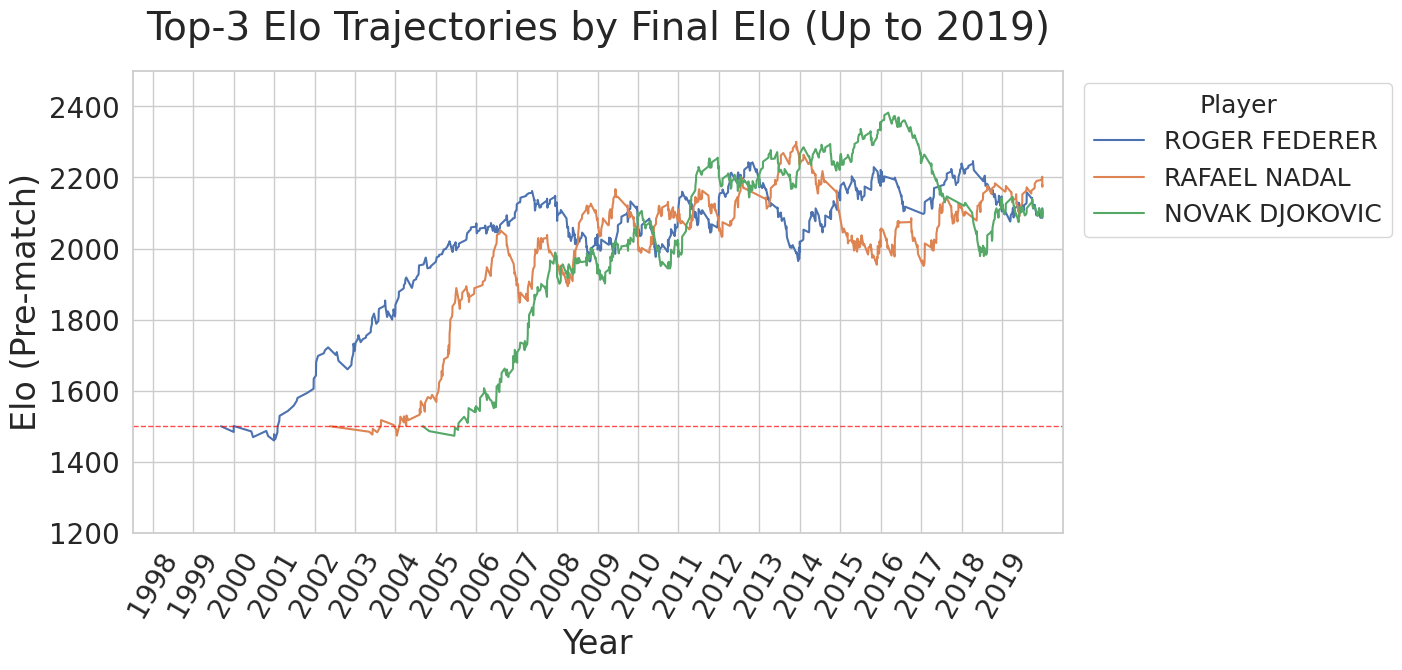

In [44]:
# -------------------------------------------------------------
# ELO TRAJECTORY ANALYSIS (Top-3 Players, Match-by-Match Plot)
# -------------------------------------------------------------

elo_ij_df = tennis_df_vanilla_32.copy()

sns.set_theme(style="whitegrid")

# -------------------------------------------------------------
# 1. Prepare Long-Form Data (Two rows per match)
# -------------------------------------------------------------

long_i = pd.DataFrame({
    "player_id": elo_ij_df["i_id"].to_numpy(),
    "player_name": elo_ij_df["i_name"].to_numpy(),
    "elo_pre": elo_ij_df["i_elo_pre"].to_numpy(),
    "global_time_idx": elo_ij_df["global_time_idx"].to_numpy(),
    "year": elo_ij_df["year"].to_numpy(),
})
long_j = pd.DataFrame({
    "player_id": elo_ij_df["j_id"].to_numpy(),
    "player_name": elo_ij_df["j_name"].to_numpy(),
    "elo_pre": elo_ij_df["j_elo_pre"].to_numpy(),
    "global_time_idx": elo_ij_df["global_time_idx"].to_numpy(),
    "year": elo_ij_df["year"].to_numpy(),
})
long_df = pd.concat([long_i, long_j], ignore_index=True)

# -------------------------------------------------------------
# 2. Identify Top-3 Players by Final ELO (Filter by year <= 2019 first)
# -------------------------------------------------------------

# 2a. Limit the data used for finding Top-3 to the year 2019 and prior
long_filtered_2019 = long_df[long_df["year"] <= 2019].copy()

# 2b. Sort and find the last ELO within the 2019-filtered dataset
long_sorted_2019 = long_filtered_2019.sort_values("global_time_idx")

# Find the index of the last match played for each player within the <= 2019 data
last_idx_2019 = long_sorted_2019.groupby("player_id")["global_time_idx"].idxmax()
last_elo_2019 = long_sorted_2019.loc[last_idx_2019, ["player_id", "elo_pre"]].rename(columns={"elo_pre": "final_elo_pre"})

# Select the IDs of the top 3 players based on their ELO at the end of 2019
top3_ids = last_elo_2019.nlargest(3, "final_elo_pre")["player_id"].tolist()

# ----------------------------
# 3. Create Trajectory Data
# -----------------------------

# Filter the already limited dataset for the Top-3 IDs
top3_trajectory = long_filtered_2019[
    long_filtered_2019["player_id"].isin(top3_ids)
].copy()

# -------------------------------------------------------------
# 4. Create scaled X-axis with equal spacing per year
# -------------------------------------------------------------

# Build per-year bounds using the same filtered data (<= 2019)
year_bounds = (
    long_filtered_2019
    .groupby("year")["global_time_idx"]
    .agg(["min", "max"])
    .rename(columns={"min": "year_start", "max": "year_end"})
)

# Merge bounds into the top-3 trajectory
top3_trajectory = top3_trajectory.merge(
    year_bounds,
    on="year",
    how="left"
)

# Normalised year axis: each calendar year occupies the same width
top3_trajectory["x_year_scaled"] = (
    top3_trajectory["year"]
    + (top3_trajectory["global_time_idx"] - top3_trajectory["year_start"])
      / (top3_trajectory["year_end"] - top3_trajectory["year_start"] + 1)
)

# ---------------------------
# 5. Create Summary Table
# ---------------------------

# Step 5a: Find Index of the absolute first match for each player in the filtered data
first_match_indices = top3_trajectory.groupby("player_id")["global_time_idx"].idxmin()

# Step 5b: Extract the correct first ELO value using the index
first_elo_correct = top3_trajectory.loc[first_match_indices, ["player_id", "elo_pre"]].rename(columns={"elo_pre": "first_elo_correct"})

# Step 5c: Create the main summary table using aggregation for matches, indices, and last ELO
elo_summary_base = (
    top3_trajectory.groupby(["player_id", "player_name"], as_index=False)
        .agg(
            matches=("elo_pre", "count"),
            first_idx=("global_time_idx", "min"),
            last_idx=("global_time_idx", "max"),
            last_elo=("elo_pre", "last"), # last_elo is safe to use 'last' here due to prior sorting/nature of the data
        )
        .sort_values("last_elo", ascending=False)
        .reset_index(drop=True)
)

# Step 5d: Merge the correct first_elo value back into the summary table
elo_summary = elo_summary_base.merge(
    first_elo_correct,
    on="player_id",
    how="left"
).rename(columns={"first_elo_correct": "first_elo"})

# Reorder columns to match the user's expected output format
elo_summary = elo_summary[['player_id', 'player_name', 'matches', 'first_idx', 'last_idx', 'first_elo', 'last_elo']]


print("\nELO Trajectory Summary for Top-3 Players (Based on ELO at end of 2019):")
print("--------------------------------------------------")
print(elo_summary.to_markdown(floatfmt=".2f"))


# ---------
# 6. Plot
# ---------

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=top3_trajectory.sort_values("global_time_idx"),
    x="x_year_scaled",        # scaled year axis
    y="elo_pre",
    hue="player_name",
    marker=None,
    dashes=False,
    errorbar=None
)

plt.xlabel("Year", fontsize=24)
plt.ylabel("Elo (Pre-match)", fontsize=24)
plt.title("Top-3 Elo Trajectories by Final Elo (Up to 2019)", fontsize=28, y=1.05)

# Y-axis: fixed range for all figures + baseline at 1500
plt.ylim(1200, 2500)
plt.axhline(y=1500, linestyle="--", linewidth=1, alpha=0.7, color="red")

# Year ticks: show 1998–2019 with equal spacing
years = np.arange(1998, 2020)
plt.xticks(years, years.astype(str), rotation=60, fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(1997.5, 2020.5)

plt.legend(
    title='Player',
    loc='upper left',
    bbox_to_anchor=(1.01, 1),
    fontsize=18,
    title_fontsize=18
)

plt.grid(True)
plt.show()


ELO Trajectory Summary for Bottom-3 Players (Based on ELO at end of 2019):
--------------------------------------------------
|    |   player_id | player_name       |   matches |   first_idx |   last_idx |   first_elo |   last_elo |
|---:|------------:|:------------------|----------:|------------:|-----------:|------------:|-----------:|
|  0 |      103294 | CHRISTOPHE ROCHUS |       171 |       35373 |      71468 |     1500.00 |    1309.76 |
|  1 |      103835 | FILIPPO VOLANDRI  |       283 |       45147 |      89279 |     1500.00 |    1323.97 |
|  2 |      103821 | DANAI UDOMCHOKE   |        56 |       43511 |      78162 |     1500.00 |    1330.86 |


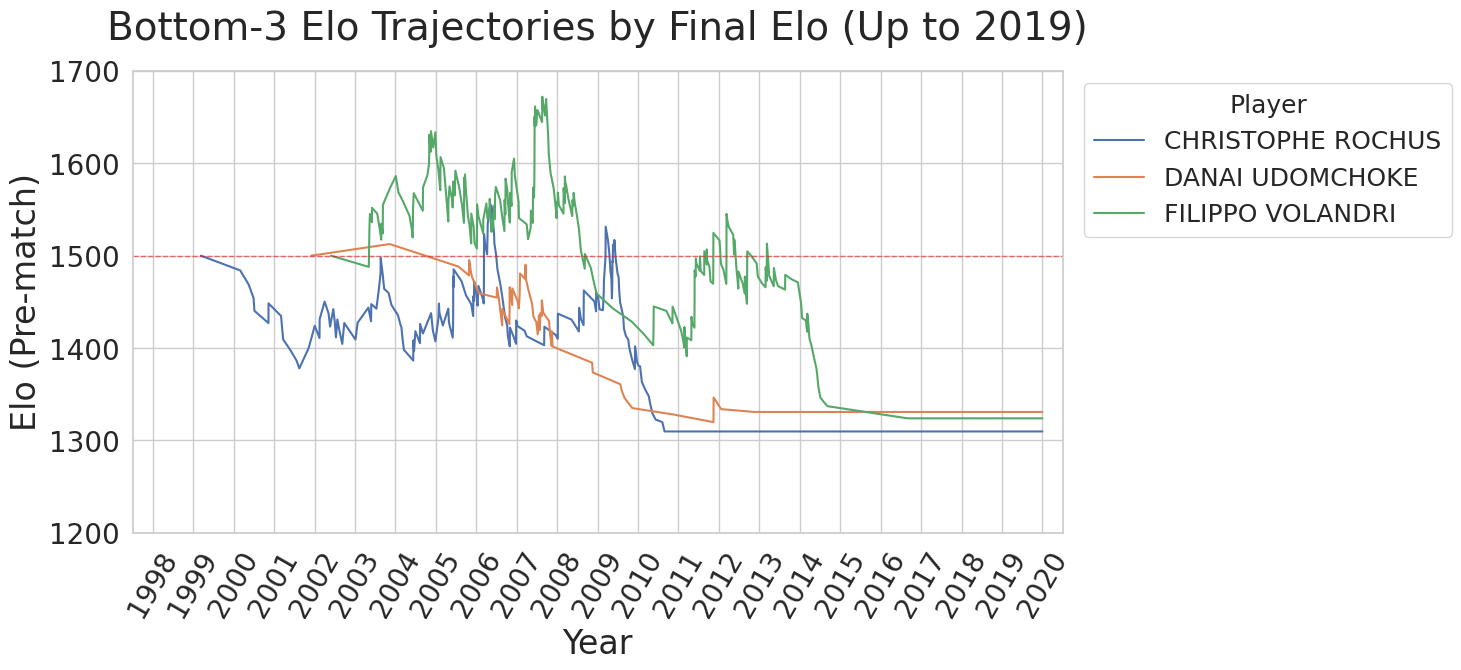

In [45]:
# -------------------------------------------------------------
# ELO TRAJECTORY ANALYSIS (Bottom-3 Players, Match-by-Match Plot)
# -------------------------------------------------------------

sns.set_theme(style="whitegrid")

# -------------------------------------------------------------
# 2. Identify Bottom-3 Players by Final ELO (Filter by year <= 2019 first)
# -------------------------------------------------------------

long_filtered_2019 = long_df[long_df["year"] <= 2019].copy()
long_sorted_2019 = long_filtered_2019.sort_values("global_time_idx")
last_idx_2019 = long_sorted_2019.groupby("player_id")["global_time_idx"].idxmax()
last_elo_2019 = long_sorted_2019.loc[last_idx_2019, ["player_id", "elo_pre"]].rename(columns={"elo_pre": "final_elo_pre"})
bottom3_ids = last_elo_2019.nsmallest(3, "final_elo_pre")["player_id"].tolist()

# -------------------------------------------------------------
# 3. Create Trajectory Data (using the Bottom-3 IDs found in step 2b)
# -------------------------------------------------------------

bottom3_trajectory_original = long_filtered_2019[
    long_filtered_2019["player_id"].isin(bottom3_ids)
].copy()

# -------------------------------------------------------------
# 3.5 Forward Fill ELO Trajectory to Year 2019 End
# -------------------------------------------------------------

max_idx_of_2019 = long_filtered_2019['global_time_idx'].max()
filled_trajectory_list = []
for player_id in bottom3_ids:
    player_data = bottom3_trajectory_original[bottom3_trajectory_original['player_id'] == player_id].copy()

    last_elo = player_data['elo_pre'].iloc[-1]
    last_idx = player_data['global_time_idx'].iloc[-1]

    if last_idx < max_idx_of_2019:
        fill_row = pd.DataFrame({
            "player_id": [player_id],
            "player_name": [player_data['player_name'].iloc[0]],
            "elo_pre": [last_elo],
            "global_time_idx": [max_idx_of_2019],
            "year": [2019]
        })
        player_data = pd.concat([player_data, fill_row], ignore_index=True)

    filled_trajectory_list.append(player_data)

bottom3_trajectory = pd.concat(filled_trajectory_list, ignore_index=True)

# ----------------------------
# 4. Create scaled X-axis
# ----------------------------



bottom3_trajectory = bottom3_trajectory.merge(
    year_bounds,
    on="year",
    how="left"
)

bottom3_trajectory["x_year_scaled"] = (
    bottom3_trajectory["year"]
    + (bottom3_trajectory["global_time_idx"] - bottom3_trajectory["year_start"])
      / (bottom3_trajectory["year_end"] - bottom3_trajectory["year_start"] + 1)
)

# -----------------------------
# 5. Create Summary Table
# -----------------------------
first_match_indices = bottom3_trajectory_original.groupby("player_id")["global_time_idx"].idxmin()
first_elo_correct = bottom3_trajectory_original.loc[first_match_indices, ["player_id", "elo_pre"]].rename(columns={"elo_pre": "first_elo_correct"})
elo_summary_base = (
    bottom3_trajectory_original.groupby(["player_id", "player_name"], as_index=False)
        .agg(
            matches=("elo_pre", "count"),
            first_idx=("global_time_idx", "min"),
            last_idx=("global_time_idx", "max"),
            last_elo=("elo_pre", "last"),
        )
        .sort_values("last_elo", ascending=True)
        .reset_index(drop=True)
)
elo_summary = elo_summary_base.merge(
    first_elo_correct,
    on="player_id",
    how="left"
).rename(columns={"first_elo_correct": "first_elo"})
elo_summary = elo_summary[['player_id', 'player_name', 'matches', 'first_idx', 'last_idx', 'first_elo', 'last_elo']]
print("\nELO Trajectory Summary for Bottom-3 Players (Based on ELO at end of 2019):")
print("--------------------------------------------------")
print(elo_summary.to_markdown(floatfmt=".2f"))

# ---------
# 6. Plot
# ---------

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=bottom3_trajectory.sort_values("global_time_idx"),
    x="x_year_scaled",
    y="elo_pre",
    hue="player_name",
    marker=None,
    dashes=False,
    errorbar=None
)

plt.xlabel("Year", fontsize=24)
plt.ylabel("Elo (Pre-match)", fontsize=24)
plt.title("Bottom-3 Elo Trajectories by Final Elo (Up to 2019)", fontsize=28, y=1.05)

plt.ylim(1200, 1700)
plt.axhline(
    y=1500,
    linestyle="--",
    linewidth=1,
    alpha=0.5,
    color="red"
)


years = np.arange(1998, 2021)
plt.xticks(years, years.astype(str), rotation=60, fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(1997.5, 2020.5)

plt.legend(
    title='Player',
    loc='upper left',
    bbox_to_anchor=(1.01, 1),
    fontsize=18,
    title_fontsize=18
)

plt.grid(True)
plt.show()

# ELO COLD-START SOLVING EXPERIMENT
# (The main process of the project)

In [46]:
# split config
TRAIN_START = 1998
TRAIN_END   = 2017
VALID_YEAR  = 2018
TEST_YEAR   = 2019

core_cols = ["global_time_idx", "year", "i_id", "j_id", "i_won", "tourney_level"]
elo_core_df = tennis_df_rank[core_cols].copy()

# time-based splits
elo_df_train = elo_core_df[(elo_core_df["year"] >= TRAIN_START) & (elo_core_df["year"] <= TRAIN_END)]
elo_df_valid = elo_core_df[elo_core_df["year"] == VALID_YEAR]
elo_df_test  = elo_core_df[elo_core_df["year"] == TEST_YEAR]

In [47]:
def build_train_arrays(df_train: pd.DataFrame,
                       i_col: str = "i_id",
                       j_col: str = "j_id",
                       y_col: str = "i_won",
                       tourney_col: str = "tourney_level",
                       k_value = None) -> dict:
    """
    Build compact TRAIN arrays without reordering rows, and calculate the
    K-Factor Array (K) based on the specified k_value parameter.

    Returns a dict containing:
      - existing keys
      - final_played_counts: dict, the total match count for each player after the last match.
    """

    # Initial Data Extraction
    i_raw = df_train[i_col].to_numpy()
    j_raw = df_train[j_col].to_numpy()
    y     = df_train[y_col].to_numpy(dtype=np.int8)

    tourney_tier_arr = df_train[tourney_col].to_numpy()
    n = len(df_train)

    # Player Mapping Setup
    players_order = pd.Index(i_raw).append(pd.Index(j_raw)).unique().to_numpy()
    p_id_idx = {int(pid): idx for idx, pid in enumerate(players_order)}
    idx_p_id = players_order.copy()
    i_idx = np.fromiter((p_id_idx[int(pid)] for pid in i_raw), dtype=np.int64, count=n)
    j_idx = np.fromiter((p_id_idx[int(pid)] for pid in j_raw), dtype=np.int64, count=n)

    # K-Factor and Prior Match Counts Calculation

    # K_arr will store the final K-factor for all M matches
    K_arr = np.empty(n, dtype=float)
    n_i_prior = np.empty(n, dtype=np.int32)
    n_j_prior = np.empty(n, dtype=np.int32)

    # Dictionary to track matches played so far (used for n_prior and final output)
    played = {int(pid): 0 for pid in players_order} # This holds the match count BEFORE the current match

    # 1. Option: Constant K
    if k_value is not None:
        K_arr = np.full(n, float(k_value), dtype=float)

        # Populate n_i_prior and n_j_prior regardless of K type for output consistency
        for m in range(n):
            pid_i = int(i_raw[m])
            pid_j = int(j_raw[m])

            n_i_prior[m] = played[pid_i]
            n_j_prior[m] = played[pid_j]

            played[pid_i] += 1
            played[pid_j] += 1

    # 2. Option: Dynamic FiveThirtyEight K is requested (k_value=None)
    else:
        # Loop over matches to calculate K_538 and n_prior concurrently
        for m in range(n):
            pid_i = int(i_raw[m])
            pid_j = int(j_raw[m])
            tier = tourney_tier_arr[m]

            # Prior match counts BEFORE this match (n_prior)
            n_i_prior[m] = played[pid_i]
            n_j_prior[m] = played[pid_j]

            # Calculate Dynamic K-Factor for both players
            k_i = calculate_fivethirtyeight_k(n_i_prior[m], tier)
            k_j = calculate_fivethirtyeight_k(n_j_prior[m], tier)

            # K[m] = Max of the two K-factors (to bias updates towards newer players)
            K_arr[m] = np.max([k_i, k_j])

            # Increment matches played AFTER the match
            played[pid_i] += 1
            played[pid_j] += 1



    return {
        "p_id_idx": p_id_idx,
        "idx_p_id": idx_p_id,
        "i_idx": i_idx,
        "j_idx": j_idx,
        "y": y,
        "K": K_arr,
        "n_i_prior": n_i_prior,
        "n_j_prior": n_j_prior,
        "N": len(players_order),
        "M": n,
        "final_played_counts": played
    }


In [48]:
# ---------- constants ----------
C_ELO = np.log(10.0) / 400.0  # c = ln(10)/400

# ---------- helper: prob from Elos ----------
def probs_from_elos(elo_i, elo_j):
    """
    Compute P(i wins) from pre-match Elos of i and j.
    Inputs can be numpy arrays or pandas Series of equal length.
    """
    ei = np.asarray(elo_i, dtype=float)
    ej = np.asarray(elo_j, dtype=float)
    return 1.0 / (1.0 + np.power(10.0, (ej - ei) / 400.0))

# ---------- helper: Bernoulli log-likelihood ----------

def log_likelihood(y, p, eps=1e-15):
    """
    Bernoulli log-likelihood: sum_t [ y_t * log(p_t) + (1 - y_t) * log(1 - p_t) ].
    Clips probabilities by eps for numerical stability.
    """
    y = np.asarray(y, dtype=float)
    p = np.asarray(p, dtype=float)
    p = np.clip(p, eps, 1.0 - eps)
    return float(np.sum(y * np.log(p) + (1.0 - y) * np.log(1.0 - p)))

In [49]:
# **************** CORE CODE *******************

# ---------- forward + analytic gradient wrt E0 (s_{u,t}) ----------
def negloglik_and_grad_E0(E0_vec, elo_train_arrays, eps=1e-15):
    """
    Compute negative log-likelihood on TRAIN and analytic gradient wrt E0.
    Returns: negloglik (scalar), grad_neg_E0 (vector)
    """
    i_idx = elo_train_arrays["i_idx"]
    j_idx = elo_train_arrays["j_idx"]
    y     = elo_train_arrays["y"].astype(float)
    K     = elo_train_arrays["K"]
    N     = int(elo_train_arrays["N"])
    M     = int(elo_train_arrays["M"])

    E = np.array(E0_vec, dtype=float, copy=True)     # current Elos
    s = np.ones(N, dtype=float)                      # s_{u,t} for all players

    grad_E0 = np.zeros(N, dtype=float)               # d( loglik ) / d E0
    loglik  = 0.0

    for m in range(M):
        i = int(i_idx[m]); j = int(j_idx[m])
        Ei = E[i]; Ej = E[j]

        # Use helper for consistency: P(i wins)
        pi = probs_from_elos(Ei, Ej) # pi = 1.0 / (1.0 + 10.0 ** ((Ej - Ei) / 400.0))

        # accumulate log-likelihood
        p_clip = np.clip(pi, eps, 1.0 - eps)
        loglik += y[m] * np.log(p_clip) + (1.0 - y[m]) * np.log(1.0 - p_clip)

        # residual and gradient contribution
        r = y[m] - pi
        grad_E0[i] += r * C_ELO * s[i]
        grad_E0[j] -= r * C_ELO * s[j]

        # Elo update
        delta = K[m] * r
        E[i] = Ei + delta
        E[j] = Ej - delta

        # sensitivity recursion for the two players
        mult = (1.0 - K[m] * C_ELO * pi * (1.0 - pi))
        s[i] *= mult
        s[j] *= mult

    negloglik     = -float(loglik)
    grad_neg_E0   = -grad_E0

    return negloglik, grad_neg_E0

In [50]:
# ************** CORE CODE ***************

# objective and gradient in z (L2 regularised)
def objective_and_grad_z(z_vec, elo_train_arrays, center=1500.0, lambda_l2=0.0):
    """
    return (negloglik_PML, grad_neg_z).
    """


    E0_vec = anchored_E0_from_z(z_vec, center=center)

    # return the unregularised objective and gradient (MLE)
    negloglik_mle, grad_neg_E0_mle = negloglik_and_grad_E0(E0_vec, elo_train_arrays)



    # --- L2 Regularisation (MAP Penalty) ---

    # L2 Regularisation Value
    # Penalty Term R = lambda_l2 * sum( (E0 - center)^2 )
    E0_diff = E0_vec - center
    l2_penalty_val = lambda_l2 * np.sum(E0_diff**2)



    # Penalised Negative Log-Likelihood
    negloglik_pml = negloglik_mle + l2_penalty_val

    # L2 Regularization Gradient
    # Gradient of Penalty dR/dE0 = 2 * lambda_l2 * (E0 - center)
    grad_E0_l2 = 2.0 * lambda_l2 * E0_diff

    # Total Gradient w.r.t E0 (Analytic MLE Gradient + L2 Penalty Gradient)
    grad_neg_E0_pml = grad_neg_E0_mle + grad_E0_l2



    # --- Final Transformation (Chain Rule for z) ---

    # d(NegLogLik_PML)/dz = d(NegLogLik_PML)/dE0 - mean(d(NegLogLik_PML)/dE0)
    g = grad_neg_E0_pml - np.mean(grad_neg_E0_pml)

    return negloglik_pml, g # Returns penalized value and gradient

In [51]:
# ---------- re-param: mean(E0) = 1500 via z ----------
def anchored_E0_from_z(z_vector, center=1500.0):
    """
    Transforms the unconstrained vector 'z' back into E0, ensuring the mean
    of E0 remains exactly equal to center (1500.0).
    """
    z_centered = np.asarray(z_vector, dtype=float)
    # E0 = center + (z - mean(z))
    return center + (z_centered - z_centered.mean())


## ---------- joint fit with mean(E0)=1500 via re-param on z ----------

def fit_E0_joint(elo_train_arrays,
                 E0_init_vec=None,
                 lambda_l2=0.0,
                 center=1500.0,
                 max_iter=500,
                 tol=1e-5,
                 verbose=False,
                 print_every=1):

    # N is the total number of players
    N = int(elo_train_arrays["N"])

    # Initialization and z0 setup
    if E0_init_vec is None:
        # Start at 'center', which means z0 = 0
        z0 = np.zeros(N, dtype=float)
    else:
        # If an initial E0 is provided, convert it to the initial z vector
        E0_init = np.asarray(E0_init_vec, dtype=float)
        if len(E0_init) != N:
            raise ValueError(f"Length of E0_init_vec ({len(E0_init)}) != N ({N}).")
        # z = E0 - mean(E0). This ensures the constraint is maintained from the start.
        z0 = E0_init - E0_init.mean()

    negloglik_history = []
    negloglik_trace   = []

    start = time.perf_counter()
    last_val = None
    iter_idx = 0

    # Callback function for logging/tracing
    def _callback(z_current):
        # We call the full objective function to get the current penalized negative log-likelihood (val)
        val, _ = objective_and_grad_z(
            z_current,
            elo_train_arrays,
            center=center,
            lambda_l2=lambda_l2
        )

        nonlocal iter_idx, last_val

        negloglik_history.append(float(val))
        elapsed = time.perf_counter() - start
        negloglik_trace.append((iter_idx, float(val), float(elapsed)))

        if verbose and (iter_idx % int(print_every) == 0):
            if last_val is None:
                delta = float('nan')
            else:
                delta = float(val - last_val)

            print(f"[iter {iter_idx:4d}] negloglik = {val:,.3f}   delta = {delta:+.3f}   elapsed = {elapsed:,.2f}s")
        last_val = val
        iter_idx += 1


    # Execution of the Optimizer

    optimization_result = minimize(

        fun=lambda z: objective_and_grad_z(z, elo_train_arrays, center=center, lambda_l2=lambda_l2),
        x0=z0,
        method="L-BFGS-B",
        jac=True,
        options={"maxiter": int(max_iter), "ftol": float(tol)},
        callback=_callback
    )

    # Final Output and Conversion
    z_opt  = np.asarray(optimization_result.x, dtype=float)

    E0_opt = anchored_E0_from_z(z_opt, center=center)


    return {
        "E0_opt": E0_opt,
        "negloglik_final": float(optimization_result.fun),
        "success": bool(optimization_result.success),
        "message": str(optimization_result.message),
        "nfev": int(optimization_result.nfev),
        "nit": int(getattr(optimization_result, "nit", -1)),
    }

In [52]:
# HELPER TO CALCULATE SIGMA
# NOTE: the funciton works with train array, not the dataframe


def elo_forward_pass(E0_vec, elo_arrays, K_val=None, step_size=500):
    """
    Runs a sequential Elo update pass (forward pass) over a set of matches.
    This version ALWAYS returns the full history DataFrame for plotting,
    saving the full Elo vector E at intervals defined by step_size.
    """
    i_idx = elo_arrays["i_idx"]
    j_idx = elo_arrays["j_idx"]
    y     = elo_arrays["y"].astype(float)
    N     = int(elo_arrays["N"])
    M     = int(elo_arrays["M"])

    E = np.array(E0_vec, dtype=float, copy=True) # current Elos (copied for update)

    if K_val is not None:
        K = np.full(M, float(K_val), dtype=float)
    else:
        K = elo_arrays["K"]

    pi_vec = np.empty(M, dtype=float) # stores P(i wins) for all matches

    # History Collection Setup
    history_steps = [0]
    history_E = [E.copy()]


    for m in range(M):
        i = int(i_idx[m]); j = int(j_idx[m])
        Ei = E[i]; Ej = E[j]

        # Calculate probability P(i wins) using external helper
        pi = probs_from_elos(Ei, Ej)
        pi_vec[m] = pi

        pi_vec[m] = pi

        # Residual
        r = y[m] - pi

        # Elo update (symmetric)
        delta = K[m] * r
        E[i] = Ei + delta
        E[j] = Ej - delta

        # History Collection Logic
        if (m + 1) % step_size == 0:
            history_steps.append(m + 1)
            history_E.append(E.copy())


    # Record the final state
    if history_steps[-1] != M:
        history_steps.append(M)
        history_E.append(E.copy())

    # Convert history to DataFrame
    df_history = pd.DataFrame(history_E, index=history_steps)
    df_history.index.name = "match_index"
    df_history.columns.name = "player_idx"

    return {
        "E_final_vec": E,
        "pi_vec": pi_vec,
        "y_vec": y,
        "elo_history_df": df_history
    }


def score_on_arrays(y, pi):
    """
    Calculates the Log-Likelihood and returns a dict of scores.
    Uses the external helper 'log_likelihood'.
    """
    ll = log_likelihood(y, pi)
    M = len(y)

    # Calculate simple accuracy (not used for optimisation, but helpful for validation)
    pi_clipped = np.clip(pi, 1e-15, 1.0 - 1e-15)
    accuracy = float(np.mean(y == np.round(pi_clipped)))

    return {
        "log_likelihood": float(ll),
        "mean_log_likelihood": float(ll / M),
        "accuracy": accuracy,
        "n_matches": M
    }


In [53]:
# --- Helper to Prepare Validation Data ---

def build_valid_arrays(
    elo_df: pd.DataFrame,
    train_arrays: dict,
    initial_played_counts: dict,
    i_col: str = "i_id",
    j_col: str = "j_id",
    y_col: str = "i_won",
    tourney_col: str = "tourney_level",
    fixed_k: float = None
) -> dict:
    """
    Vectorize the validation set, drop players not seen in training,
    and calculate the Dynamic K-Factor array for the validation matches.

    Args:
        initial_played_counts (dict): Final match counts from the TRAIN set.
    """
    pid_to_idx = train_arrays["p_id_idx"]
    N_train = int(train_arrays["N"])

    df_valid = elo_df.copy()

    # Map player IDs
    df_valid["i_idx"] = df_valid[i_col].map(pid_to_idx)
    df_valid["j_idx"] = df_valid[j_col].map(pid_to_idx)
    df_valid.dropna(subset=["i_idx", "j_idx"], inplace=True)

    i_raw = df_valid[i_col].to_numpy()
    j_raw = df_valid[j_col].to_numpy()
    tourney_tier_arr = df_valid[tourney_col].to_numpy()
    M = len(df_valid)

    i_idx = df_valid["i_idx"].astype(int).values
    j_idx = df_valid["j_idx"].astype(int).values

    # --- K-Factor Logic ---
    K_arr = np.empty(M, dtype=float)
    played = initial_played_counts.copy()


    if fixed_k is not None:

        K_arr = np.full(M, float(fixed_k), dtype=float)


        for m in range(M):
            pid_i = int(i_raw[m])
            pid_j = int(j_raw[m])
            played[pid_i] = played.get(pid_i, 0) + 1
            played[pid_j] = played.get(pid_j, 0) + 1

    else:

        for m in range(M):
            pid_i = int(i_raw[m])
            pid_j = int(j_raw[m])
            tier = tourney_tier_arr[m]

            n_i_prior = played.get(pid_i, 0)
            n_j_prior = played.get(pid_j, 0)

            k_i = calculate_fivethirtyeight_k(n_i_prior, tier)
            k_j = calculate_fivethirtyeight_k(n_j_prior, tier)

            K_arr[m] = np.max([k_i, k_j])

            played[pid_i] = played.get(pid_i, 0) + 1
            played[pid_j] = played.get(pid_j, 0) + 1

    return {
        "i_idx": i_idx,
        "j_idx": j_idx,
        "y": df_valid[y_col].values.astype(float),
        "K": K_arr,
        "M": M,
        "N": N_train,
    }


In [54]:
def plot_elo_trajectories(df_history, title=None):
    """
    Plot Elo trajectories for all players over training matches
    plus the final cross-sectional Elo distribution.

    Parameters
    ----------
    df_history : pd.DataFrame
        Wide DataFrame of Elo histories.
        Index: training match index t = 1,...,T
        Columns: player indices u = 1,...,N
    title : str, optional
        Title for the left panel. If None, a default is used.
    """
    N = df_history.shape[1]              # number of players (u = 1,...,N)
    T = int(df_history.index.max())      # number of training matches (t = 1,...,T)
    final_elos = df_history.iloc[-1].values

    if title is None:
        title = "Elo Rating Trajectories (Training Set)"

    # --- figure + gridspec ---
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0.05)

    # ======================================================================
    # Left panel: trajectories over training match index t
    # ======================================================================
    ax_time = fig.add_subplot(gs[0, 0])

    # wide -> long
    df_long = df_history.stack().reset_index(name="elo")
    df_long.rename(
        columns={"level_0": "t", "level_1": "player_idx"},
        inplace=True
    )

    if "match_index" in df_long.columns:
        df_long.rename(columns={"match_index": "t"}, inplace=True)

    sns.lineplot(
        data=df_long,
        x="t",                 # training match index t = 1,...,T
        y="elo",
        units="player_idx",
        estimator=None,
        alpha=0.8,
        lw=0.3,
        color="#707070",
        ax=ax_time,
    )


    mean_elo = df_history.mean(axis=1)
    std_elo  = df_history.std(axis=1)

    ax_time.plot(
        mean_elo.index,
        mean_elo.values,
        color="#ef4444",
        linewidth=2.0,
        label="Mean Elo",
    )
    ax_time.fill_between(
        mean_elo.index,
        mean_elo - std_elo,
        mean_elo + std_elo,
        color="#ef4444",
        alpha=0.35,
        label=r"$\pm 1$ s.d.",
    )

    ax_time.set_title(title, fontsize=22, pad=18)
    ax_time.set_xlabel(r"Training match index $t$", fontsize=20)
    ax_time.set_ylabel("Elo rating", fontsize=20)
    ax_time.set_xlim(df_history.index.min(), T)
    ax_time.grid(axis="y", linestyle="--", alpha=0.6)

    ax_time.tick_params(axis="both", which="major", labelsize=16)
    ax_time.legend(loc="lower right", fontsize=16)

    # ======================================================================
    # Right panel: final cross-sectional distribution of Elo
    # ======================================================================
    ax_dist = fig.add_subplot(gs[0, 1], sharey=ax_time)

    std_final = np.std(final_elos, ddof=0)

    sns.kdeplot(
        y=final_elos,
        ax=ax_dist,
        fill=True,
        color="#707070",
        linewidth=1.2,
        alpha=0.9,
        label=f"Final Elo (std = {std_final:.1f})",
    )

    ax_dist.set_title("Final Elo distribution\n(end of training window)",
                      fontsize=16, pad=15)
    ax_dist.set_xlabel("Density", fontsize=16)
    ax_dist.set_ylabel("")
    ax_dist.set_xticks([])
    ax_dist.tick_params(axis="y", labelleft=False, labelright=True, labelsize=16)
    ax_dist.legend(loc="upper right", fontsize=16)


    plt.suptitle(
        f"Total players $N={N:,}$, training matches $T={T:,}$",
        fontsize=14,
        y=0.98,
        color="gray",
    )

    sns.despine(ax=ax_dist, left=True, right=False)

    plt.show()

In [55]:
print("Data Preparation (Using Fixed K=32)")


elo_train_arrays = build_train_arrays(
    elo_df_train,
    i_col="i_id",
    j_col="j_id",
    y_col="i_won",
    k_value=32.0
)


M = elo_train_arrays["M"]
N = elo_train_arrays["N"]

final_train_played_counts = elo_train_arrays["final_played_counts"]

print(f"Total Matches (M): {M:,}")
print(f"Total Players (N): {N:,}")


Data Preparation (Using Fixed K=32)
Total Matches (M): 31,325
Total Players (N): 793


In [56]:
print("Heuristic Sigma Calculation (Baseline E0=1500)")

E0_init_1500 = np.full(N, 1500.0, dtype=float)

# Run the forward pass on the train data
results_baseline = elo_forward_pass(E0_init_1500, elo_train_arrays)

# Extract the final Elo vector (for sigma calculation)
E_final_baseline = results_baseline["E_final_vec"]

# Extract the history DataFrame (for the trajectory plot)
elo_history_baseline = results_baseline["elo_history_df"]

# Calculate the standard deviation (sigma) of the final ratings
sigma_init = np.std(E_final_baseline, ddof=0) # Use ddof=0 for population standard deviation

# Calculate the corresponding lambda_l2 (Regularization strength)
# lambda_l2 = 1 / (2 * sigma^2)
lambda_init = 1.0 / (2.0 * sigma_init**2)

print(f"Final Elo Spread (Std Dev, N={N})  : {sigma_init:.4f}")
print(f"Heuristic Initial Sigma : {sigma_init:.4f}")
print(f"Corresponding Initial Lambda : {lambda_init:.6e}")

Heuristic Sigma Calculation (Baseline E0=1500)
Final Elo Spread (Std Dev, N=793)  : 100.9551
Heuristic Initial Sigma : 100.9551
Corresponding Initial Lambda : 4.905837e-05


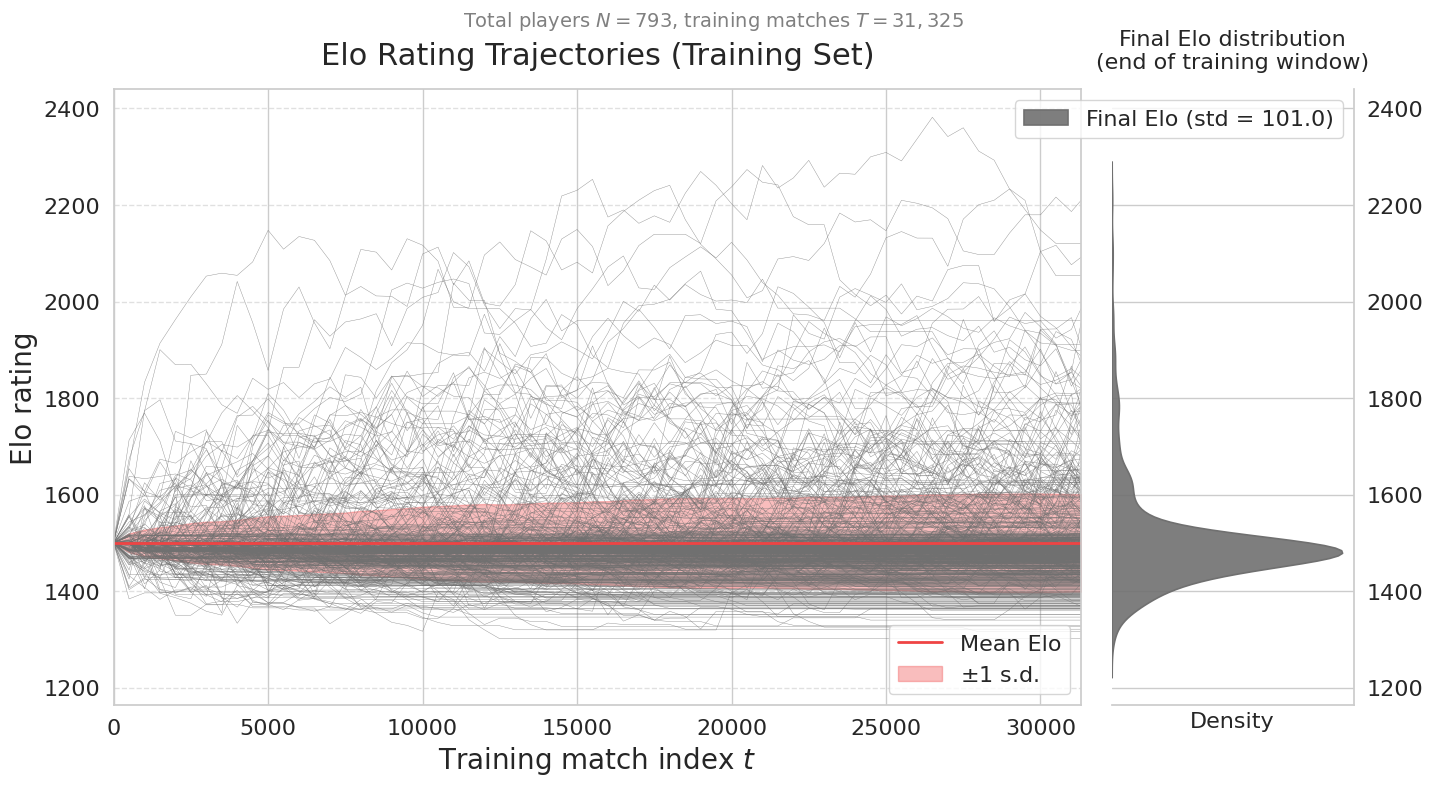

In [57]:
plot_elo_trajectories(elo_history_baseline)

In [58]:
# --- Hyperparameter Tuning ---

print("--- Hyperparameter Tuning ---")

# Prepare Validation Data Structure

elo_valid_arrays = build_valid_arrays(
    elo_df_valid,
    elo_train_arrays,
    initial_played_counts=final_train_played_counts,
    i_col="i_id",
    j_col="j_id",
    y_col="i_won",
    fixed_k=32.0
)


M_valid = int(elo_valid_arrays["M"])
N_total = int(elo_valid_arrays["N"])
print(f"Matches in Validation set (M_valid): {M_valid:,}")
print(f"Total Players (N): {N_total:,} (Matching training N)")


# Define the Search Range for Sigma (Standard Deviation)
sigma_range = np.array([50.0, 75.0, sigma_init, 125.0, 150.0, 200.0, 300.0])


# Initialize storage for results
tuning_results = []
E0_opt_best = None
best_negloglik_valid = float('inf')
best_sigma = None
best_lambda = None


# Run Tuning Loop
print(f"\nStarting Tuning Loop for {len(sigma_range)} Sigma values")
print("-------------------------------------------------------------------------------------------------")
print("  k |   Sigma (σ) | Lambda (λ) | NegLogLik (Train) | NegLogLik (Valid) | Time (s) ")
print("-------------------------------------------------------------------------------------------------")

start_time_total = time.perf_counter()

for k, sigma_val in enumerate(sigma_range):
    start_time_k = time.perf_counter()

    # Convert the user-defined Sigma to the required Lambda_L2 for the optimizer
    # Lambda_L2 = 1 / (2 * sigma^2)
    lambda_val = 1.0 / (2.0 * sigma_val**2)

    # Train: Optimize E0 on TRAIN data using the current lambda_val
    res_fit = fit_E0_joint(
        elo_train_arrays,
        lambda_l2=lambda_val,
        E0_init_vec=None,
        max_iter=500,
        tol=1e-5,
        verbose=False,
        print_every=1
    )

    E0_opt = np.asarray(res_fit["E0_opt"], dtype=float)
    negloglik_train_pml = res_fit["negloglik_final"] # This is the penalized negloglik on train

    # Validate: Run a standard forward pass on the VALIDATION set

    results_valid = elo_forward_pass(
        E0_opt,
        elo_valid_arrays,
        K_val=32.0
    )

    # Score: Calculate the UNPENALIZED Negative Log-Likelihood (MLE) on VALIDATION
    score_metrics = score_on_arrays(
        elo_valid_arrays["y"],
        results_valid["pi_vec"]
    )
    # Extract the scalar 'log_likelihood' value and negate it for NegLogLik
    negloglik_valid_mle = -score_metrics["log_likelihood"]

    time_k = time.perf_counter() - start_time_k

    # Store and Check Best Result
    if negloglik_valid_mle < best_negloglik_valid:
        best_negloglik_valid = negloglik_valid_mle
        E0_opt_best = E0_opt.copy() # Store the best E0 vector
        best_sigma = sigma_val
        best_lambda = lambda_val

    # Print Trace
    print(f"{k:3d} | {sigma_val:12.4f} | {lambda_val:10.6e} | {negloglik_train_pml:17,.3f} | {negloglik_valid_mle:15,.3f} | {time_k:8.2f}")

    tuning_results.append({
        "sigma": sigma_val,
        "lambda_l2": lambda_val,
        "negloglik_train_pml": negloglik_train_pml,
        "negloglik_valid_mle": negloglik_valid_mle,
        "time_s": time_k
    })

time_total = time.perf_counter() - start_time_total


print("-------------------------------------------------------------------------------------------------")
print(f"Tuning Complete in {time_total:.2f} seconds.")
print(f"Optimal Sigma (σ): {best_sigma:.4f}")
print(f"Corresponding Optimal Lambda (λ): {best_lambda:.6e}")
print(f"Best Validation NegLogLik: {best_negloglik_valid:,.3f}")


--- Hyperparameter Tuning ---
Matches in Validation set (M_valid): 2,516
Total Players (N): 793 (Matching training N)

Starting Tuning Loop for 7 Sigma values
-------------------------------------------------------------------------------------------------
  k |   Sigma (σ) | Lambda (λ) | NegLogLik (Train) | NegLogLik (Valid) | Time (s) 
-------------------------------------------------------------------------------------------------
  0 |      50.0000 | 2.000000e-04 |        18,672.444 |       1,636.072 |     4.31
  1 |      75.0000 | 8.888889e-05 |        18,632.226 |       1,628.661 |     3.98
  2 |     100.9551 | 4.905837e-05 |        18,588.600 |       1,623.600 |    10.97
  3 |     125.0000 | 3.200000e-05 |        18,550.339 |       1,621.322 |    15.02
  4 |     150.0000 | 2.222222e-05 |        18,514.347 |       1,620.871 |    12.14
  5 |     200.0000 | 1.250000e-05 |        18,455.187 |       1,624.112 |    12.11
  6 |     300.0000 | 5.555556e-06 |        18,380.153 |       1,

In [59]:
print("--- Final Optimal E0 Analysis (MAP) ---")

print(f"Using Optimal Sigma: {best_sigma:.4f} (Lambda: {best_lambda:.6e})")

print("--------------------------------------------------------------------------")

# Pull optimized initial Elos and indices from the training data structure


E0_opt    = np.asarray(E0_opt_best, dtype=float)                  # shape (N,)
idx_p_id  = np.asarray(elo_train_arrays["idx_p_id"], dtype=int)     # shape (N,)
i_idx     = np.asarray(elo_train_arrays["i_idx"], dtype=int)        # shape (M,)
j_idx     = np.asarray(elo_train_arrays["j_idx"], dtype=int)        # shape (M,)
N         = len(E0_opt)
M         = len(i_idx) # Total matches in TRAIN set


# Build player_id -> name mapping from the full main dataframe

    # Use only the player ID and name columns, dropping duplicates and creating a map
name_i_map = (
        tennis_df_rank[["i_id", "i_name"]]
        .drop_duplicates(subset="i_id")
        .set_index("i_id")["i_name"]
    )

name_j_map = (
        tennis_df_rank[["j_id", "j_name"]]
        .drop_duplicates(subset="j_id")
        .set_index("j_id")["j_name"]
    )

    # Combine the maps, prioritizing name_i if both exist
pid_to_name = name_i_map.combine_first(name_j_map)

# Compute train-match counts per player (in TRAIN only)
train_counts = np.bincount(
    np.concatenate([i_idx, j_idx]),
    minlength=N
)

# Assemble player table
df_players = pd.DataFrame({
    "player_id": idx_p_id,               # index -> original id
    "name": pd.Series(idx_p_id).map(pid_to_name).fillna(""),
    "E0_opt": E0_opt,
    "train_matches": train_counts
})

mean_E0   = float(df_players["E0_opt"].mean())
std_E0    = float(df_players["E0_opt"].std(ddof=0))
min_E0    = float(df_players["E0_opt"].min())
max_E0    = float(df_players["E0_opt"].max())
n_players = int(N)

print("\nOPTIMAL E0 SUMMARY (L2 Regularized MAP)")
print(f"Players in TRAIN        : {n_players:,}")
print(f"Matches in TRAIN        : {M:,}")
print(f"Mean(E0_opt)            : {mean_E0:.6f}   (Target: 1500.0, Diff: {mean_E0-1500.0:+.6f})")

print(f"Std(E0_opt)             : {std_E0:.6f}   (Tuned Sigma Used: {best_sigma:.6f})")
print(f"Min/Max(E0_opt)         : {min_E0:.6f} / {max_E0:.6f}")
print(f"Players with 0 train match. : {(df_players['train_matches']==0).sum()} (Should be 0)")


cols_show = ["player_id", "name", "E0_opt", "train_matches"]
df_display = df_players.sort_values("E0_opt", ascending=False)[cols_show].head(10)

display(df_display)

--- Final Optimal E0 Analysis (MAP) ---
Using Optimal Sigma: 150.0000 (Lambda: 2.222222e-05)
--------------------------------------------------------------------------

OPTIMAL E0 SUMMARY (L2 Regularized MAP)
Players in TRAIN        : 793
Matches in TRAIN        : 31,325
Mean(E0_opt)            : 1500.000000   (Target: 1500.0, Diff: +0.000000)
Std(E0_opt)             : 64.204244   (Tuned Sigma Used: 150.000000)
Min/Max(E0_opt)         : 1312.775175 / 1737.115309
Players with 0 train match. : 0 (Should be 0)


,player_id,name,E0_opt,train_matches
35,104053,ANDY RODDICK,1737.115309,517
4,103819,ROGER FEDERER,1708.895878,959
357,106401,NICK KYRGIOS,1703.875990,158
40,103900,DAVID NALBANDIAN,1701.758278,379
6,103507,JUAN CARLOS FERRERO,1700.883356,389
14,103909,GUILLERMO CORIA,1695.093504,177
289,105683,MILOS RAONIC,1692.025003,395
203,104542,JO WILFRIED TSONGA,1686.801690,561
37,103484,JAMES BLAKE,1673.888481,398
7,103292,GASTON GAUDIO,1673.778590,206


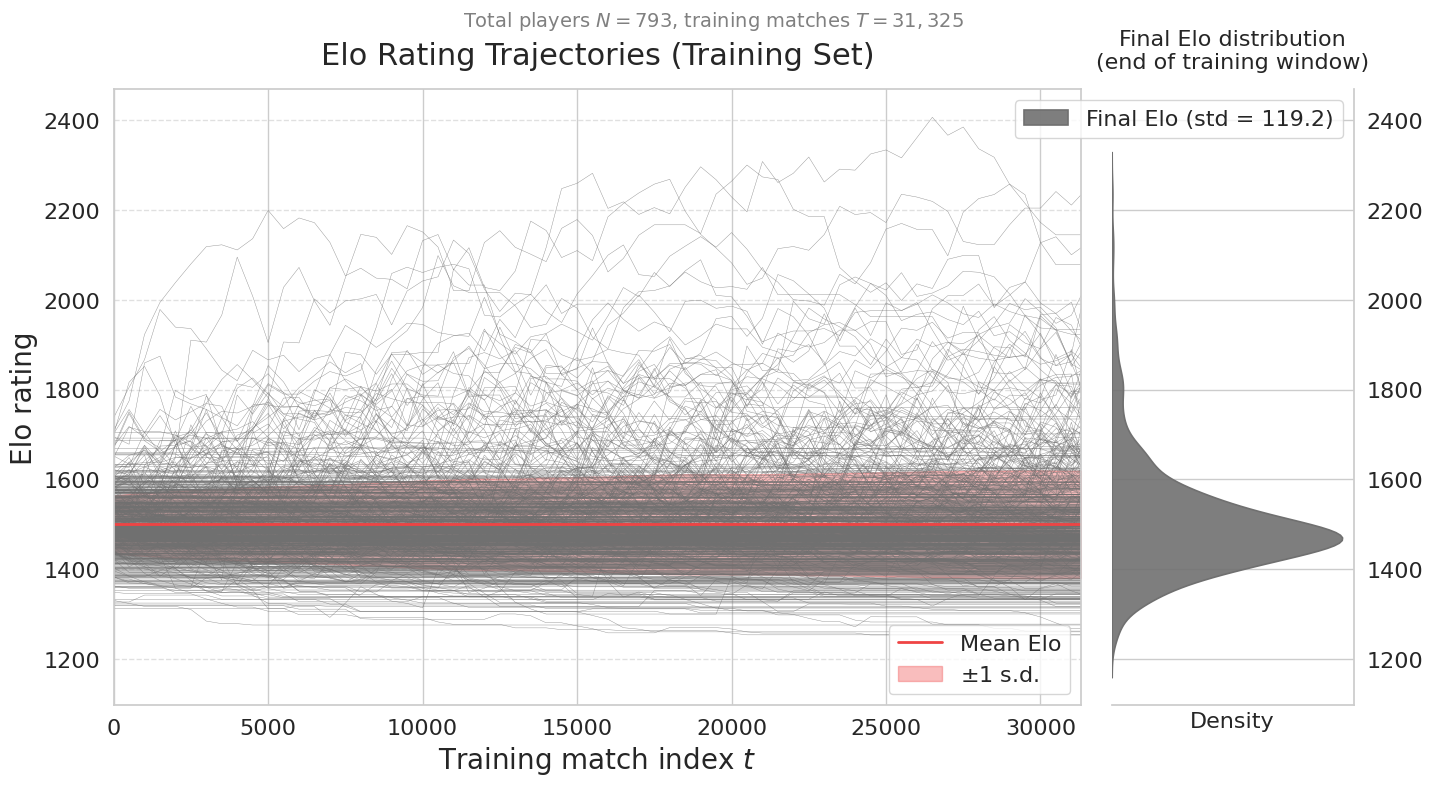

In [60]:
results_optimal = elo_forward_pass(E0_opt, elo_train_arrays)


elo_history_optimal = results_optimal["elo_history_df"]


plot_elo_trajectories(
    elo_history_optimal
)

In [61]:
# Create the Final Training Data Frame (1998-2018)
print("Final E0 Preparation (1998-2018)")

# Concatenate Train and Validation DataFrames
elo_df_final_train = pd.concat([elo_df_train, elo_df_valid], ignore_index=True)
print(f"Total Matches in Final Training Set (1998-2018): {len(elo_df_final_train):,}")

# Build Arrays for Final Optimization

elo_final_train_arrays = build_train_arrays(
    elo_df_final_train,
    i_col="i_id",
    j_col="j_id",
    y_col="i_won",
    k_value=32.0
)

M_final = elo_final_train_arrays["M"]
N_final = elo_final_train_arrays["N"]
print(f"Total Matches (M_final): {M_final:,}")
print(f"Total Players (N_final): {N_final:,}")


# Run Final Optimization (1998-2018) using Best Sigma
print(f"\nFinal E0 Optimization (1998-2018) using Optimal Sigma (σ={best_sigma:.4f})")

# Convert optimal sigma back to lambda
lambda_final = 1.0 / (2.0 * best_sigma**2)

res_fit_final = fit_E0_joint(
    elo_final_train_arrays,
    lambda_l2=lambda_final,
    E0_init_vec=None,
    max_iter=500,
    tol=1e-5,
    verbose=False,
)

# Extract the FINAL Optimized E0 Vector
E0_opt_final = np.asarray(res_fit_final["E0_opt"], dtype=float)


# Map E0_opt_final Vector to a Dictionary

idx_p_id = elo_final_train_arrays["idx_p_id"] # Player IDs in the optimized index order

# Create the final E0 map
E0_opt_final_map = {
    int(pid): float(elo)
    for pid, elo in zip(idx_p_id, E0_opt_final)
}

print(f"Final E0 Optimal Map (1998) created with {len(E0_opt_final_map):,} entries.")

Final E0 Preparation (1998-2018)
Total Matches in Final Training Set (1998-2018): 33,969
Total Matches (M_final): 33,969
Total Players (N_final): 837

Final E0 Optimization (1998-2018) using Optimal Sigma (σ=150.0000)
Final E0 Optimal Map (1998) created with 837 entries.


In [62]:
# --- 1. Run Final Forward Pass (1998-2019) using Optimal E0 Map ---

print("\n--- Final Model Forward Pass (Optimal E0) ---")

tennis_df_optimal_e0 = generate_elo_features(
    df_match=tennis_df_rank.copy(),
    initial_elos_map=E0_opt_final_map,
    fixed_k=32
)


# --- 2. Extract Test Set (2019) and Score ---

tennis_df_optimal_e0_test_2019 = tennis_df_optimal_e0[
    tennis_df_optimal_e0["year"] == 2019
].copy()

pi_i_optimal = tennis_df_optimal_e0_test_2019['i_won_prob'].to_numpy()
y_test_optimal = tennis_df_optimal_e0_test_2019['i_won'].to_numpy()

# Generate Metric Report for Optimal E0
metric_report_optimal_e0 = generate_metric_report(
    df_test=tennis_df_optimal_e0_test_2019,
    pi_i=pi_i_optimal,
    y_test=y_test_optimal,
    threshold=0.5
)


print("\nMetric Report for Optimal E0 (K=32) - 2019 Test Set:")
print(f"Optimal Sigma Used: {best_sigma:.4f}")

print(metric_report_optimal_e0.to_markdown(index=False, numalign="left", stralign="left"))



--- Final Model Forward Pass (Optimal E0) ---

Metric Report for Optimal E0 (K=32) - 2019 Test Set:
Optimal Sigma Used: 150.0000
| group_type    | group_name                                    | count   | accuracy   | calibration_c   | log_loss   |
|:--------------|:----------------------------------------------|:--------|:-----------|:----------------|:-----------|
| Overall       | Total                                         | 2606    | 0.636608   | 1.05396         | 0.637515   |
| rank_group    | Top 30 (Very Elite)                           | 1258    | 0.672496   | 1.06768         | 0.602404   |
| rank_group    | 31-100 (Strong)                               | 1245    | 0.604016   | 1.05144         | 0.671039   |
| rank_group    | > 100 (Challenger/Qualifiers, up to rank 314) | 103     | 0.592233   | 0.886867        | 0.661142   |
| tourney_level | A                                             | 1515    | 0.627723   | 1.04829         | 0.654809   |
| tourney_level | M           

In [63]:
# --- 3. Final Comparison (Accuracy Only) ---


cols_to_compare = ['group_type', 'group_name', 'accuracy']

# Merge the two reports based on the metric identifiers (group_type and group_name)
comparison_df_accuracy = metric_report_optimal_e0[cols_to_compare].merge(
    metric_report_vanilla_32[cols_to_compare],
    on=['group_type', 'group_name'],
    suffixes=('_Optimal', '_Vanilla')
)


comparison_df_accuracy.rename(columns={
    'accuracy_Optimal': 'Accuracy (Optimal E0)',
    'accuracy_Vanilla': 'Accuracy (Vanilla E0)',
    'group_type': 'Group Type',
    'group_name': 'Group Name'
}, inplace=True)


print("\n--- Final Model Comparison: Accuracy on Test Set (2019) ---")
print(comparison_df_accuracy.to_markdown(index=False, numalign="left", stralign="left"))



--- Final Model Comparison: Accuracy on Test Set (2019) ---
| Group Type    | Group Name                                    | Accuracy (Optimal E0)   | Accuracy (Vanilla E0)   |
|:--------------|:----------------------------------------------|:------------------------|:------------------------|
| Overall       | Total                                         | 0.636608                | 0.632771                |
| rank_group    | Top 30 (Very Elite)                           | 0.672496                | 0.670111                |
| rank_group    | 31-100 (Strong)                               | 0.604016                | 0.6                     |
| rank_group    | > 100 (Challenger/Qualifiers, up to rank 314) | 0.592233                | 0.572816                |
| tourney_level | A                                             | 0.627723                | 0.622442                |
| tourney_level | M                                             | 0.607207                | 0.609009             

# Below this are just the plots for the report


ELO Trajectory Summary for Top-3 Players (OPTIMAL E0 - end of 2019):
--------------------------------------------------
|    |   player_id | player_name    |   matches |   first_idx |   last_idx |   first_elo |   last_elo |
|---:|------------:|:---------------|----------:|------------:|-----------:|------------:|-----------:|
|  0 |      104745 | RAFAEL NADAL   |      1022 |       45091 |      98828 |     1650.61 |    2134.07 |
|  1 |      104925 | NOVAK DJOKOVIC |       977 |       52484 |      98822 |     1652.99 |    2125.35 |
|  2 |      103819 | ROGER FEDERER  |      1082 |       36262 |      98830 |     1707.39 |    2110.50 |


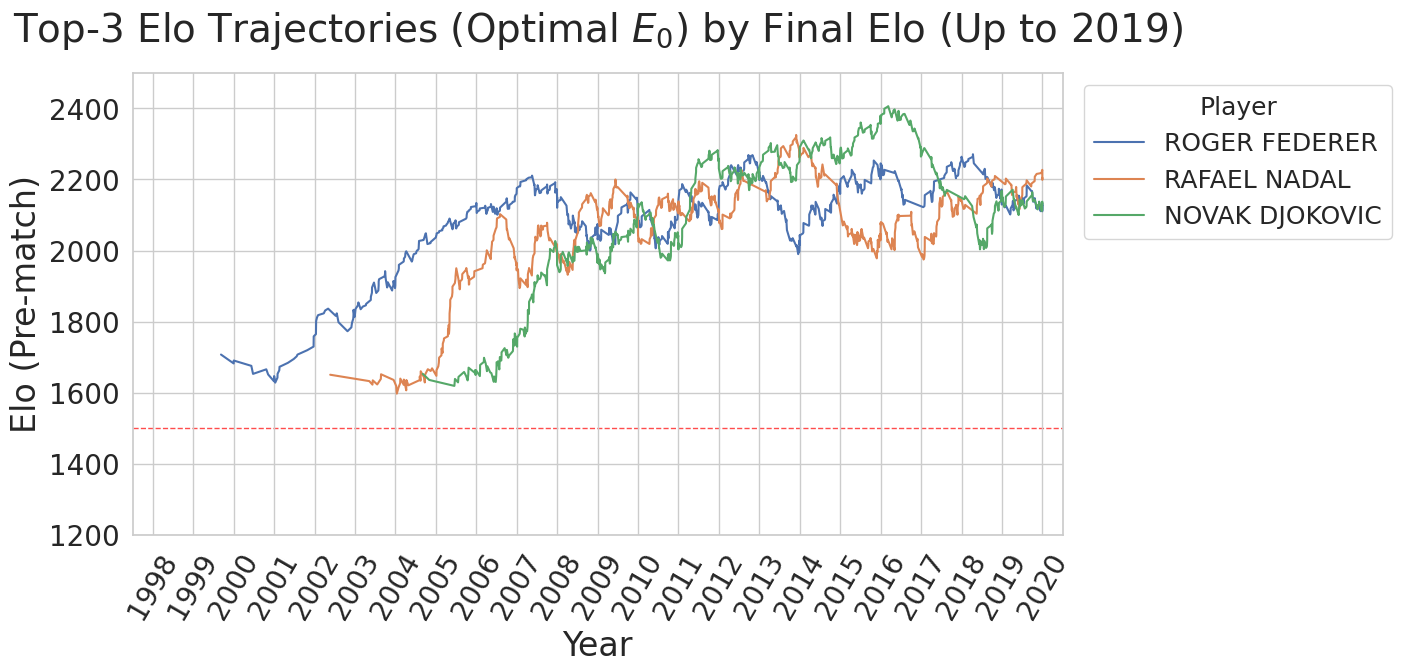

In [64]:
# -----------------------------------------------------------------------------
# ELO TRAJECTORY ANALYSIS (Top-3 Players, Match-by-Match Plot) - OPTIMAL E0
# -----------------------------------------------------------------------------

elo_ij_df_optimal = tennis_df_optimal_e0.copy()

sns.set_theme(style="whitegrid")

# -----------------------------
# 1. Prepare Long-Form Data
# -----------------------------

long_i = pd.DataFrame({
    "player_id": elo_ij_df_optimal["i_id"].to_numpy(),
    "player_name": elo_ij_df_optimal["i_name"].to_numpy(),
    "elo_pre": elo_ij_df_optimal["i_elo_pre"].to_numpy(),
    "global_time_idx": elo_ij_df_optimal["global_time_idx"].to_numpy(),
    "year": elo_ij_df_optimal["year"].to_numpy(),
})
long_j = pd.DataFrame({
    "player_id": elo_ij_df_optimal["j_id"].to_numpy(),
    "player_name": elo_ij_df_optimal["j_name"].to_numpy(),
    "elo_pre": elo_ij_df_optimal["j_elo_pre"].to_numpy(),
    "global_time_idx": elo_ij_df_optimal["global_time_idx"].to_numpy(),
    "year": elo_ij_df_optimal["year"].to_numpy(),
})
long_df_optimal = pd.concat([long_i, long_j], ignore_index=True)

# -------------------------------------------------------------
# 2. Identify Top-3 Players by Final ELO (Filter by year <= 2019 first)
# -------------------------------------------------------------

long_filtered_2019 = long_df_optimal[long_df_optimal["year"] <= 2019].copy()
long_sorted_2019 = long_filtered_2019.sort_values("global_time_idx")
last_idx_2019 = long_sorted_2019.groupby("player_id")["global_time_idx"].idxmax()
last_elo_2019 = long_sorted_2019.loc[last_idx_2019, ["player_id", "elo_pre"]].rename(
    columns={"elo_pre": "final_elo_pre"}
)
top3_ids = last_elo_2019.nlargest(3, "final_elo_pre")["player_id"].tolist()

# ----------------------------
# 3. Create Trajectory Data
# ----------------------------

top3_trajectory = long_filtered_2019[
    long_filtered_2019["player_id"].isin(top3_ids)
].copy()

# -------------------------------------------------------------
# 4. Create scaled X-axis (year-wise equal spacing, up to 2019)
# -------------------------------------------------------------

year_bounds_opt = (
    long_filtered_2019
    .groupby("year")["global_time_idx"]
    .agg(["min", "max"])
    .rename(columns={"min": "year_start", "max": "year_end"})
)

top3_trajectory = top3_trajectory.merge(
    year_bounds_opt,
    on="year",
    how="left"
)

top3_trajectory["x_year_scaled"] = (
    top3_trajectory["year"]
    + (top3_trajectory["global_time_idx"] - top3_trajectory["year_start"])
      / (top3_trajectory["year_end"] - top3_trajectory["year_start"] + 1)
)

# -------------------------------------------------------------
# 5. Create Summary Table
# -------------------------------------------------------------

first_match_indices = top3_trajectory.groupby("player_id")["global_time_idx"].idxmin()
first_elo_correct = top3_trajectory.loc[first_match_indices, ["player_id", "elo_pre"]].rename(
    columns={"elo_pre": "first_elo_correct"}
)
elo_summary_base = (
    top3_trajectory.groupby(["player_id", "player_name"], as_index=False)
        .agg(
            matches=("elo_pre", "count"),
            first_idx=("global_time_idx", "min"),
            last_idx=("global_time_idx", "max"),
            last_elo=("elo_pre", "last"),
        )
        .sort_values("last_elo", ascending=False)
        .reset_index(drop=True)
)
elo_summary = elo_summary_base.merge(
    first_elo_correct,
    on="player_id",
    how="left"
).rename(columns={"first_elo_correct": "first_elo"})
elo_summary = elo_summary[['player_id', 'player_name', 'matches',
                           'first_idx', 'last_idx', 'first_elo', 'last_elo']]

print("\nELO Trajectory Summary for Top-3 Players (OPTIMAL E0 - end of 2019):")
print("--------------------------------------------------")
print(elo_summary.to_markdown(floatfmt=".2f"))

# -----------
# 6. Plot
# -----------


plt.figure(figsize=(12, 6))

sns.lineplot(
    data=top3_trajectory.sort_values("global_time_idx"),
    x="x_year_scaled",
    y="elo_pre",
    hue="player_name",
    marker=None,
    dashes=False,
    errorbar=None
)

plt.xlabel("Year", fontsize=24)
plt.ylabel("Elo (Pre-match)", fontsize=24)
plt.title("Top-3 Elo Trajectories (Optimal $E_0$) by Final Elo (Up to 2019)",
          fontsize=28, y=1.05)

# X-axis: 1998–2020 with equal spacing
years = np.arange(1998, 2021)  # 1998–2020
plt.xticks(years, years.astype(str), rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# Fix x-limits (same style as vanilla plot)
plt.xlim(1997.5, 2020.5)

# ---- Y-axis: fixed range + reference line at 1500 ----
plt.ylim(1200, 2500)
plt.axhline(
    y=1500,
    linestyle="--",
    color="red",
    linewidth=1.0,
    alpha=0.7,
    zorder=0
)

plt.legend(
    title='Player',
    loc='upper left',
    bbox_to_anchor=(1.01, 1),
    fontsize=18,
    title_fontsize=18
)

plt.grid(True)
plt.show()

print("\n" + "="*80 + "\n")


ELO Trajectory Summary for Bottom-3 Players (OPTIMAL E0 - end of 2019):
--------------------------------------------------
|    |   player_id | player_name      |   matches |   first_idx |   last_idx |   first_elo |   last_elo |
|---:|------------:|:-----------------|----------:|------------:|-----------:|------------:|-----------:|
|  0 |      104233 | FREDERIK NIELSEN |         9 |       61745 |      80797 |     1310.51 |    1255.44 |
|  1 |      104770 | MARTIN FISCHER   |        20 |       62248 |      85556 |     1316.57 |    1255.61 |
|  2 |      103799 | ERIC PRODON      |        16 |       47612 |      77045 |     1325.25 |    1264.72 |


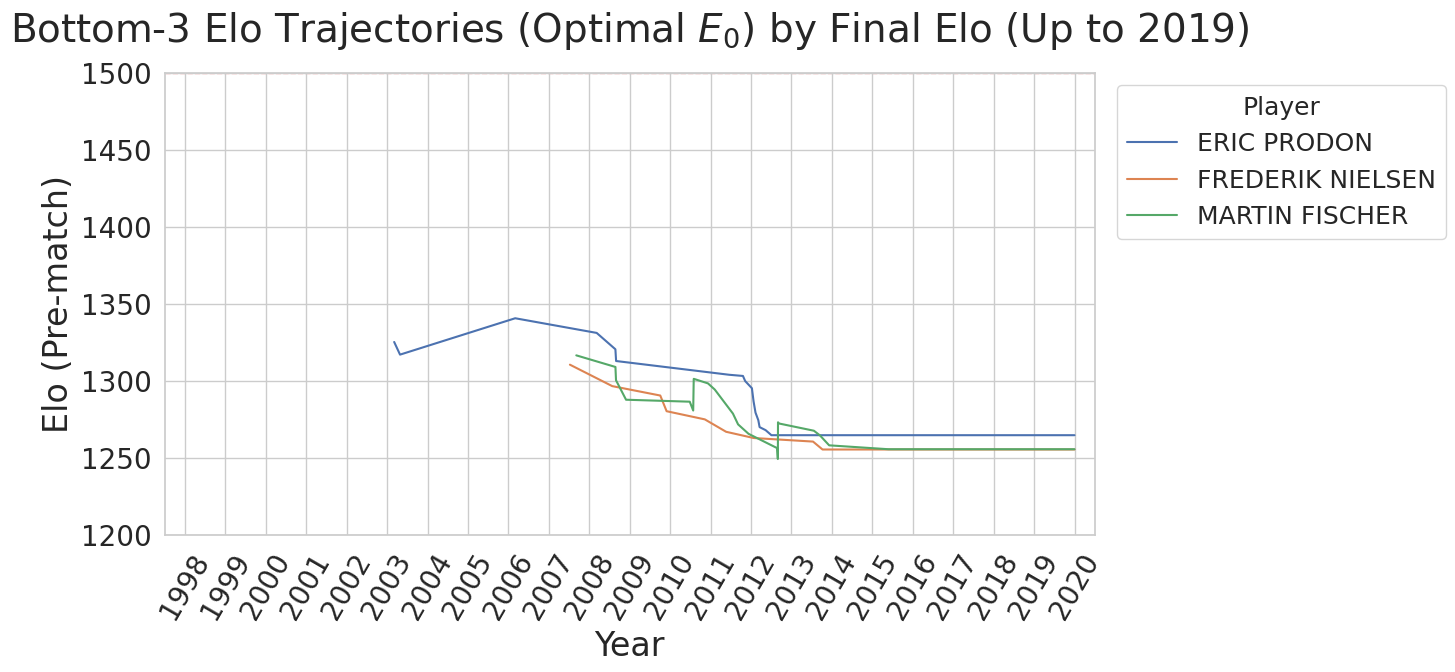

In [65]:
# -----------------------------------------------------------------------------
# ELO TRAJECTORY ANALYSIS (Bottom-3 Players, Match-by-Match Plot) - OPTIMAL E0
# -----------------------------------------------------------------------------

sns.set_theme(style="whitegrid")

# -------------------------------------------------------------
# 2. Identify Bottom-3 Players
# -------------------------------------------------------------

long_filtered_2019 = long_df_optimal[long_df_optimal["year"] <= 2019].copy()
long_sorted_2019 = long_filtered_2019.sort_values("global_time_idx")
last_idx_2019 = long_sorted_2019.groupby("player_id")["global_time_idx"].idxmax()
last_elo_2019 = long_sorted_2019.loc[last_idx_2019, ["player_id", "elo_pre"]].rename(
    columns={"elo_pre": "final_elo_pre"}
)
bottom3_ids = last_elo_2019.nsmallest(3, "final_elo_pre")["player_id"].tolist()

# -------------------------------------------------------------
# 3. Create Trajectory Data
# -------------------------------------------------------------

bottom3_trajectory_original = long_filtered_2019[
    long_filtered_2019["player_id"].isin(bottom3_ids)
].copy()

# -------------------------------------------------------------
# 3.5 Forward Fill ELO Trajectory to Year 2019 End
# -------------------------------------------------------------

max_idx_of_2019 = long_filtered_2019['global_time_idx'].max()
filled_trajectory_list = []
for player_id in bottom3_ids:
    player_data = bottom3_trajectory_original[
        bottom3_trajectory_original['player_id'] == player_id
    ].copy()

    last_elo = player_data['elo_pre'].iloc[-1]
    last_idx = player_data['global_time_idx'].iloc[-1]

    if last_idx < max_idx_of_2019:
        fill_row = pd.DataFrame({
            "player_id": [player_id],
            "player_name": [player_data['player_name'].iloc[0]],
            "elo_pre": [last_elo],
            "global_time_idx": [max_idx_of_2019],
            "year": [2019]
        })
        player_data = pd.concat([player_data, fill_row], ignore_index=True)

    filled_trajectory_list.append(player_data)

bottom3_trajectory = pd.concat(filled_trajectory_list, ignore_index=True)

# -------------------------------------------------------------
# 4. Create scaled X-axis (re-use year_bounds_opt from Top-3)
# -------------------------------------------------------------

bottom3_trajectory = bottom3_trajectory.merge(
    year_bounds_opt,
    on="year",
    how="left"
)

bottom3_trajectory["x_year_scaled"] = (
    bottom3_trajectory["year"]
    + (bottom3_trajectory["global_time_idx"] - bottom3_trajectory["year_start"])
      / (bottom3_trajectory["year_end"] - bottom3_trajectory["year_start"] + 1)
)

# -------------------------------------------------------------
# 5. Create Summary Table
# -------------------------------------------------------------

first_match_indices = bottom3_trajectory_original.groupby("player_id")["global_time_idx"].idxmin()
first_elo_correct = bottom3_trajectory_original.loc[first_match_indices, ["player_id", "elo_pre"]].rename(
    columns={"elo_pre": "first_elo_correct"}
)
elo_summary_base = (
    bottom3_trajectory_original.groupby(["player_id", "player_name"], as_index=False)
        .agg(
            matches=("elo_pre", "count"),
            first_idx=("global_time_idx", "min"),
            last_idx=("global_time_idx", "max"),
            last_elo=("elo_pre", "last"),
        )
        .sort_values("last_elo", ascending=True)
        .reset_index(drop=True)
)
elo_summary = elo_summary_base.merge(
    first_elo_correct,
    on="player_id",
    how="left"
).rename(columns={"first_elo_correct": "first_elo"})
elo_summary = elo_summary[['player_id', 'player_name', 'matches',
                           'first_idx', 'last_idx', 'first_elo', 'last_elo']]

print("\nELO Trajectory Summary for Bottom-3 Players (OPTIMAL E0 - end of 2019):")
print("--------------------------------------------------")
print(elo_summary.to_markdown(floatfmt=".2f"))

# -------------------------------------------------------------
# 6. Plot using Seaborn (Bottom-3, scaled year axis)
# -------------------------------------------------------------

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=bottom3_trajectory.sort_values("global_time_idx"),
    x="x_year_scaled",
    y="elo_pre",
    hue="player_name",
    marker=None,
    dashes=False,
    errorbar=None
)

plt.xlabel("Year", fontsize=24)
plt.ylabel("Elo (Pre-match)", fontsize=24)
plt.title("Bottom-3 Elo Trajectories (Optimal $E_0$) by Final Elo (Up to 2019)",
          fontsize=28, y=1.05)

years = np.arange(1998, 2021)
plt.xticks(years, years.astype(str), rotation=60, fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(1997.5, 2020.5)

# ---- Y-axis: fixed range + reference line at 1500 ----
plt.ylim(1200, 1500)
plt.axhline(
    y=1500,
    linestyle="--",
    color="red",
    linewidth=1.0,
    alpha=0.4,
    zorder=0
)

plt.legend(
    title='Player',
    loc='upper left',
    bbox_to_anchor=(1.01, 1),
    fontsize=18,
    title_fontsize=18
)

plt.grid(True)
plt.show()


ELO Trajectory Summary for Random 10 Players (5 <= Matches <= 10, End of 2019):
--------------------------------------------------
|    |   player_id | player_name        |   matches |   first_idx |   last_idx |   first_elo |   last_elo |
|---:|------------:|:-------------------|----------:|------------:|-----------:|------------:|-----------:|
|  0 |      105634 | VIKTOR GALOVIC     |         7 |       83551 |      97825 |     1500.00 |    1501.24 |
|  1 |      102957 | VADIM KUTSENKO     |         5 |       42735 |      50482 |     1500.00 |    1499.10 |
|  2 |      104226 | BASTIAN KNITTEL    |         5 |       71438 |      80297 |     1500.00 |    1491.95 |
|  3 |      103369 | MELLE VAN GEMERDEN |         8 |       52245 |      58699 |     1500.00 |    1491.49 |
|  4 |      106072 | ALEXEY VATUTIN     |         6 |       94177 |      98408 |     1500.00 |    1487.49 |
|  5 |      105318 | THOMAS SCHOOREL    |         6 |       72259 |      73966 |     1500.00 |    1484.30 |
|  6

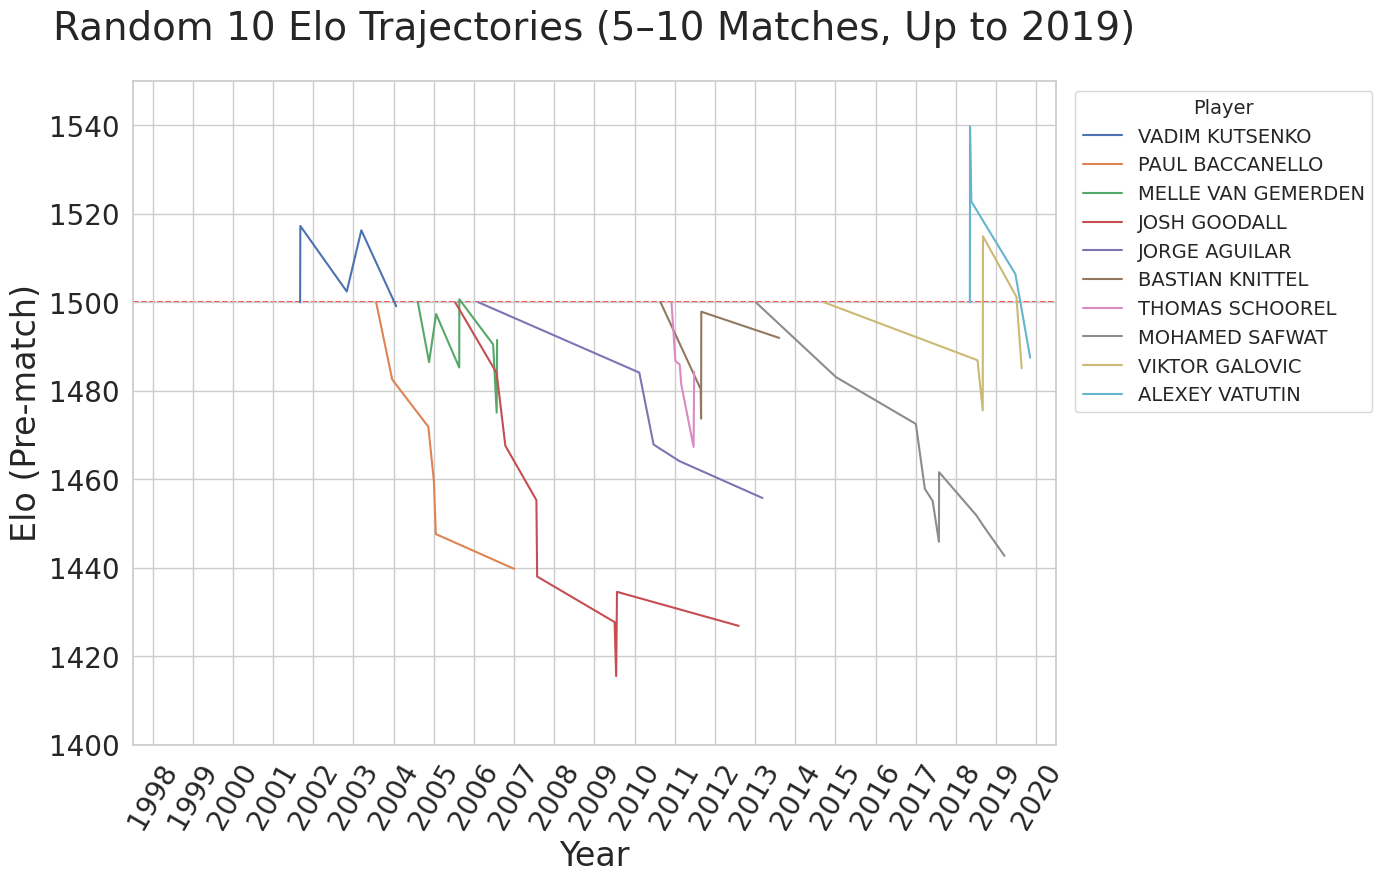

In [66]:
# -------------------------------------------------------------
# ELO TRAJECTORY ANALYSIS (Random 10 Players: 5 to 10 Match Count)
# -------------------------------------------------------------


sns.set_theme(style="whitegrid")

# -------------------------------------------------------------
# 2. Identify 10 Random Players (Match Count 5 to 10, Filter by year <= 2019)
# -------------------------------------------------------------

# 2a. Limit the data used for finding players to the year 2019 and prior
long_filtered_2019 = long_df[long_df["year"] <= 2019].copy()

# 2b. Calculate Match Counts (Count rows per player_id)
player_match_counts = (
    long_filtered_2019.groupby("player_id")
    .size()
    .reset_index(name="match_count")
)

# 2c. Calculate Final ELO (ELO at the end of 2019)
long_sorted_2019 = long_filtered_2019.sort_values("global_time_idx")
last_idx_2019 = long_sorted_2019.groupby("player_id")["global_time_idx"].idxmax()
last_elo_2019 = long_sorted_2019.loc[last_idx_2019, ["player_id", "elo_pre"]].rename(columns={"elo_pre": "final_elo_pre"})

# 2d. Merge Counts and ELO
player_summary = last_elo_2019.merge(player_match_counts, on="player_id")

# 2e. Apply Filter: Match Count between 5 and 10 (Inclusive)
filtered_players_5_to_10_match = player_summary[
    (player_summary["match_count"] >= 5) & (player_summary["match_count"] <= 10)
].copy()

# 2f. Select 10 RANDOM Players
N_PLAYERS_TO_PLOT = 10


if len(filtered_players_5_to_10_match) >= N_PLAYERS_TO_PLOT:
    random_10_low_match_ids = filtered_players_5_to_10_match.sample(
        n=N_PLAYERS_TO_PLOT,
        random_state=42
    )["player_id"].tolist()
else:
    print(f"Warning: Only {len(filtered_players_5_to_10_match)} players found with 5 <= matches <= 10. Selecting all of them.")
    random_10_low_match_ids = filtered_players_5_to_10_match["player_id"].tolist()

# -------------------------------------------------------------
# 3. Create Trajectory Data (using the Random 10 IDs)
# -------------------------------------------------------------

random_10_trajectory = long_filtered_2019[
    long_filtered_2019["player_id"].isin(random_10_low_match_ids)
].copy()

# -------------------------------------------------------------
# 4. Create scaled X-axis (year-wise equal spacing, up to 2019)
# -------------------------------------------------------------

year_bounds_rand = (
    long_filtered_2019
    .groupby("year")["global_time_idx"]
    .agg(["min", "max"])
    .rename(columns={"min": "year_start", "max": "year_end"})
)

random_10_trajectory = random_10_trajectory.merge(
    year_bounds_rand,
    on="year",
    how="left"
)

random_10_trajectory["x_year_scaled"] = (
    random_10_trajectory["year"]
    + (random_10_trajectory["global_time_idx"] - random_10_trajectory["year_start"])
      / (random_10_trajectory["year_end"] - random_10_trajectory["year_start"] + 1)
)

# -------------------------------------------------------------
# 5. Create Summary Table
# -------------------------------------------------------------
first_match_indices = random_10_trajectory.groupby("player_id")["global_time_idx"].idxmin()
first_elo_correct = random_10_trajectory.loc[first_match_indices, ["player_id", "elo_pre"]].rename(
    columns={"elo_pre": "first_elo_correct"}
)

elo_summary_base = (
    random_10_trajectory.groupby(["player_id", "player_name"], as_index=False)
        .agg(
            matches=("elo_pre", "count"),
            first_idx=("global_time_idx", "min"),
            last_idx=("global_time_idx", "max"),
            last_elo=("elo_pre", "last"),
        )
        .sort_values("last_elo", ascending=False)
        .reset_index(drop=True)
)

elo_summary = elo_summary_base.merge(
    first_elo_correct,
    on="player_id",
    how="left"
).rename(columns={"first_elo_correct": "first_elo"})

elo_summary = elo_summary[['player_id', 'player_name', 'matches',
                           'first_idx', 'last_idx', 'first_elo', 'last_elo']]

print("\nELO Trajectory Summary for Random 10 Players (5 <= Matches <= 10, End of 2019):")
print("--------------------------------------------------")
print(elo_summary.to_markdown(floatfmt=".2f"))

# -----------
# 6. Plot
# -----------

plt.figure(figsize=(14, 9))

sns.lineplot(
    data=random_10_trajectory.sort_values("global_time_idx"),
    x="x_year_scaled",
    y="elo_pre",
    hue="player_name",
    marker=None,
    dashes=False,
    errorbar=None,
    linewidth=1.5
)

plt.xlabel("Year", fontsize=24)
plt.ylabel("Elo (Pre-match)", fontsize=24)
plt.title("Random 10 Elo Trajectories (5–10 Matches, Up to 2019)", fontsize=28, y=1.05)

years = np.arange(1998, 2021)
plt.xticks(years, years.astype(str), rotation=60, fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(1997.5, 2020.5)


plt.ylim(1400, 1550)
plt.axhline(
    y=1500,
    color="red",
    linestyle="--",
    linewidth=1.1,
    alpha=1,
    zorder=0
)

plt.legend(
    title='Player',
    loc='upper left',
    bbox_to_anchor=(1.01, 1),
    fontsize=14,
    title_fontsize=14
)

plt.grid(True)
plt.tight_layout()
plt.show()



ELO Trajectory Summary for Top-5 Players (Based on ELO at end of 2019):
--------------------------------------------------
|    |   player_id | player_name     |   matches |   first_idx |   last_idx |   first_elo |   last_elo |
|---:|------------:|:----------------|----------:|------------:|-----------:|------------:|-----------:|
|  0 |      104745 | RAFAEL NADAL    |      1022 |       45091 |      98828 |     1500.00 |    2108.25 |
|  1 |      104925 | NOVAK DJOKOVIC  |       977 |       52484 |      98822 |     1500.00 |    2100.02 |
|  2 |      103819 | ROGER FEDERER   |      1082 |       36262 |      98830 |     1500.00 |    2086.36 |
|  3 |      106421 | DANIIL MEDVEDEV |       201 |       88658 |      98828 |     1500.00 |    1962.89 |
|  4 |      106233 | DOMINIC THIEM   |       409 |       74634 |      98831 |     1500.00 |    1962.71 |


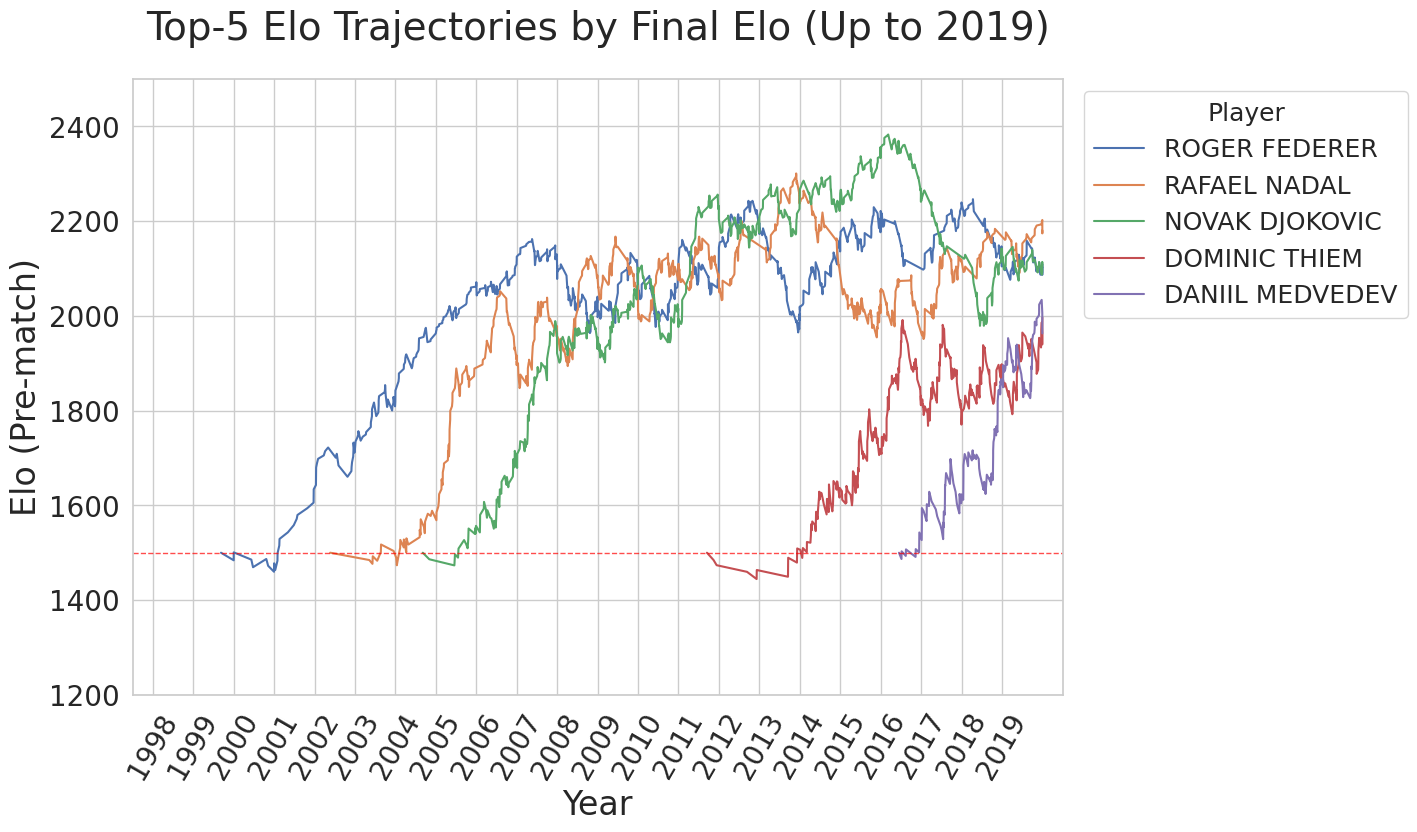

In [67]:
# -------------------------------------------------------------
# TOP-5 ELO TRAJECTORIES (same style as Top-3 figure)
# -------------------------------------------------------------


# 1. Pick top-5 players by final Elo at end of 2019
top5_ids = last_elo_2019.nlargest(5, "final_elo_pre")["player_id"].tolist()

# 2. Trajectory data for these 5 players
top5_trajectory = long_filtered_2019[
    long_filtered_2019["player_id"].isin(top5_ids)
].copy()

# 3. Attach per-year bounds and build scaled x-axis
top5_trajectory = top5_trajectory.merge(
    year_bounds,
    on="year",
    how="left"
)

top5_trajectory["x_year_scaled"] = (
    top5_trajectory["year"]
    + (top5_trajectory["global_time_idx"] - top5_trajectory["year_start"])
      / (top5_trajectory["year_end"] - top5_trajectory["year_start"] + 1)
)


first_match_indices_5 = top5_trajectory.groupby("player_id")["global_time_idx"].idxmin()
first_elo_correct_5 = top5_trajectory.loc[first_match_indices_5, ["player_id", "elo_pre"]].rename(
    columns={"elo_pre": "first_elo_correct"}
)

elo_summary_base_5 = (
    top5_trajectory.groupby(["player_id", "player_name"], as_index=False)
        .agg(
            matches=("elo_pre", "count"),
            first_idx=("global_time_idx", "min"),
            last_idx=("global_time_idx", "max"),
            last_elo=("elo_pre", "last"),
        )
        .sort_values("last_elo", ascending=False)
        .reset_index(drop=True)
)

elo_summary_5 = elo_summary_base_5.merge(
    first_elo_correct_5,
    on="player_id",
    how="left"
).rename(columns={"first_elo_correct": "first_elo"})

elo_summary_5 = elo_summary_5[
    ["player_id", "player_name", "matches", "first_idx", "last_idx", "first_elo", "last_elo"]
]

print("\nELO Trajectory Summary for Top-5 Players (Based on ELO at end of 2019):")
print("--------------------------------------------------")
print(elo_summary_5.to_markdown(floatfmt=".2f"))

# 5. Plot (same styling / axes as Top-3)
plt.figure(figsize=(12, 8))

sns.lineplot(
    data=top5_trajectory.sort_values("global_time_idx"),
    x="x_year_scaled",
    y="elo_pre",
    hue="player_name",
    marker=None,
    dashes=False,
    errorbar=None
)

plt.xlabel("Year", fontsize=24)
plt.ylabel("Elo (Pre-match)", fontsize=24)
plt.title("Top-5 Elo Trajectories by Final Elo (Up to 2019)", fontsize=28, y=1.05)

# Y-axis: fixed range + baseline at 1500 (same as other figures)
plt.ylim(1200, 2500)
plt.axhline(y=1500, linestyle="--", linewidth=1, alpha=0.7, color="red")

# X-axis ticks: 1998–2019, equal spacing
years = np.arange(1998, 2020)
plt.xticks(years, years.astype(str), rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# A little margin left/right for aesthetics
plt.xlim(1997.5, 2020.5)

plt.legend(
    title="Player",
    loc="upper left",
    bbox_to_anchor=(1.01, 1),
    fontsize=18,
    title_fontsize=18
)

plt.grid(True)
plt.show()